## Мандрикова Анастасия
## Отчет-1 к зачету

In [1]:
library("Rssa")
library(mFilter)

Loading required package: svd

Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'Rssa'


The following object is masked from 'package:stats':

    decompose




# Периодограммы

Сгенерируем ряд как сумму линенйного тренда и шума.

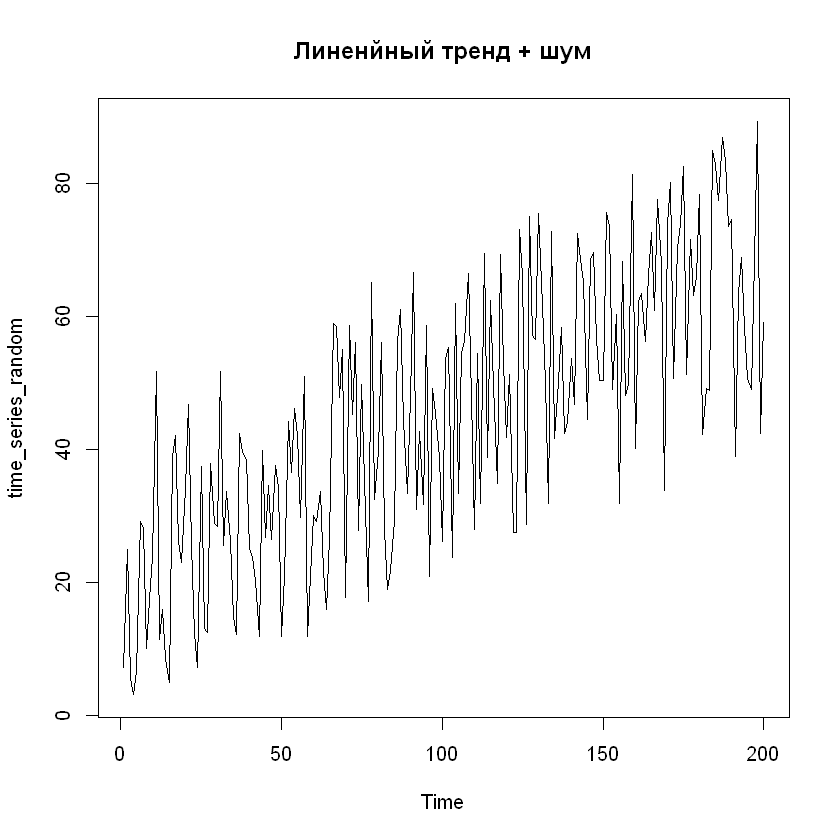

In [2]:
set.seed(520)
n <- 1:200
time_series_random <- ts(runif(200, 0, 50) + 0.2*n)
plot(time_series_random, type = "l", main = "Линенйный тренд + шум")

Перейдем к рассмотрению периодограммы ряда, которая выглядит следующим образом:   
$$П\left(\frac{k}{N}\right) = \frac{N}{2} \begin{equation*}
\begin{cases}
   с_{0}^{2},\; k=0\\
   с_{N/2}^{2},\; N - \text{четное или } k=N/2\\
   с_{k}^{2}+s_{k}^{2},\; \text{инчае}.\\
 \end{cases}
\end{equation*}$$

Здесь $c_k,\, s_k$ - коэффициенты в разложении Фурье, N - число точек ряда.

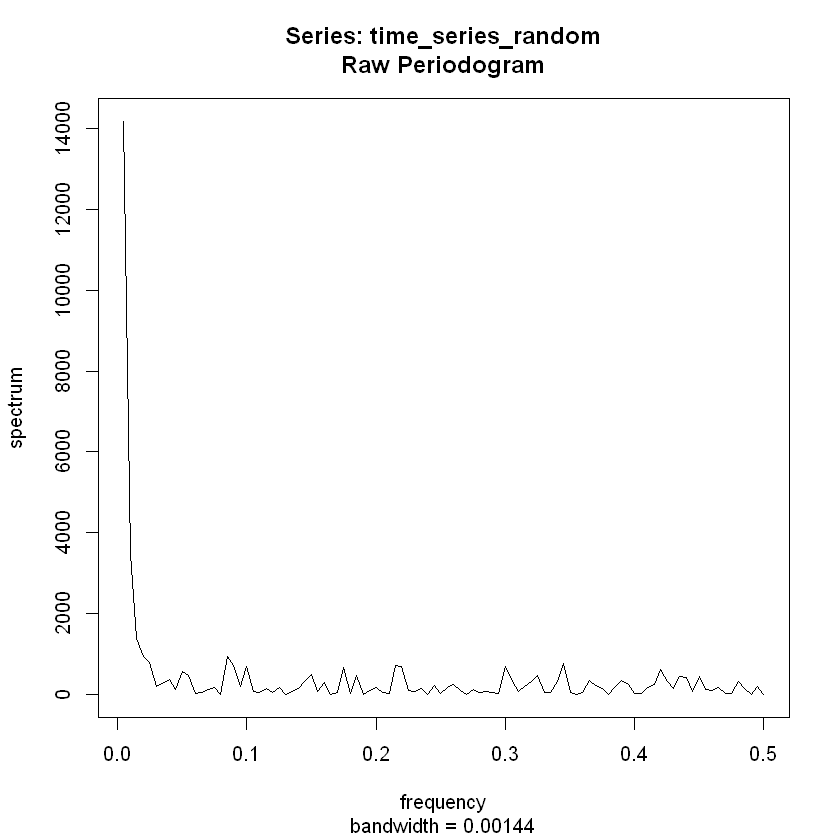

In [3]:
spec.pgram(time_series_random, detrend = F, log = 'no', taper = 0)

Периодограмма представленна без удаления тренда. Посмотрим на периодограмму того же ряда без тренда. 

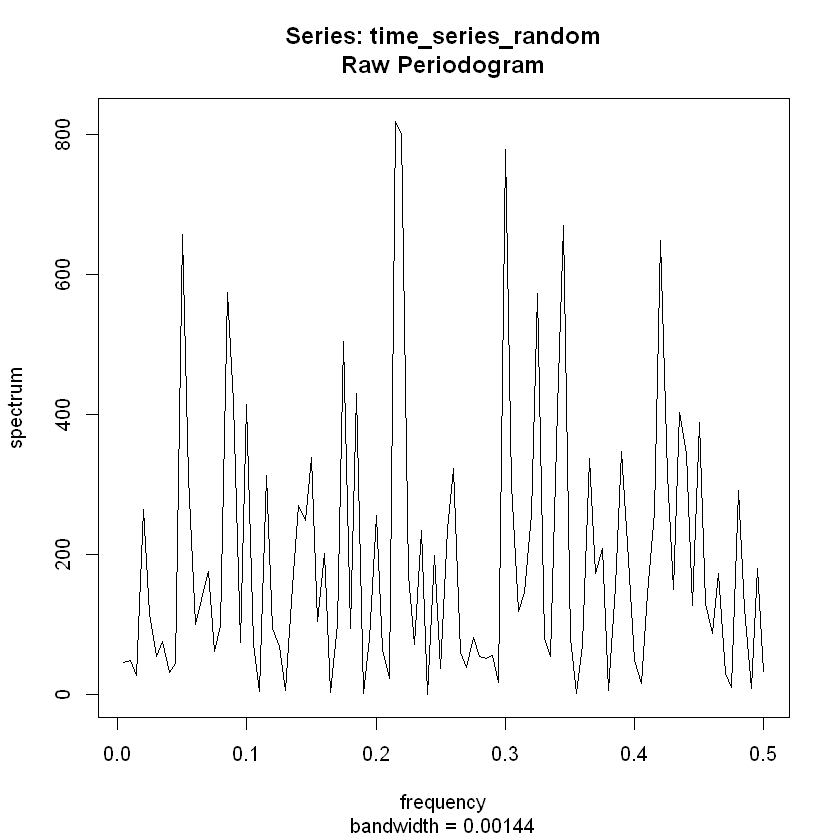

In [4]:
spec.pgram(time_series_random, detrend = T, log = 'no', taper = 0)

Заметим, что низких частот стало представленно меньше. (Как и ожидалось, тренд - низкочастотные колебания). В начале графика появился "пропуск", вероятно это так как тренд удалился вместе с частью шума. 

Сгенерируем белый гауссовский шум ($E\epsilon_n = 0,\; D\epsilon_n = 1$).

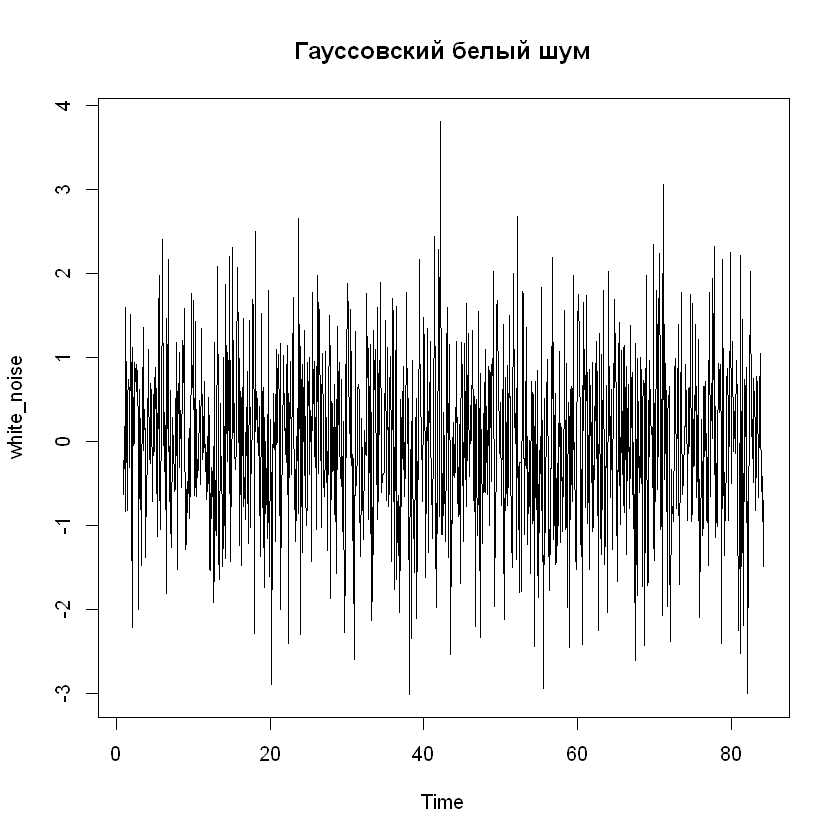

In [5]:
set.seed(1)
N <- 1000
white_noise <- ts(rnorm(N, 0, 1), frequency = 12)
plot(white_noise, type="l", main = 'Гауссовский белый шум')

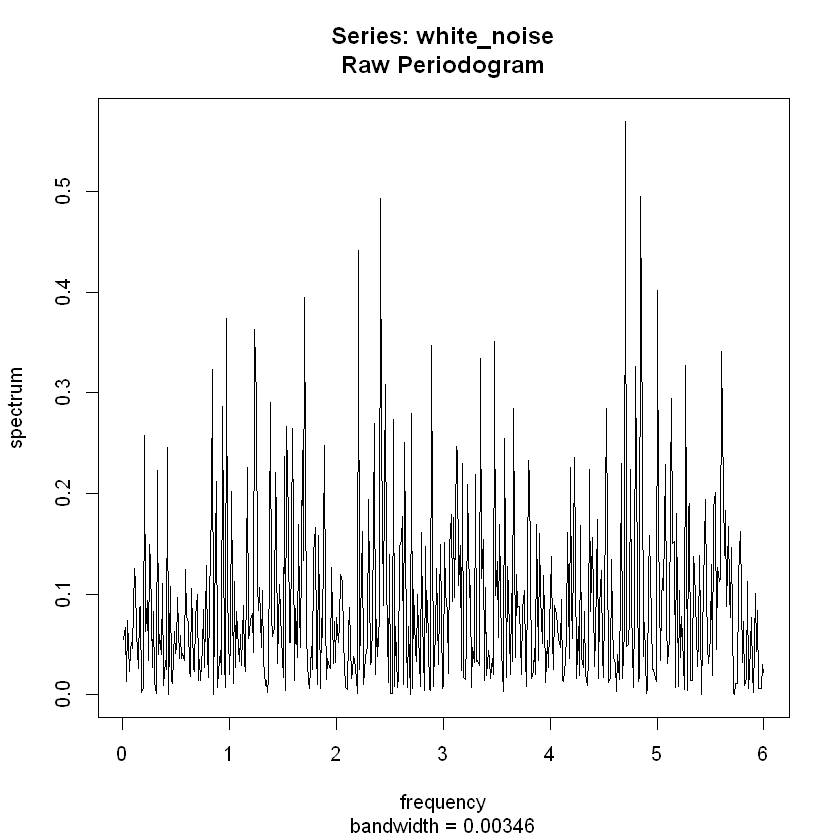

In [6]:
spec.pgram(white_noise, log='no', taper = 0)

Частоты вносят практически одинаковый вклад. Для нормального шума значения периодограммы имеют экспоненциальное распределение. Поэтому на периодограмме наблюдаются не очень редкие большие значения. 

Рассмотрим красный шум: $x_n = \varphi \cdot x_{n-1} + \epsilon_{n}, \; 0 < \varphi < 1$.

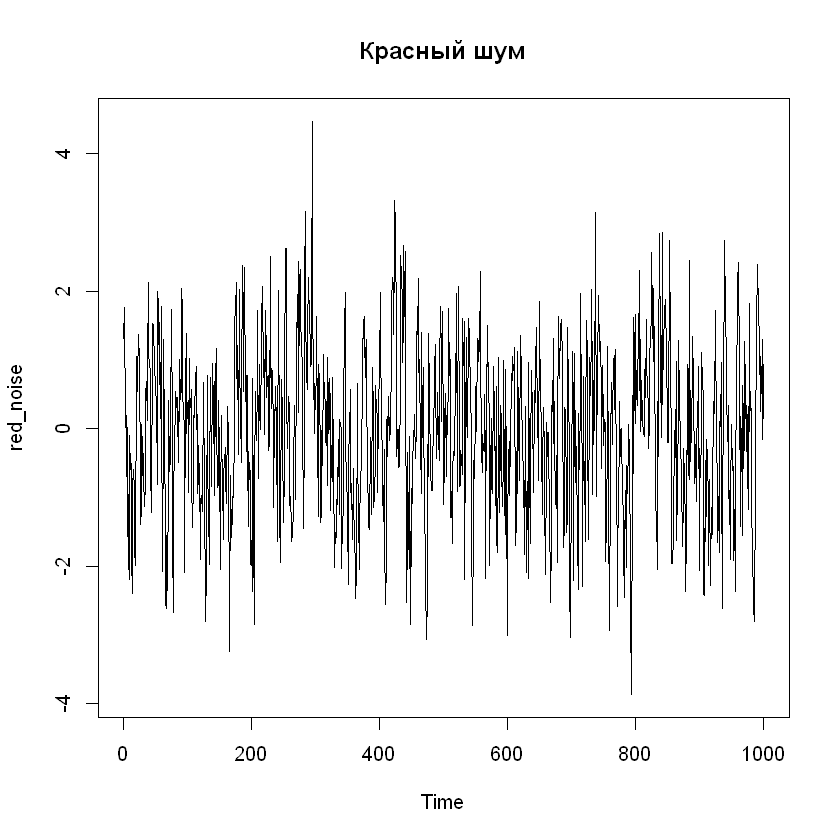

In [7]:
phi = 0.5
red_noise <- numeric(length = N)

red_noise[1] <- rnorm(1, sd = sqrt(1/(1-phi^2))) # т.к. дисперсия не должна зависеть от времени, 
                                                 # а D(x_t) = sigma^2/(1-phi^2), где sigma^2 = D(\epsilon_i)
for (i in 2:N){
    red_noise[i] <- phi*red_noise[i-1]+rnorm(1)
}
red_noise <- ts(red_noise)
plot(red_noise, type = "l", main = "Красный шум")

Из-за корреляции в средем ряд более выраженно двигается вниз, вверх в отличии от хаотичного движения белого шума. 

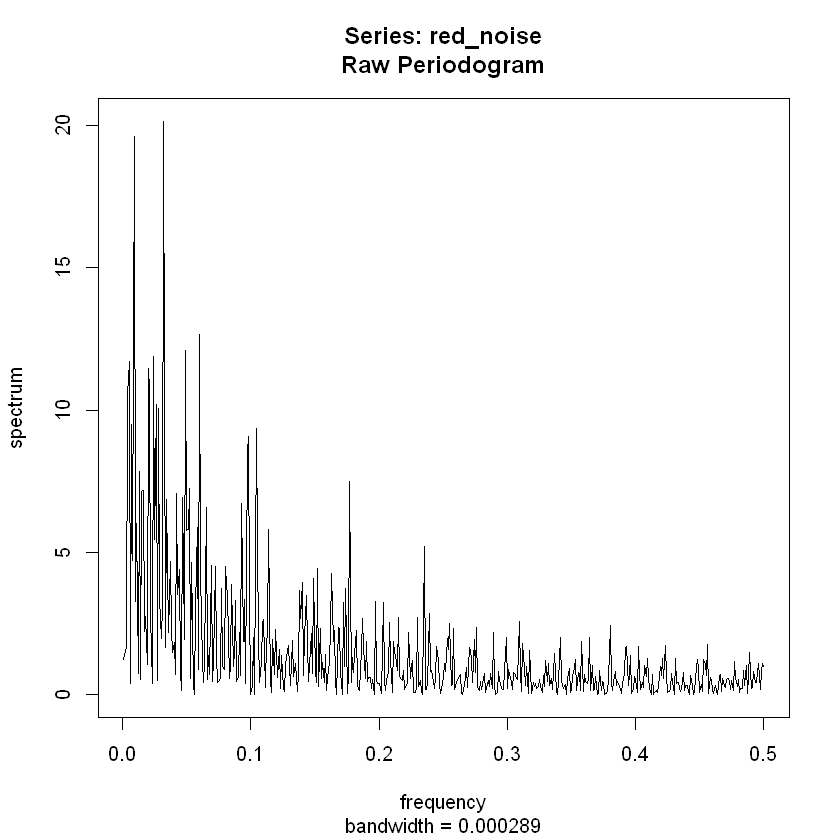

In [8]:
spec.pgram(red_noise, detrend = F, log = 'no', taper = 0)

В отличии от белого шума наблюдаем больший вклад низких частот.  Пусть ряд это тренд с добавлением шума. В случае, когда шум белый, тренд выделить проще. Так как у красного шума низких частот много и он смешается с трендом.
   
Перейдем к рассмотрению периодической компоненты ряда.   
Например, рассмотрим $x_n = A \cdot \cos(2\pi\omega n + \varphi), \; \omega = k_0/N$.

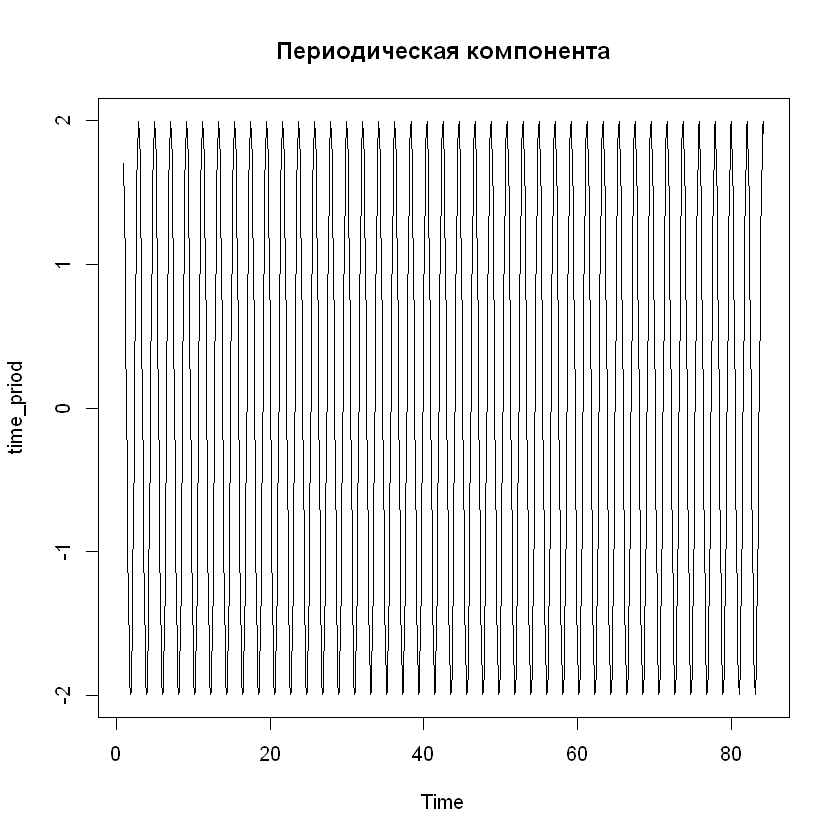

In [9]:
A <- 2
n <- 1:N
phi <- 0.3
omega <- 40/N
time_priod <- ts(A*cos(2*pi*omega*n + phi), frequency = 12)
plot(time_priod, type = "l", main = "Периодическая компонента")

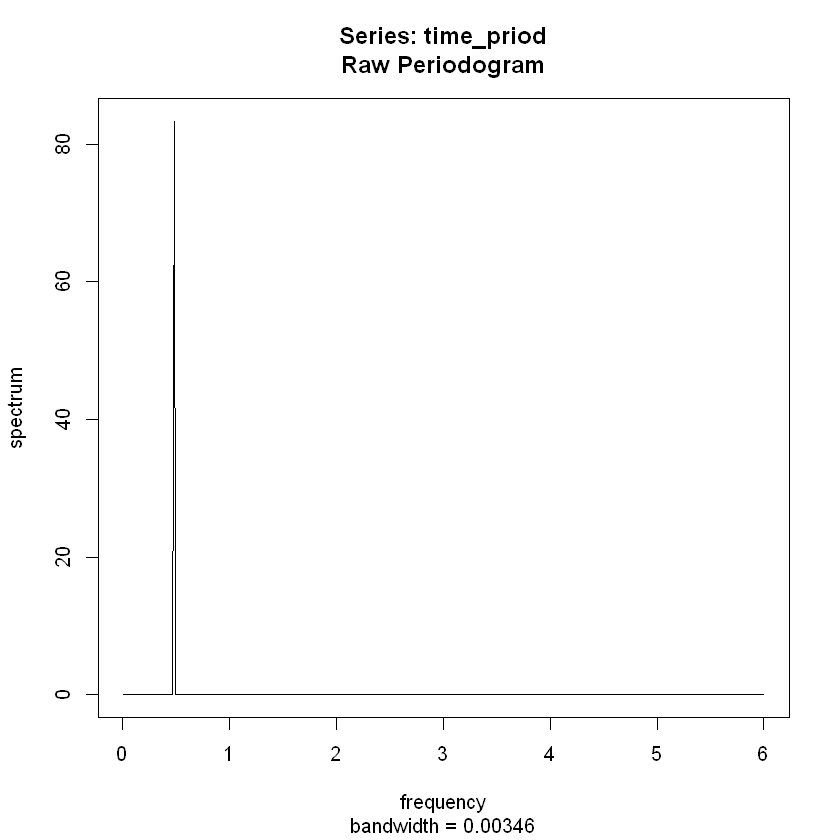

In [10]:
spec.pgram(time_priod, log = 'no', taper = 0)

Частота $\omega$ попала в решётку, поэтому не наблюдается растекания. 

Переходим к рассмотрению тренда. Пусть он линенйный. 

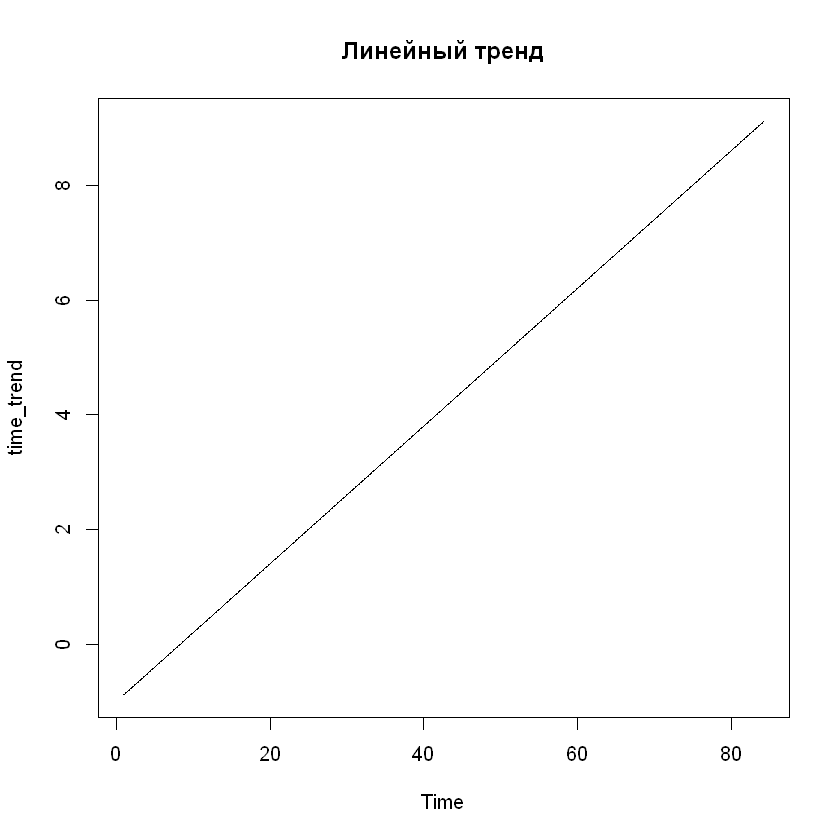

In [11]:
n <- 1:N
k <- 1/100
b <- rnorm(1)
time_trend <- ts(k*n+b, frequency = 12)
plot(time_trend, type = "l", main = "Линейный тренд")

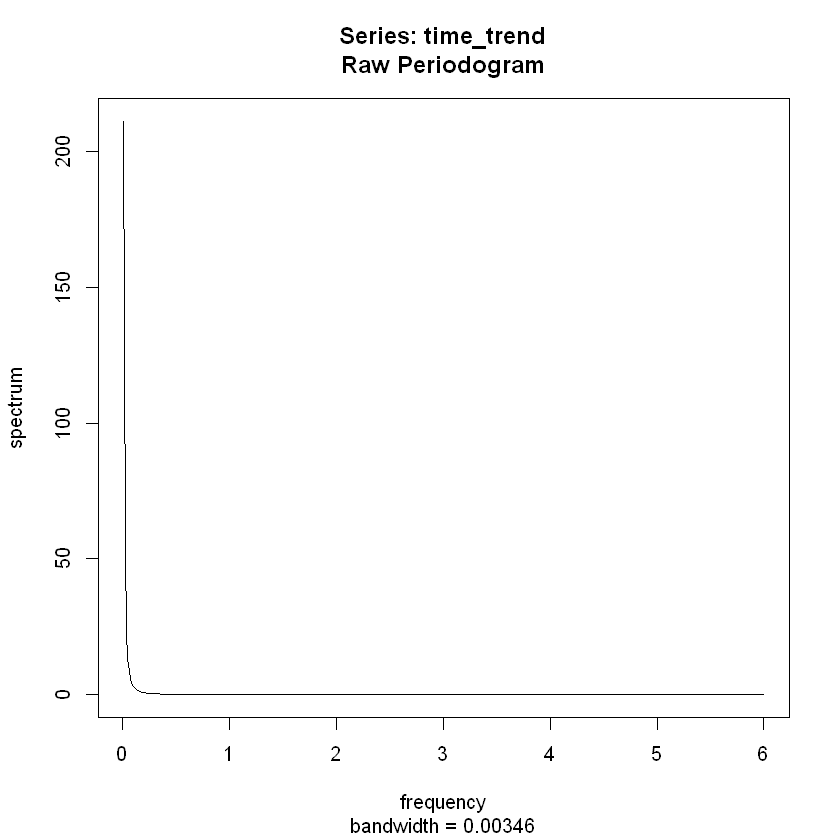

In [12]:
spec.pgram(time_trend, detrend = F, log = 'no', taper = 0)

Как и ожидалось, наблюдаются только самые низкие частоты. Соеденим рассматриваемые компоненты ряда: $X_n = T_n + P_n + E_n$.

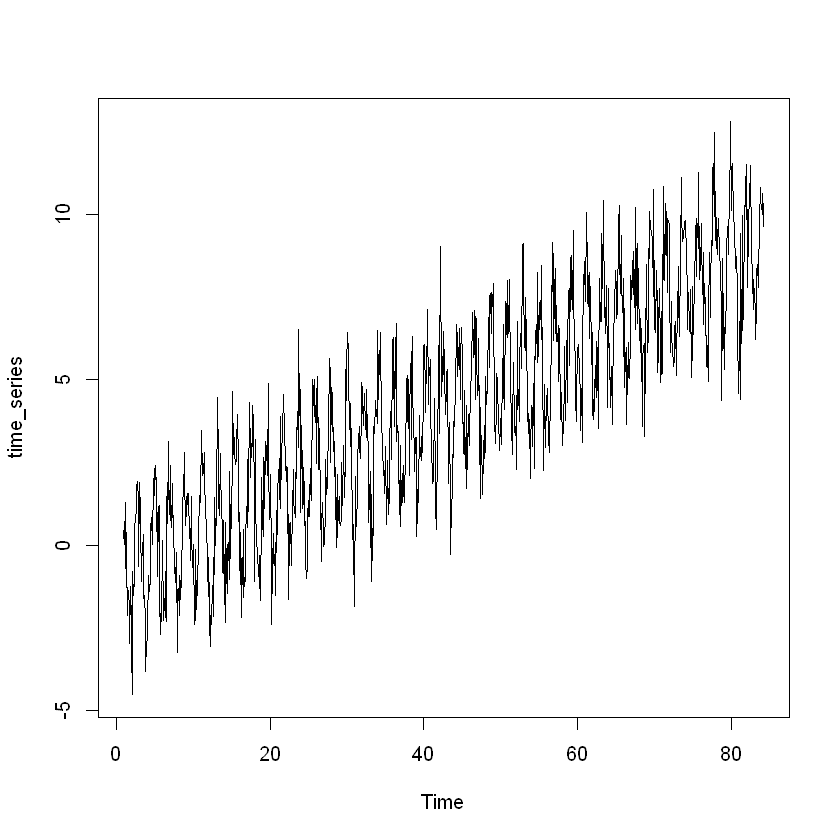

In [13]:
time_series <- time_trend + time_priod + white_noise
plot(time_series)

Посмотрим на периодограмму ряда без и с удалением тренда.

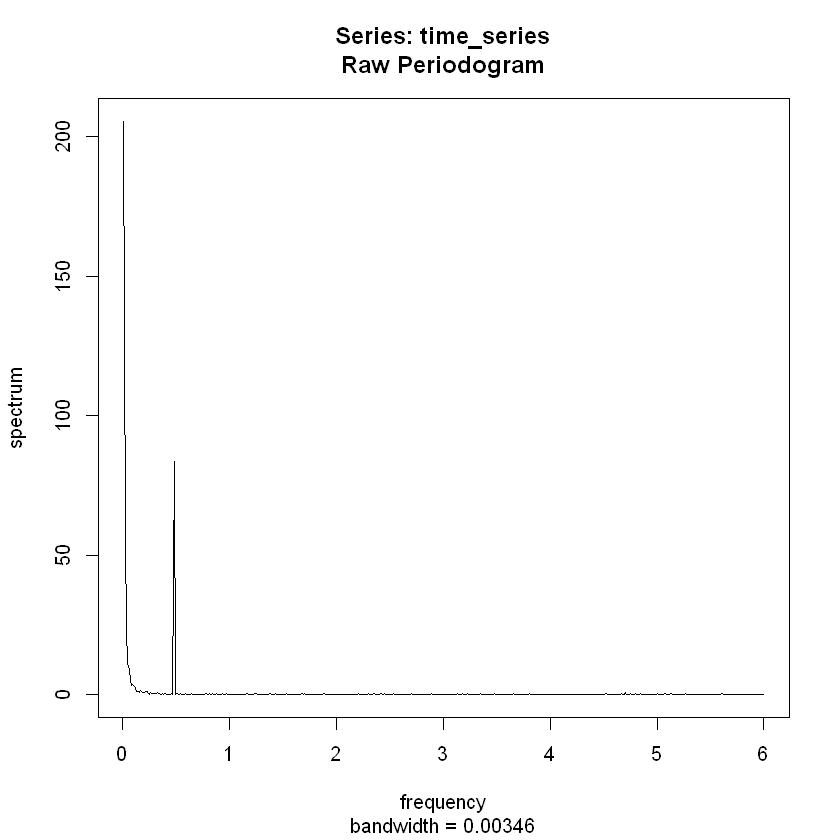

In [14]:
spec.pgram(time_series, detrend = F, log = 'no', taper = 0)

Видна и частота, связанная с периодичностью и низкие частоты тренда. Удалим тренд и посмотрим на периодограмму..

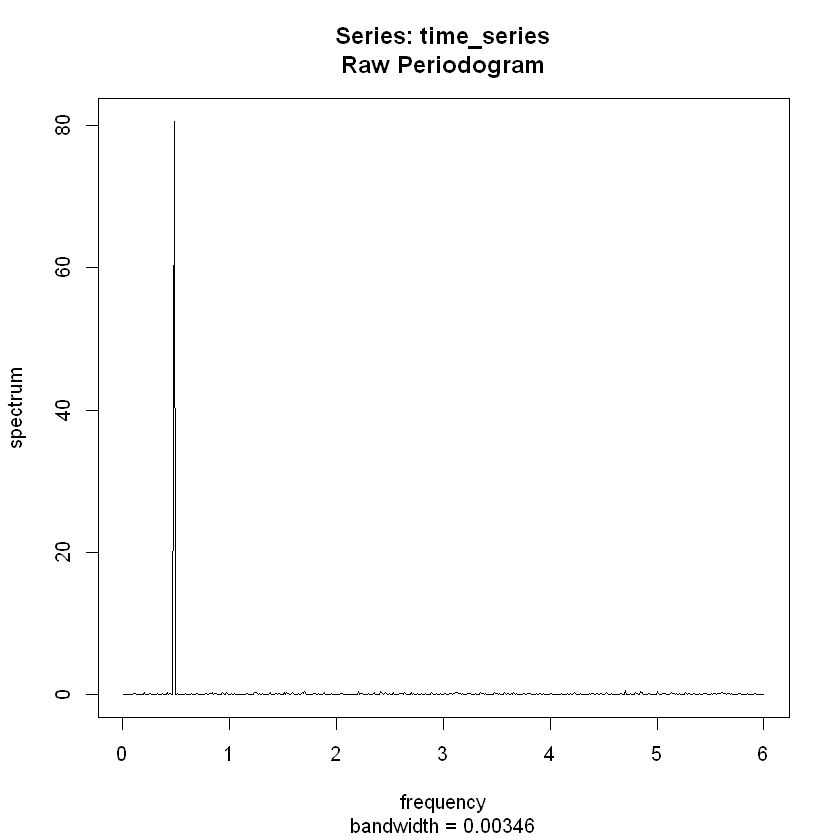

In [15]:
spec.pgram(time_series, log = 'no', taper = 0)

Конечно же, частота периодичности осталась и более явно стало видно, что шум имеет низкий вклад по всем частотам. 

### Реальный временной ряд   
Возьмем для примера ряд продаж по пиву, вину, ликерам в миллионах долларов (без корректировки сезонности, периодичность - месяц).

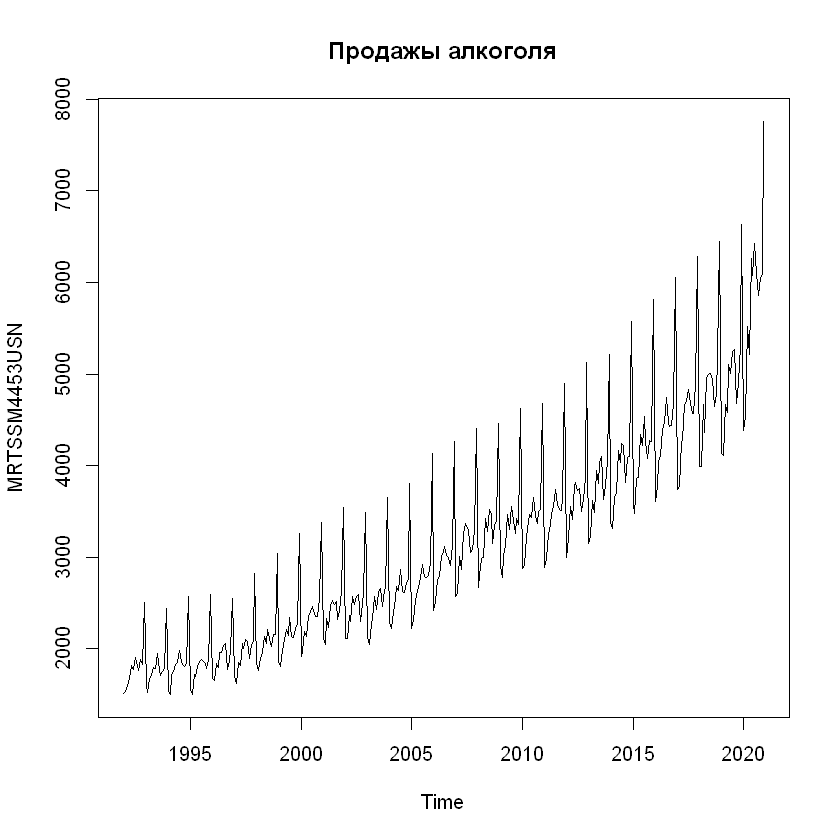

In [16]:
data <- read.table('series.csv', sep=',', header=T, row.names = 1)
data <- ts(data, start = c(1992, 1), frequency = 12)
plot(data, main = 'Продажы алкоголя')
# удалим некоторые точки в конце, чтобы анализу не мешала возникшая в 2020 году неоднородность
data <- window(data, start = c(1992, 1), end = c(2019, 12))

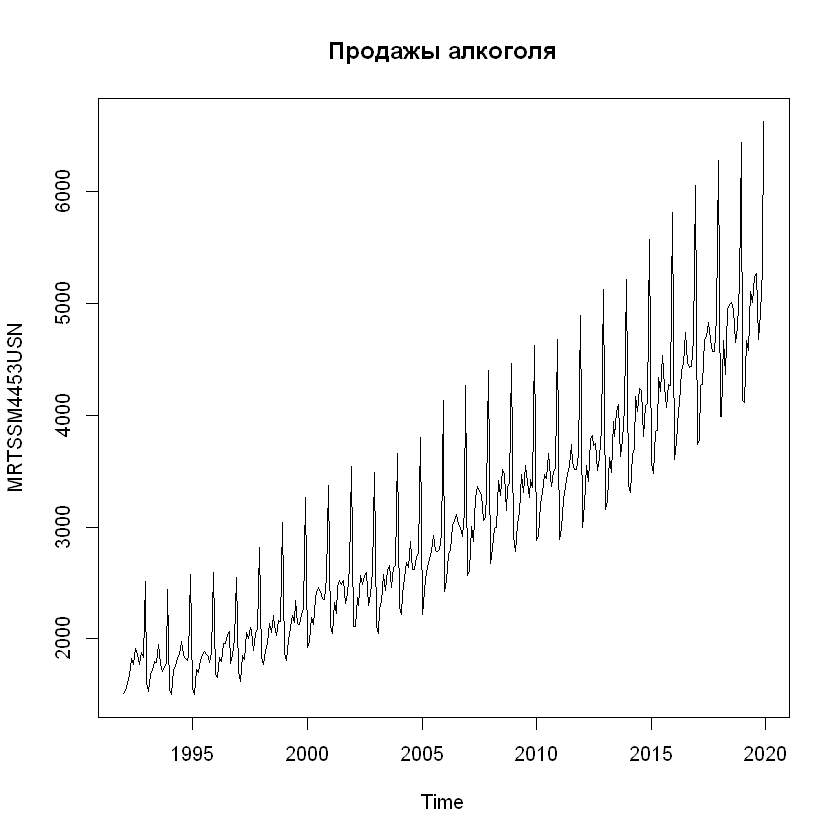

In [17]:
plot(data, main = 'Продажы алкоголя')

Периодограмма без удаления тренда.

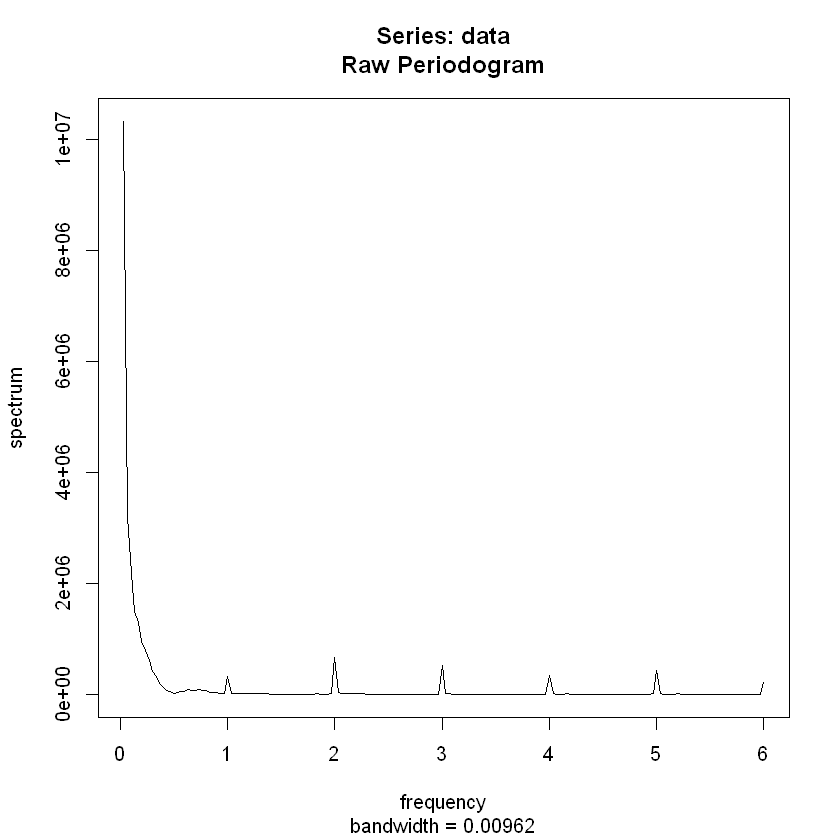

In [18]:
spec.pgram(data, detrend = F, log='no', taper = 0)

Периодограмма с вычитанием тренда тренда.

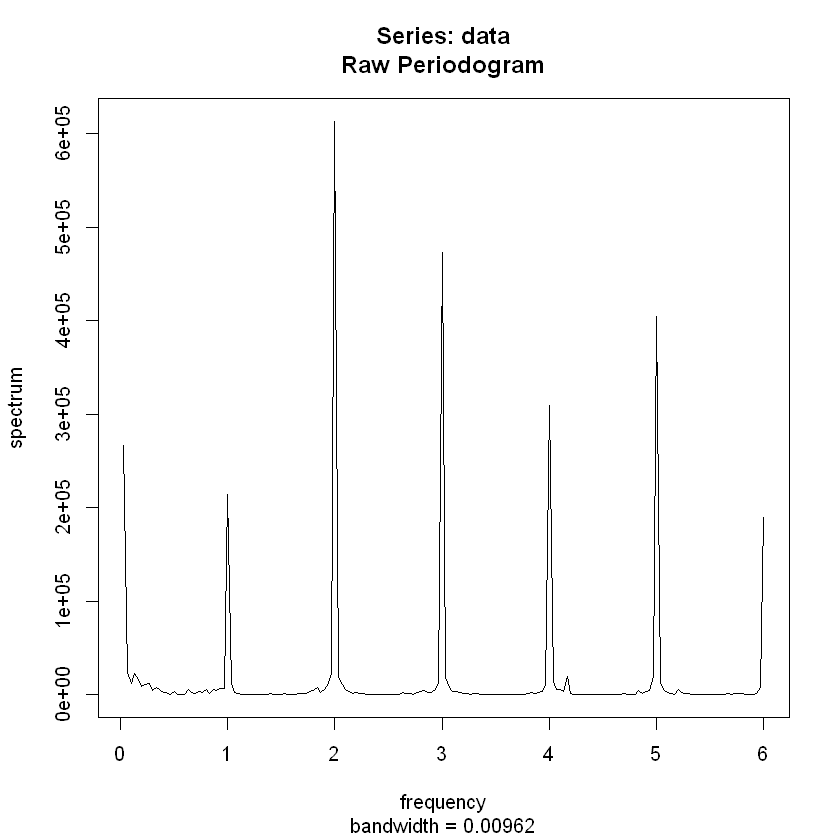

In [19]:
spec.pgram(data, log = 'no', taper = 0)

На графике видно, что наибольшие пики находятся в сетке сезонности. Самый большой пик в точке $2$, т.е. в периоде $2/12$, что говорит о наличии сильной полугодовой составляющей сезонности.

# Фильтры и АЧХ
Вспомогательная функция для графиков ачх.

In [20]:
afc <- function(filter, omega) {
    k <- seq_along(filter) - 1
    h <- function(o) sum(rev(filter) * exp(-k*1i * o))
    abs(sapply(omega, h))
}

filtered <- function(x, filt){stats::filter(x, filt, sides=2)}

freq <- seq(0, pi, 0.001)
omega <- freq/2/pi

Рассмотрим ряд, содержащий все основные компоненты: $X_n = T_n + S_n + \epsilon_n$.

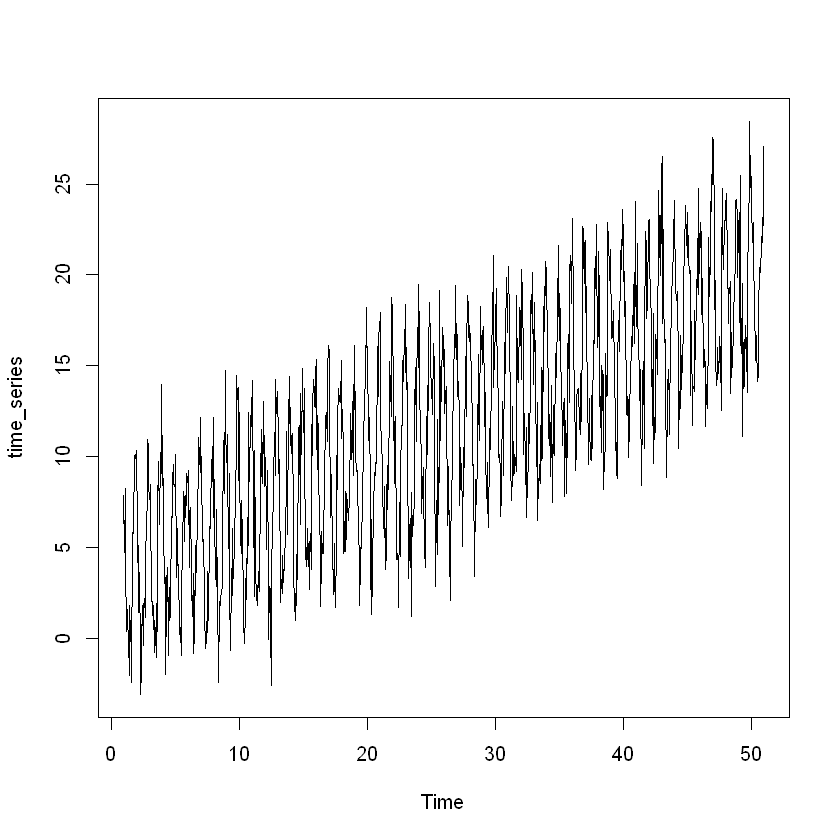

In [21]:
set.seed(1)
N <- 1000
A <- 5
n <- 1:N
phi <- 0.3
omega_per <- 50/N
k <- 1/60
b <- rnorm(1, 4, 1)

white_noise <- ts(rnorm(N, 0, 2), frequency = 20)
time_priod <- ts(A*cos(2*pi*omega_per*n + phi), frequency = 20)
time_trend <- ts(k*n+b, frequency = 20)
time_series <- time_trend + time_priod + white_noise
plot(time_series)

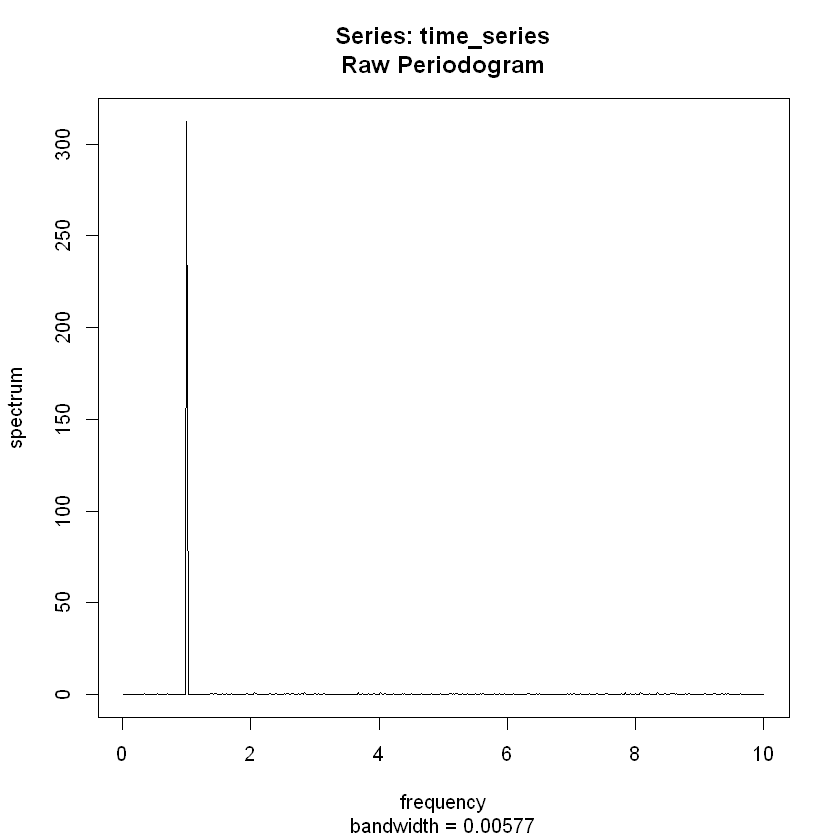

In [22]:
spec.pgram(time_series, log = 'no', taper = 0)

На периодограмме видим пик, относящийся к сезонности.   
Рассмотрим результат применения скользящего среднего в зависимости от длины окна. Чтобы убрать периодичность, длина окна должна быть кратна $20$.

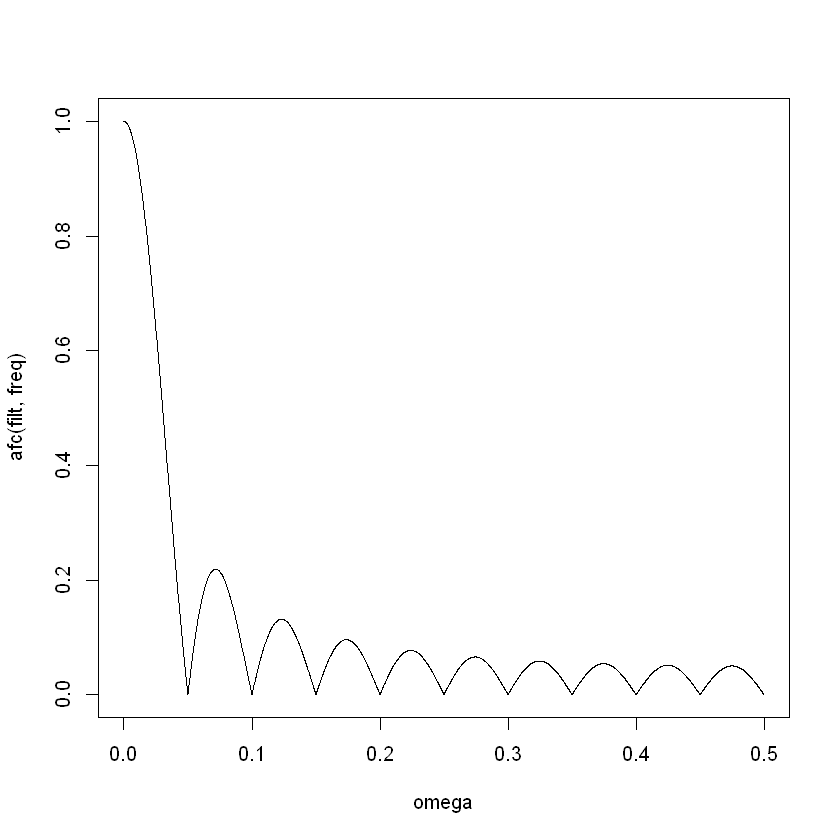

In [23]:
filt <- rep(1/20, 20)
plot(afc(filt, freq) ~ omega, type = 'l')

Из графика видим, что применение фильтра подавит сезонность, но выделится тренд. 

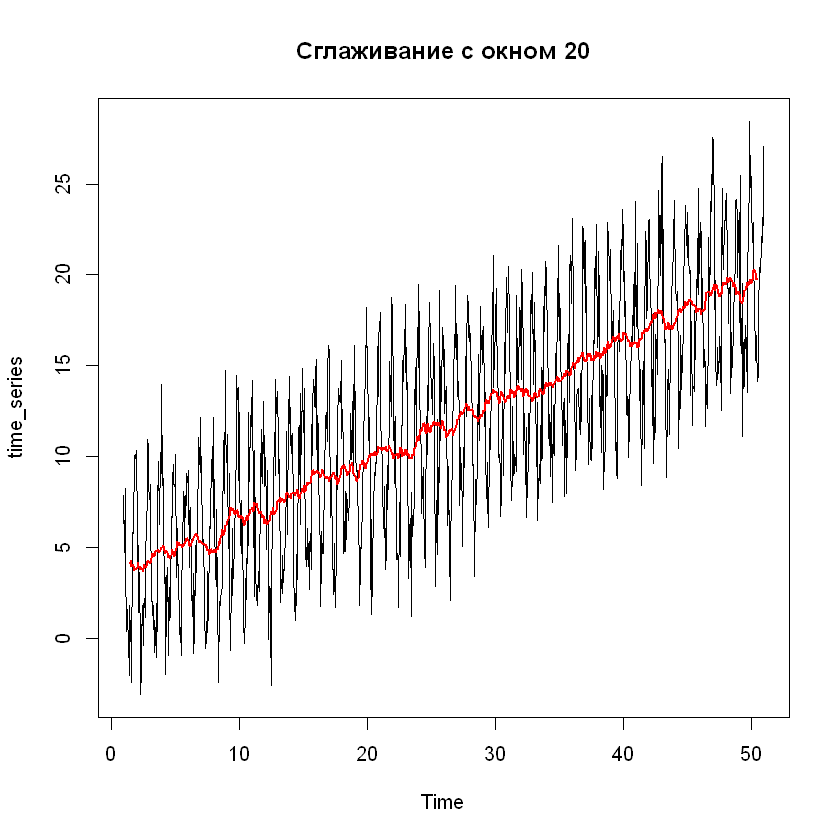

In [24]:
plot(time_series, main = "Сглаживание с окном 20")
time_filt <- filtered(time_series, filt)
lines(time_filt, col = "red", lwd = 1.7)

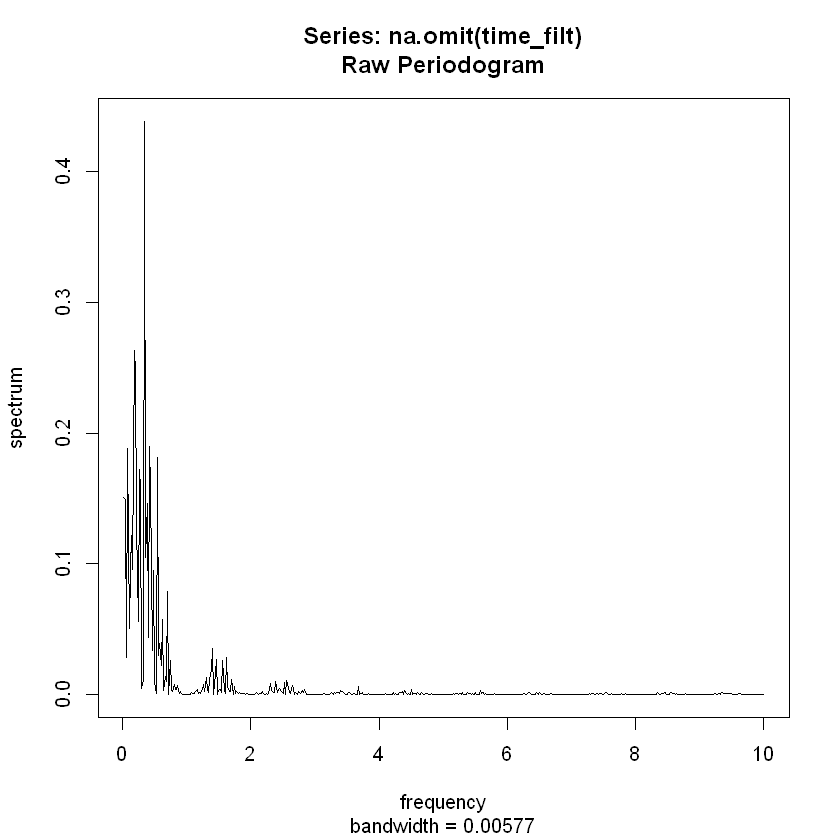

In [25]:
spec.pgram(na.omit(time_filt), log = 'no', taper = 0)

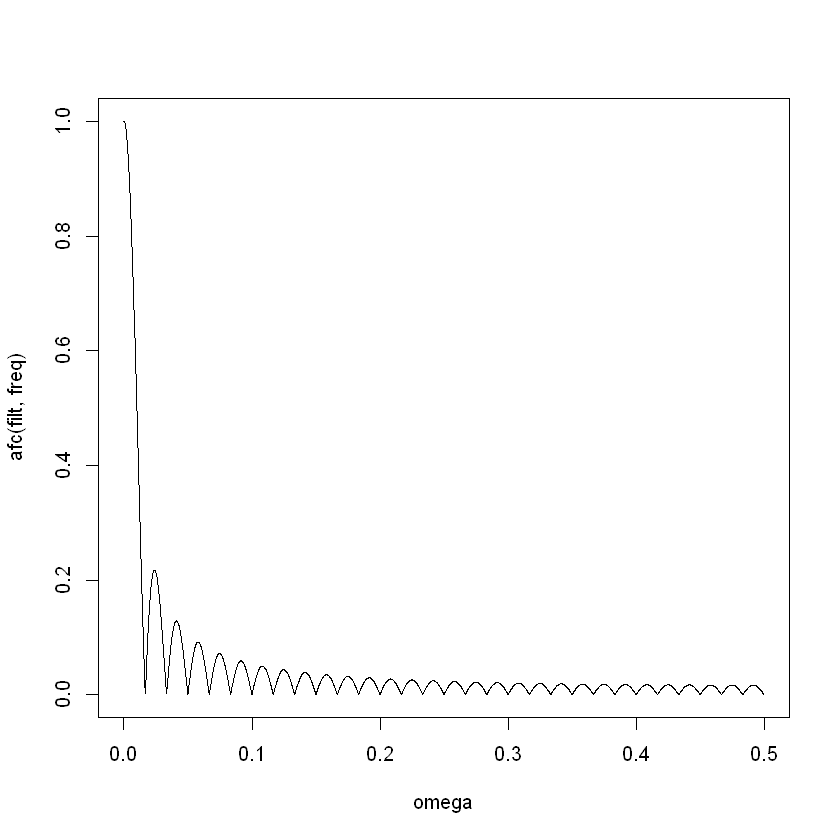

In [26]:
filt <- rep(1/60, 60)
plot(afc(filt, freq) ~ omega, type = 'l')

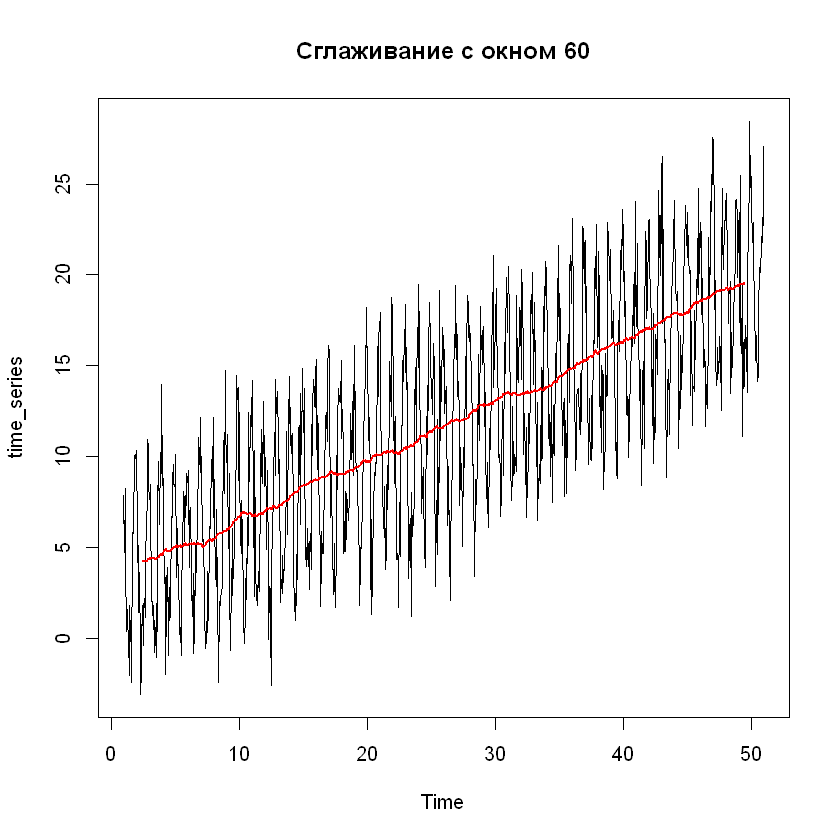

In [27]:
plot(time_series, main = "Сглаживание с окном 60")
time_filt <- filtered(time_series, filt)
lines(time_filt, col = "red", lwd = 1.7)

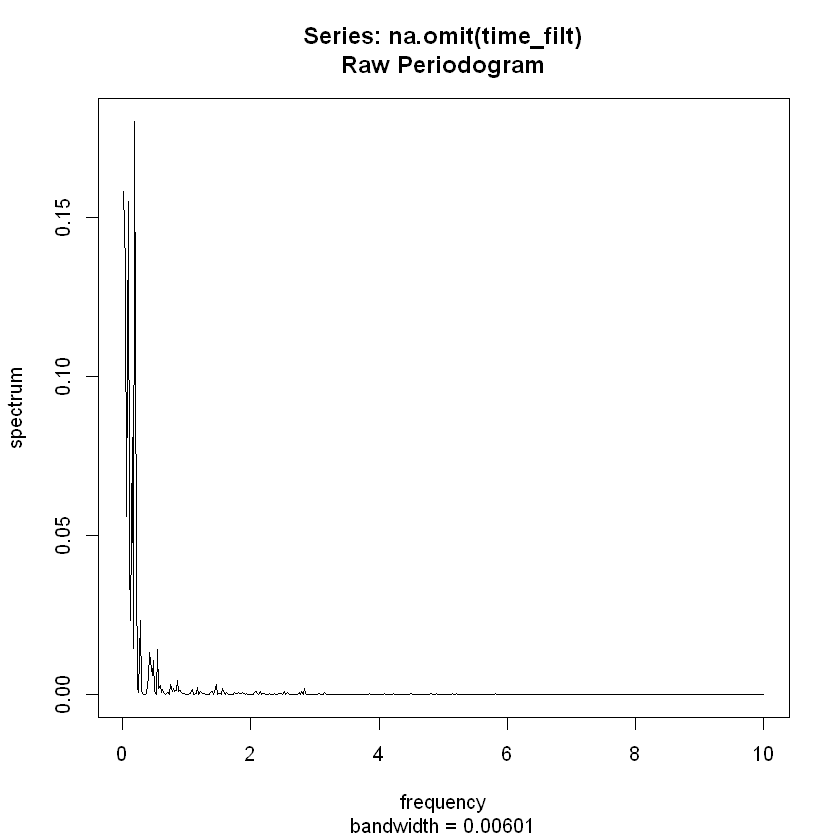

In [28]:
spec.pgram(na.omit(time_filt), log = 'no', taper = 0)

Чем больше длина окна, тем сильнее сглаживаем. Это видно и на графике ряда и на периодограмме: при длине окна $60$ дают вклад только совсем низкие частоты.

Теперь рассмотрим ряд без периодической компоненты: $X_n = T_n + \epsilon_n$.

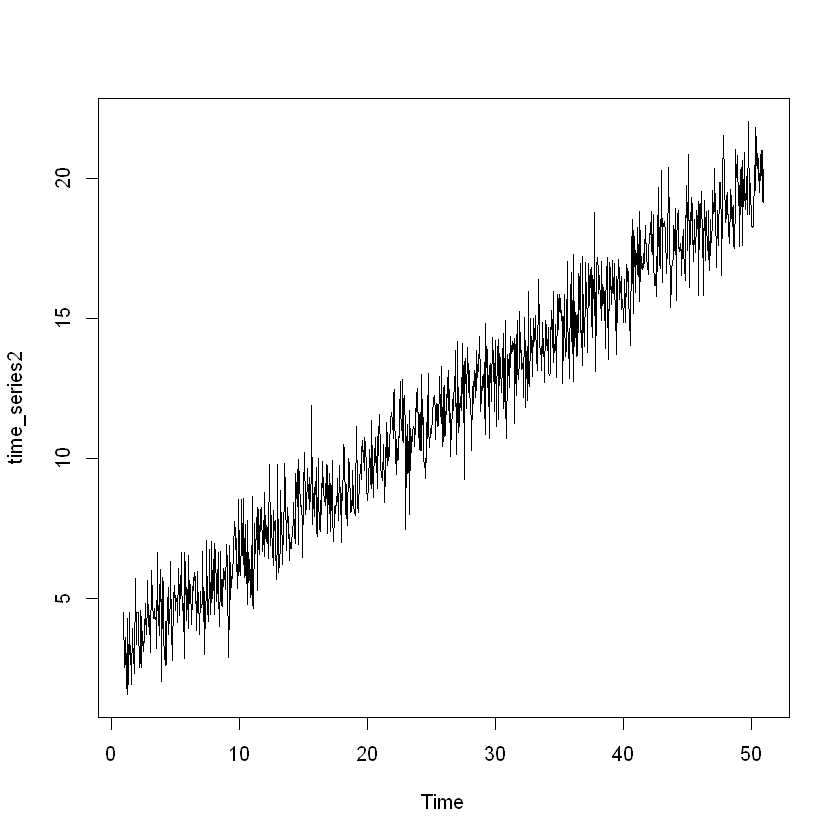

In [29]:
white_noise2 <- ts(rnorm(N, 0, 1), frequency = 20)
time_series2 <- time_trend + white_noise2
plot(time_series2)

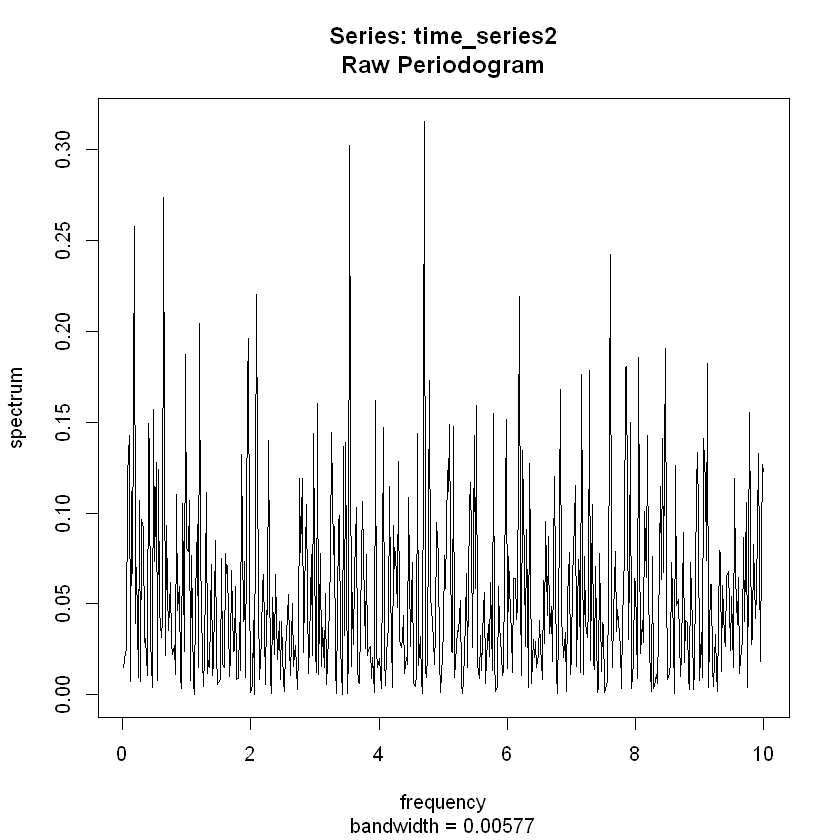

In [30]:
spec.pgram(time_series2, log = 'no', taper = 0)

Воспользуемся фильтром перехода к разностям и удалим с помощью него линейный тренд. 

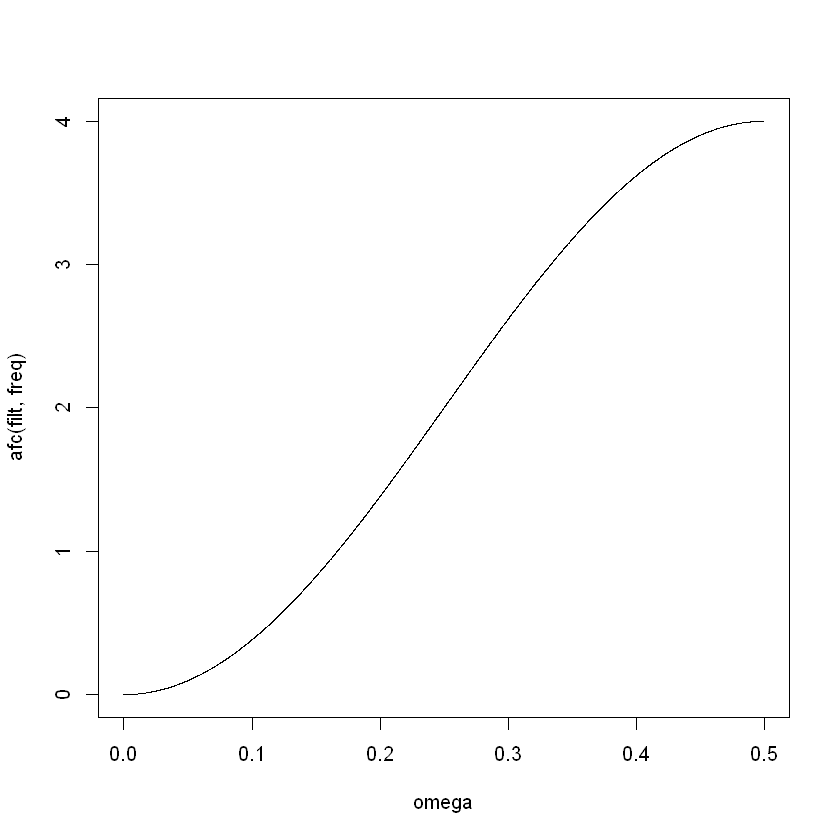

In [31]:
filt <- c(-1, 2, -1)
plot(afc(filt, freq) ~ omega, type = 'l')

Из графика видим, что применение фильтра приведет к удалению тренда и усилит высокие частоты. 

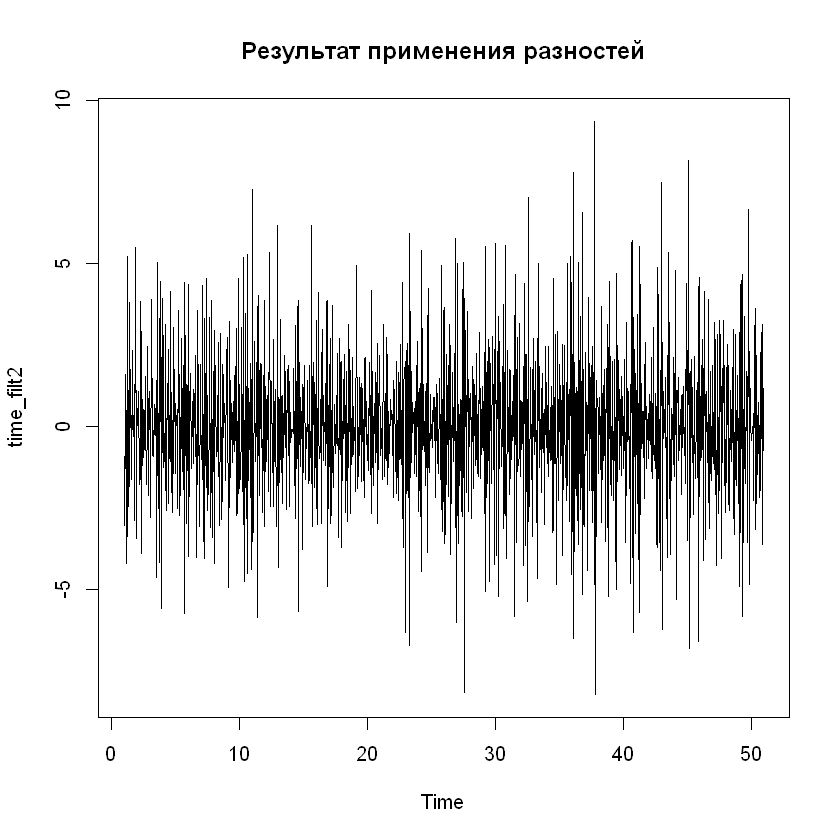

In [32]:
time_filt2 <- filtered(time_series2, filt)
plot(time_filt2, main = "Результат применения разностей")

Помимо удаления тренда произошло усиление шума.   
Применим фильтры к реальным данным.

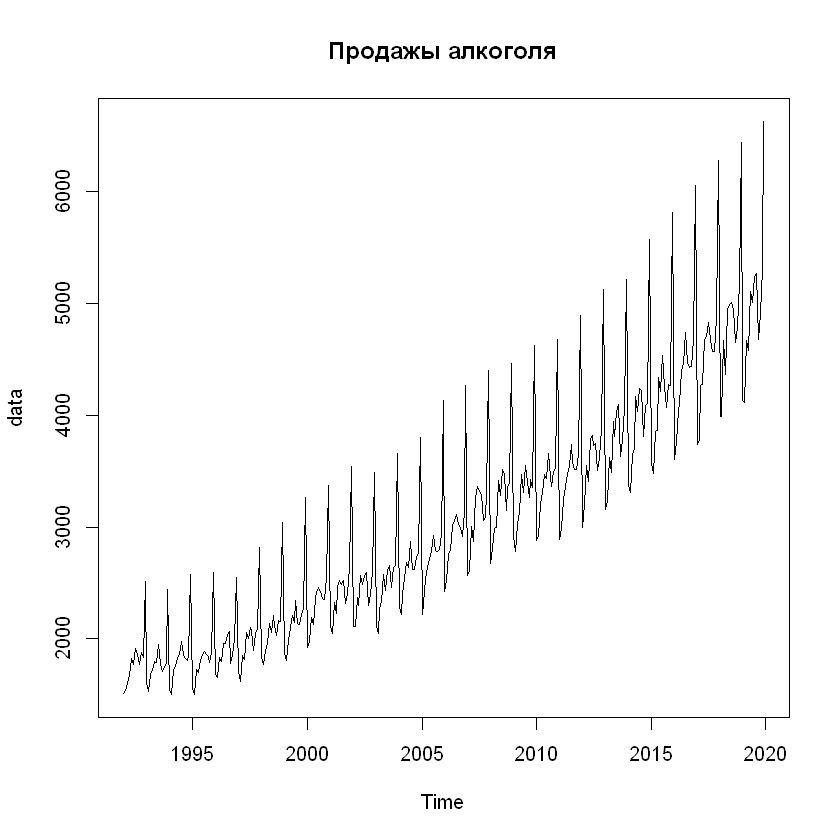

In [33]:
data <- read.table('series.csv', sep=',', header=T, row.names = 1)
N <- 348
data <- ts(data, start = c(1992, 1), end = c(2019, 12), frequency = 12)
plot(data, main = 'Продажы алкоголя')

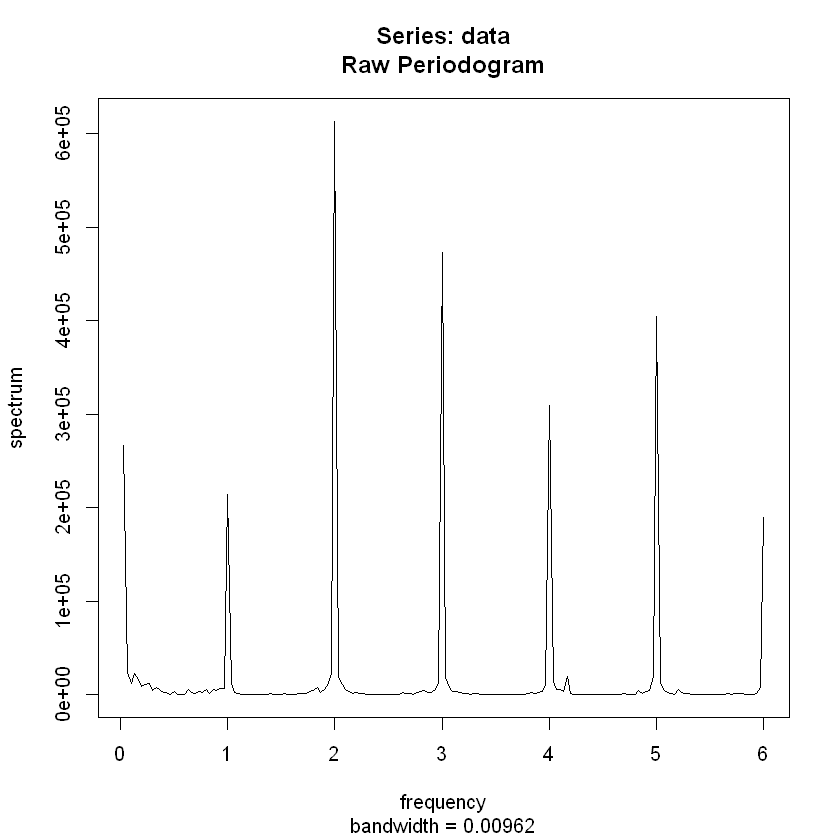

In [34]:
spec.pgram(data, log='no', taper = 0)

Хотим сгладить тренд, для того чтобы избавиться от периодической компоненты, нужно применить фильтр с длинной окна кратной $12$.

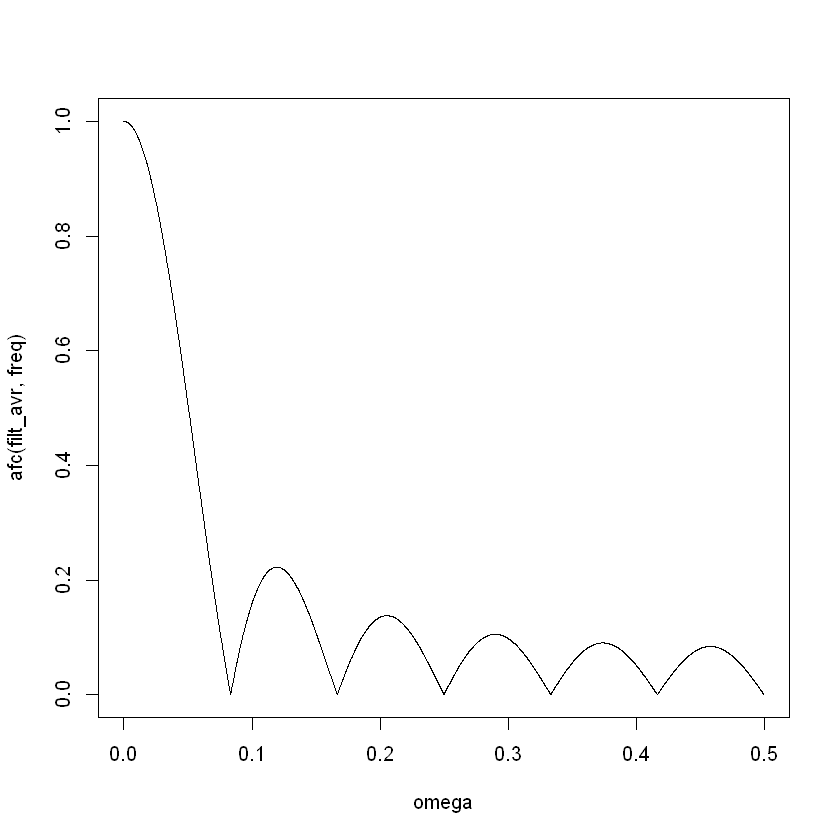

In [35]:
filt_avr <- rep(1/12, 12)
plot(afc(filt_avr, freq) ~ omega, type = 'l')

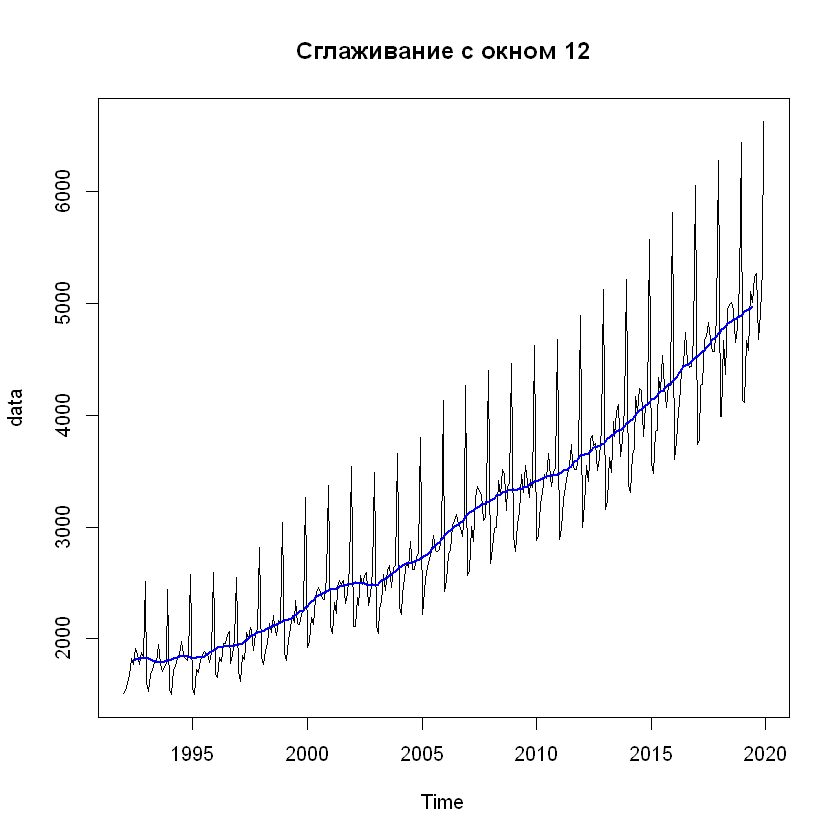

In [36]:
plot(data, main = "Сглаживание с окном 12")
data_avr <- filtered(data, filt_avr)
lines(data_avr, col = "blue", lwd = 1.7)

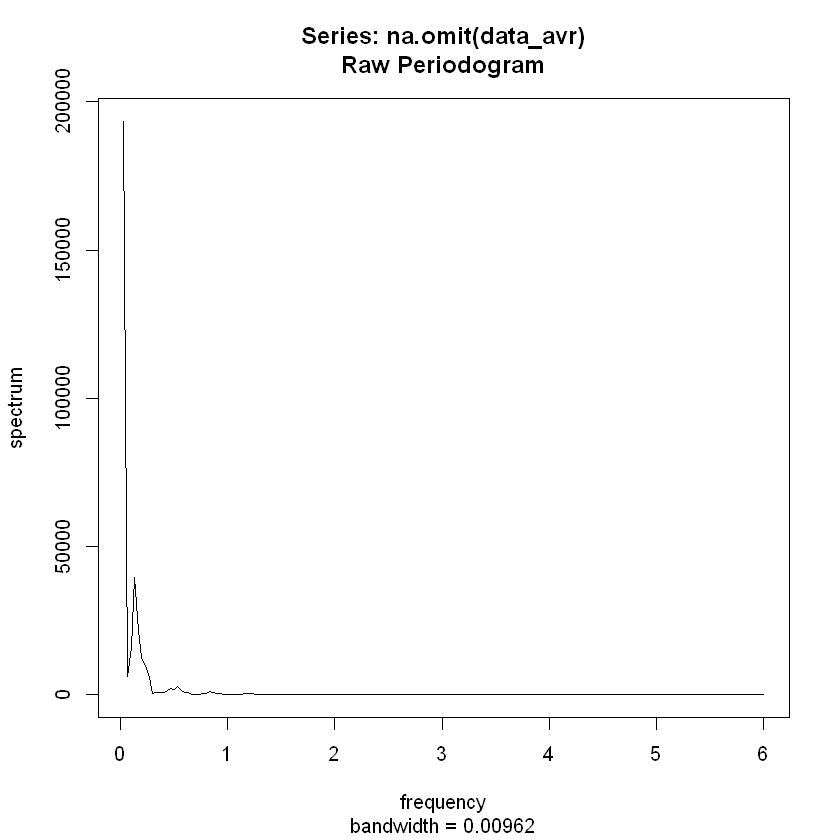

In [37]:
spec.pgram(na.omit(data_avr), log='no', taper = 0)

На периодограмме нет пиков сезонности, значит фильтр действительно убрал периодичность. Возможно, тренд при выделении смешался с другой компонентой, так как на графике есть маленький вклад низких частот. Применим фильтр с длинной окна побольше. 

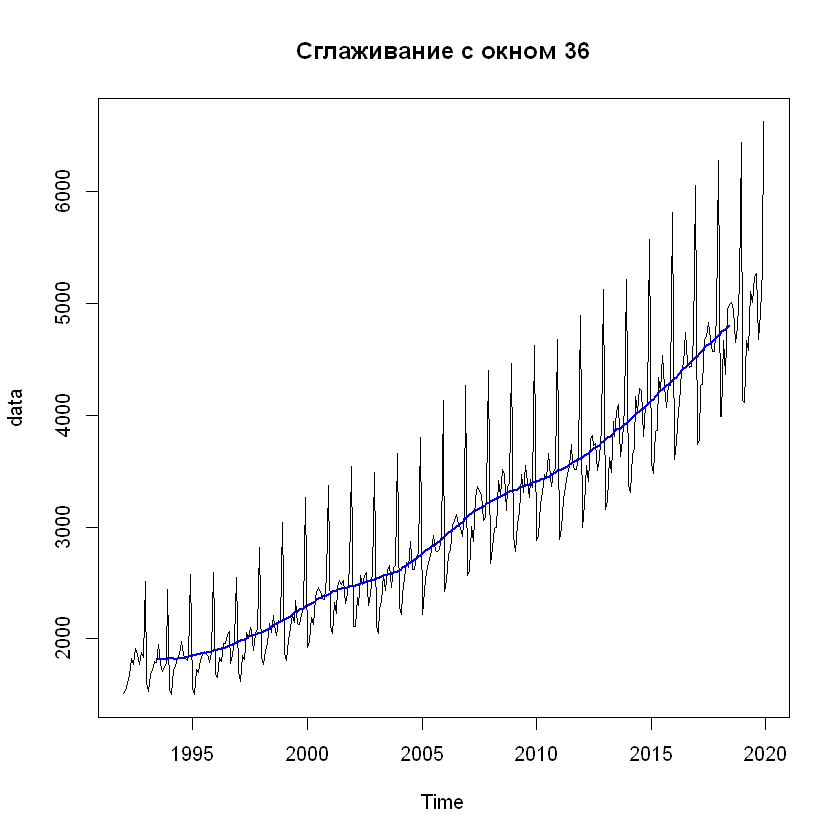

In [38]:
filt_avr <- rep(1/36, 36)
plot(data, main = "Сглаживание с окном 36")
data_avr <- filtered(data, filt_avr)
lines(data_avr, col = "blue", lwd = 1.7)

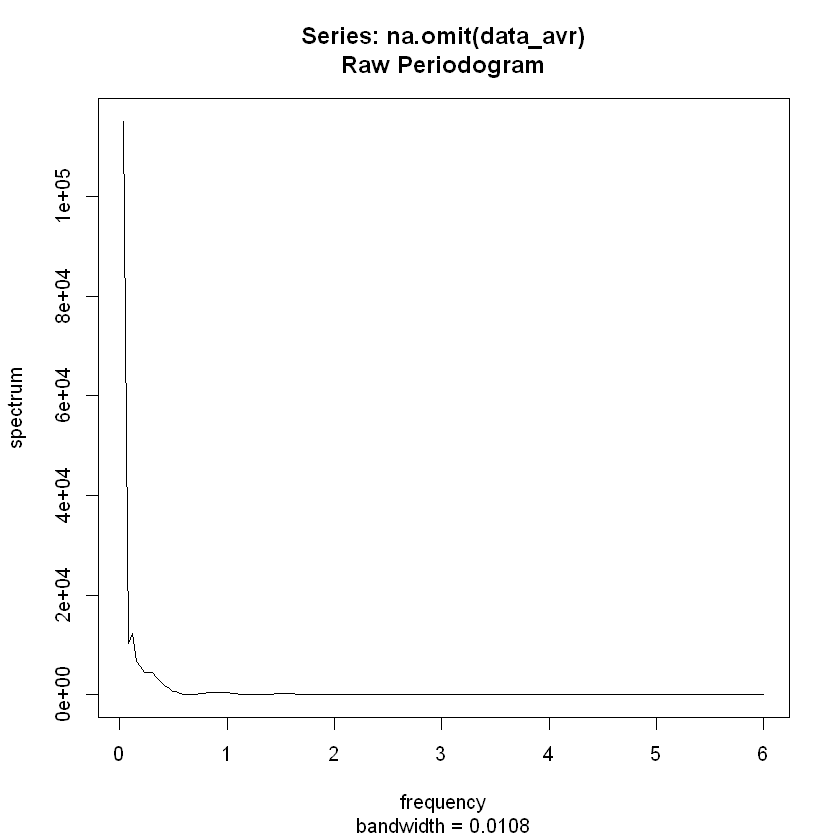

In [39]:
spec.pgram(na.omit(data_avr), log='no', taper = 0)

Теперь попробуем удалить тренд с помощью перехода к разностям. 

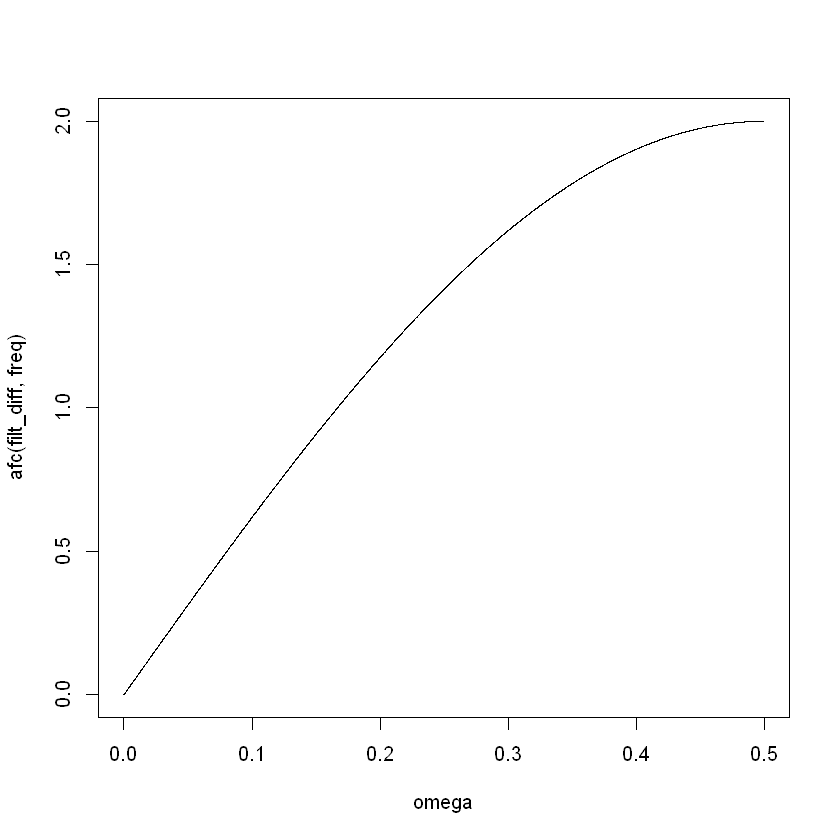

In [40]:
filt_diff <- c(-1, 1)
plot(afc(filt_diff, freq) ~ omega, type = 'l')

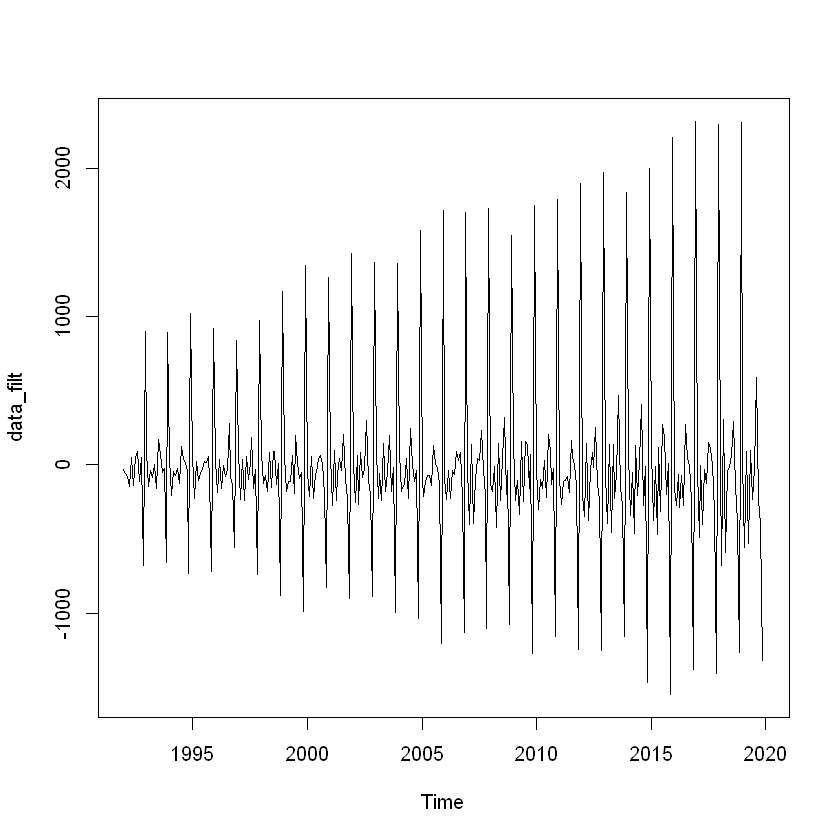

In [41]:
data_filt <- filtered(data, filt_diff)
plot(data_filt)

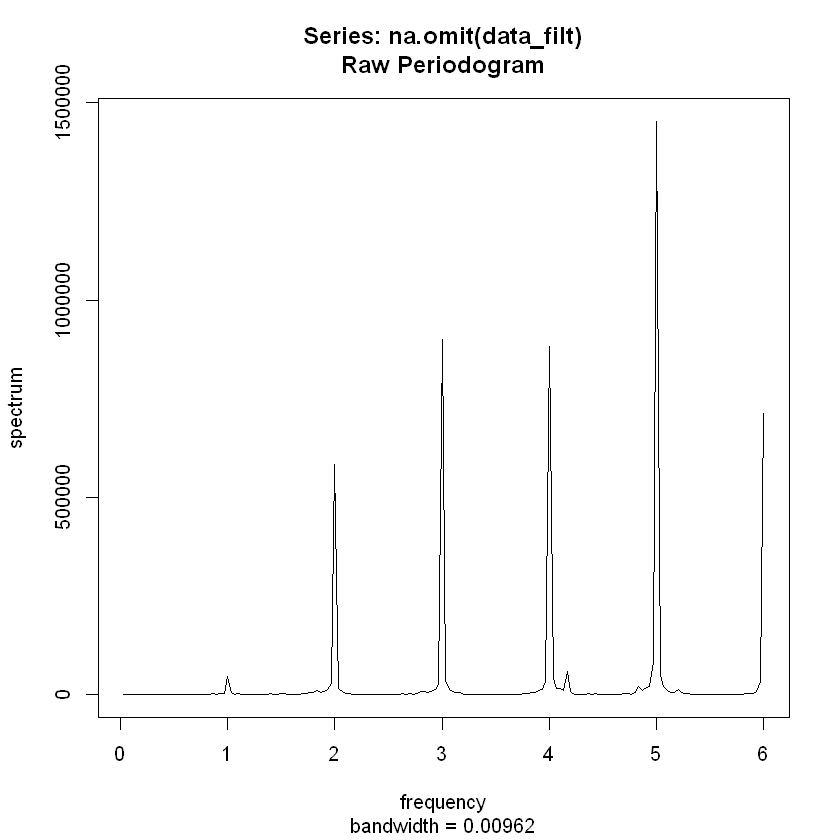

In [42]:
spec.pgram(na.omit(data_filt), log = 'no', taper = 0)

Периодограмма подтверждает удаление тренда.

# Выделение тренда

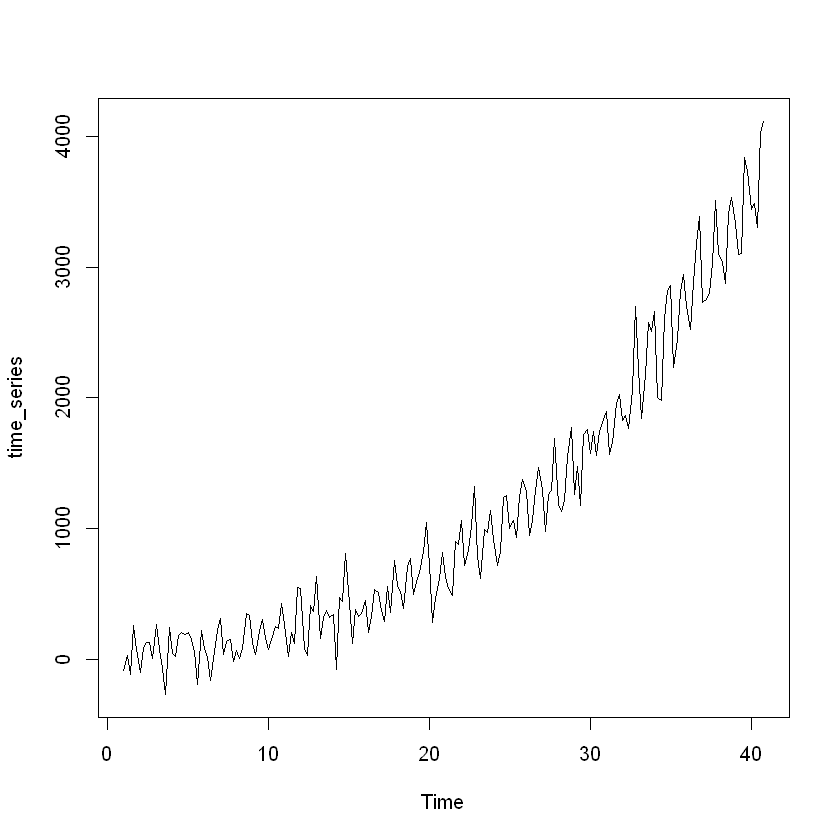

In [43]:
set.seed(1)
N <- 200
n <- 1:N
phi <- 0.3
omega_per <- 40/N

white_noise <- rnorm(N, 0, 30)*5
time_priod <- 2*n*cos(2*pi*omega_per*n + phi)
time_trend <- 0.0004*n^3 - 0.0002*n^2+3*n 
time_series <- ts(time_trend +time_priod +  white_noise, frequency = 5)
plot(time_series)

Ряду соответсвует $6$ компонент, $2$ из них относятся к $\cos$, остальные к полиному.   
Выделим тренд скользящим средним.

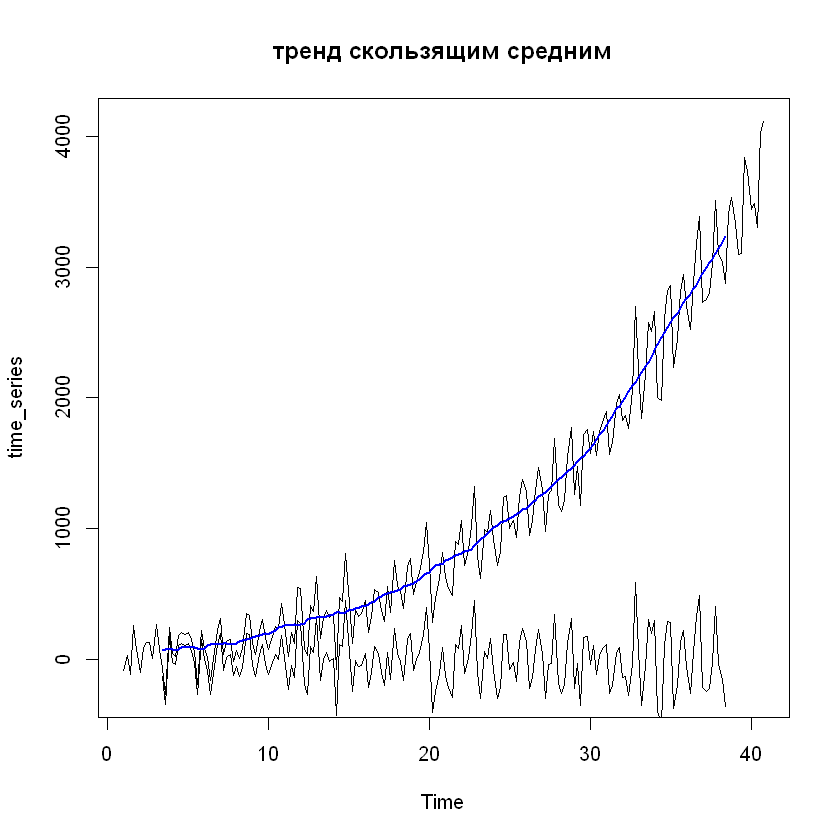

In [44]:
filt_avr <- rep(1/25, 25)
data_avr <- filtered(time_series, filt_avr)
ost1 <- time_series - data_avr
plot(time_series, main = "тренд скользящим средним")
lines(ost1)
lines(data_avr, col = "blue", lwd = 1.7)

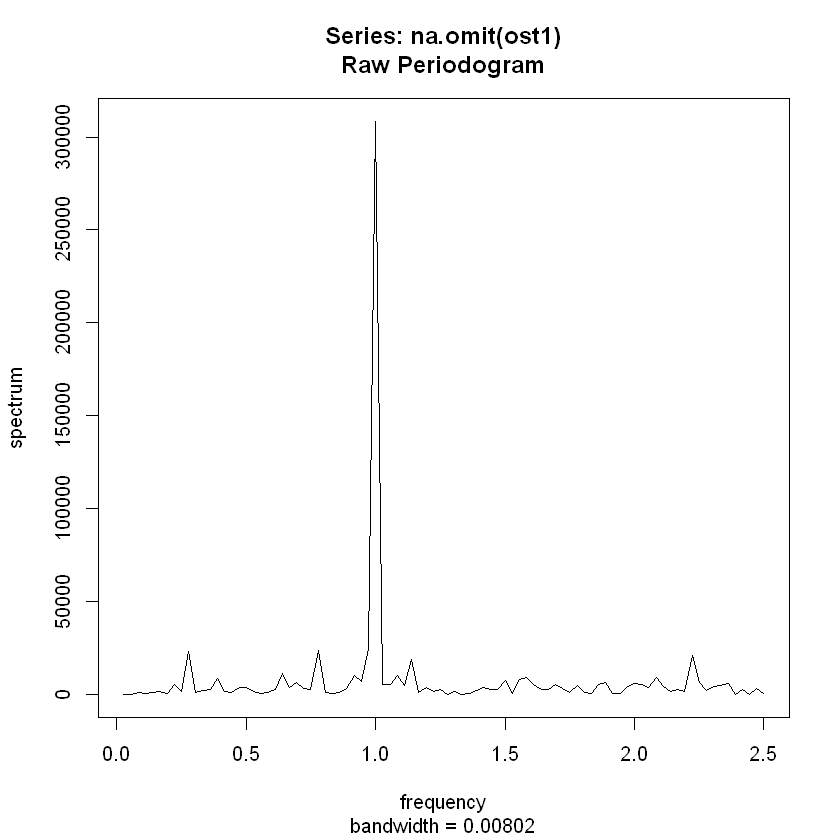

In [45]:
spec.pgram(na.omit(ost1), log = 'no', taper = 0)

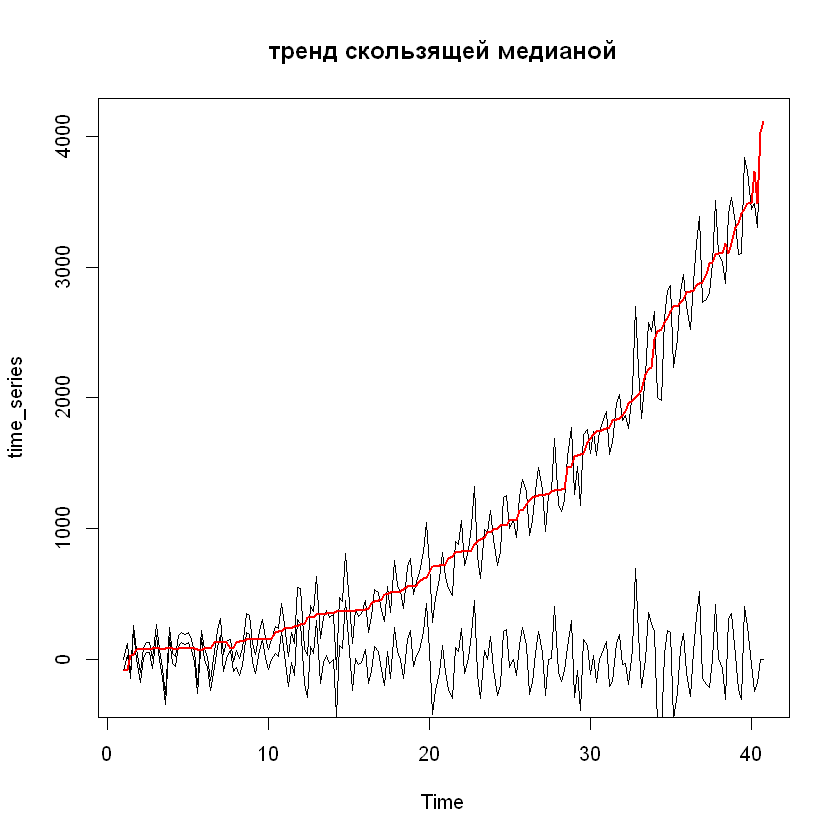

In [46]:
rmts <- ts(runmed(time_series, 25), frequency = 5)
plot(time_series, main = "тренд скользящей медианой")
ost2 <- time_series - rmts
lines(ost2)
lines(rmts, col = "red", lwd = 1.7)

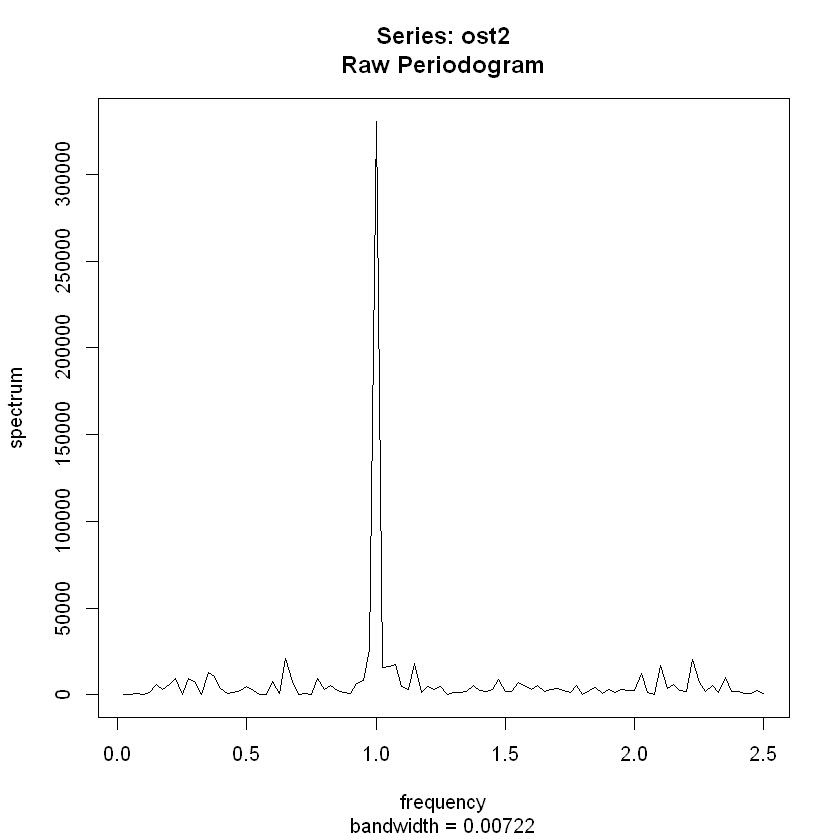

In [47]:
spec.pgram(ost2, log = 'no', taper = 0)

Для полиномиальной регрессии параметр span отвечает за степень сглаживания, а degree за степень полинома.

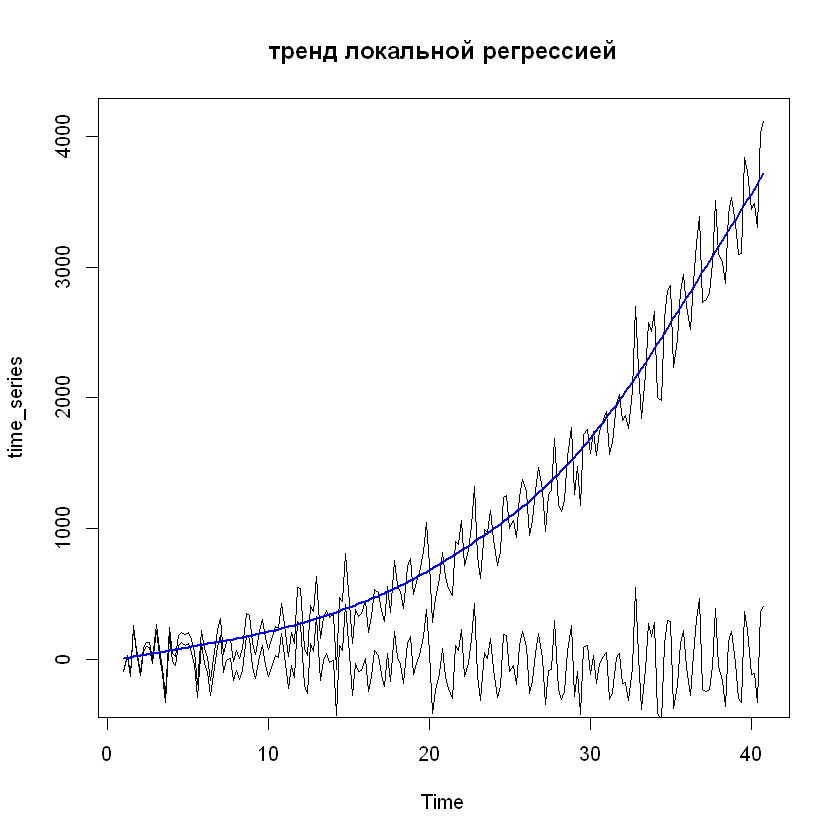

In [48]:
loess_ts <- ts(predict(loess(as.vector(time_series) ~ n, span = 0.4,
                             degree = 1), n), frequency = 5)
ost3 <- time_series - loess_ts
plot(time_series, main = "тренд локальной регрессией")
lines(ost3)
lines(loess_ts, col = "blue", lwd = 1.7)

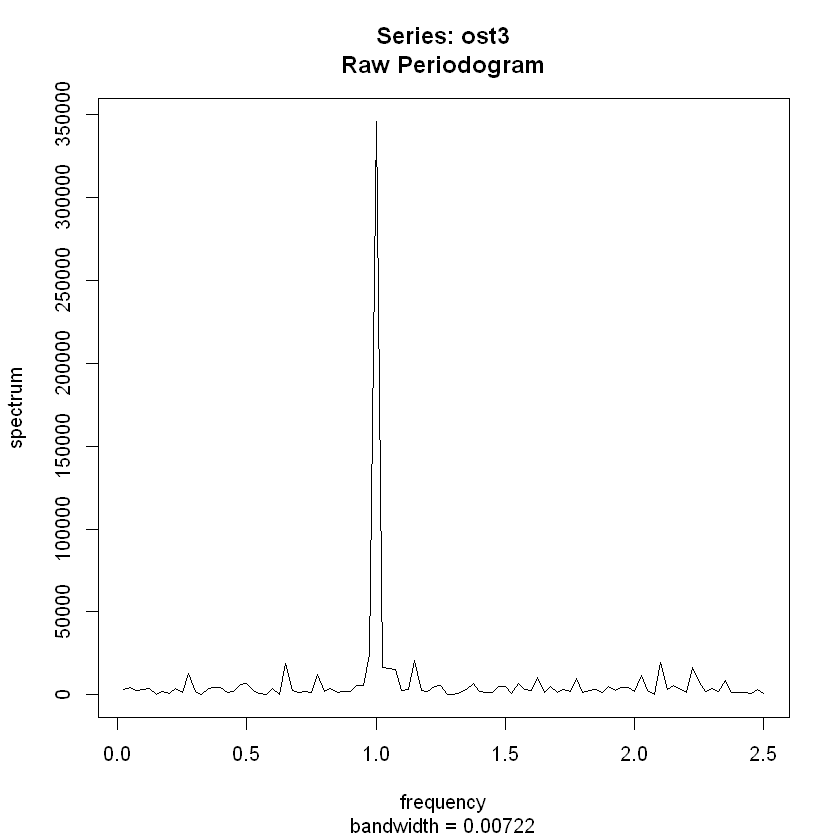

In [49]:
spec.pgram(ost3, log = 'no', taper = 0)

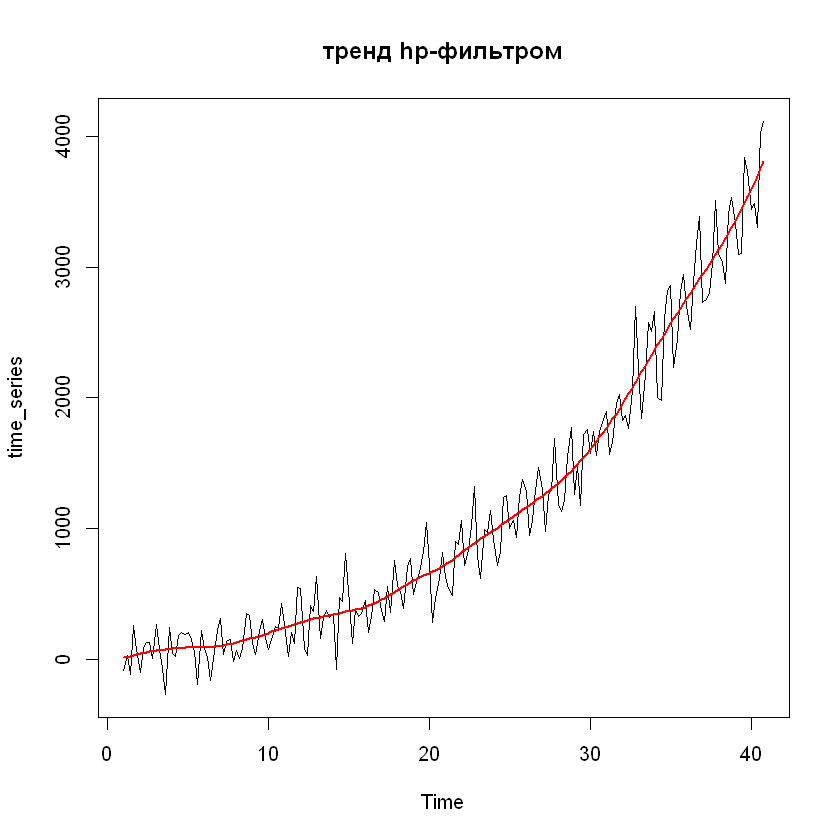

In [50]:
plot(time_series, main = "тренд hp-фильтром")
hp <- hpfilter(time_series, freq = 1000)$trend
ost4 <- time_series - hp
lines(hp, col = "red", lwd = 1.7)

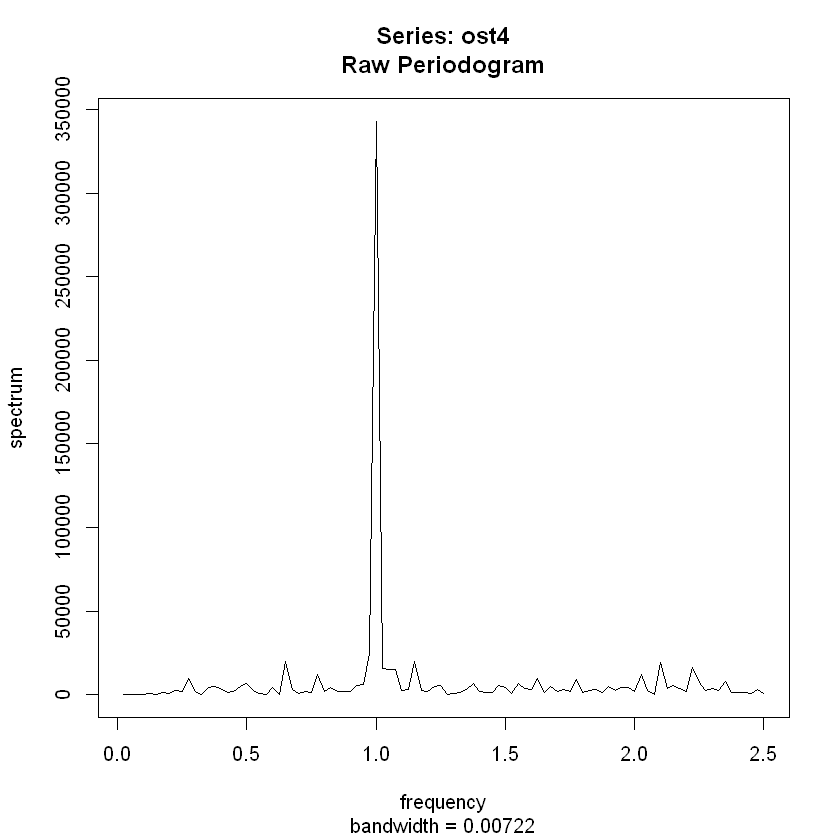

In [51]:
spec.pgram(ost4, log = 'no', taper = 0)

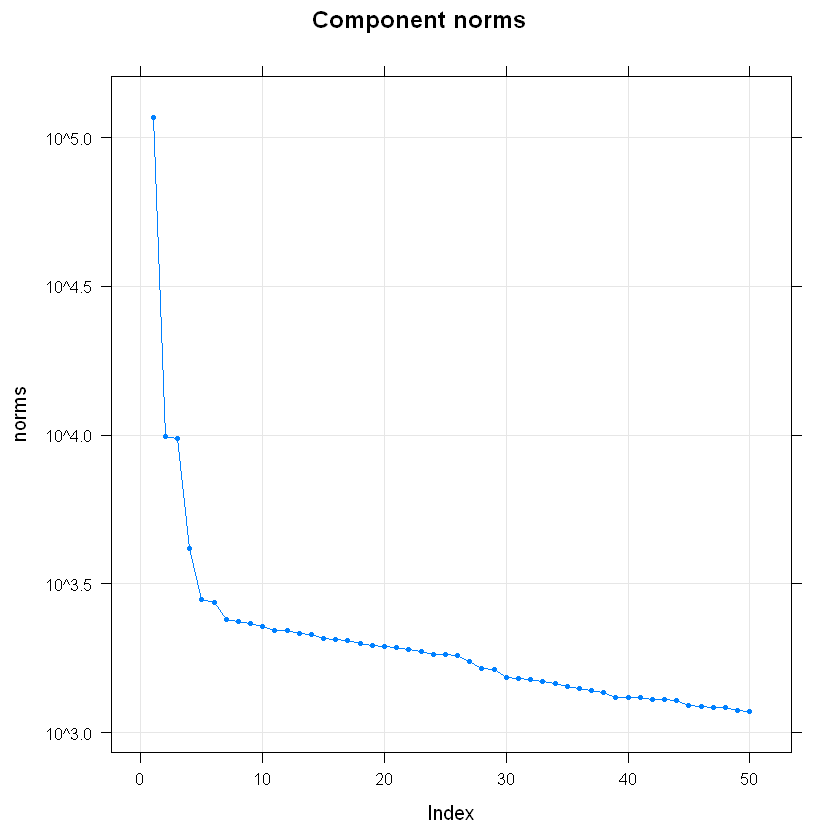

In [52]:
s <- ssa(time_series, L = 96)
plot(s)

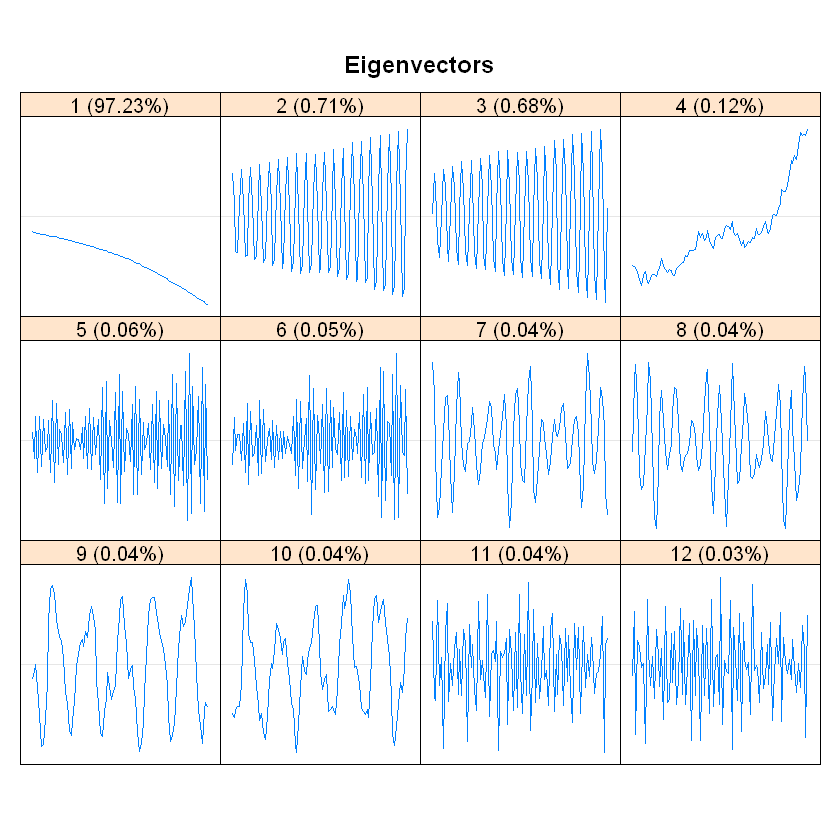

In [53]:
plot(s, type = "vectors", idx = 1:12)

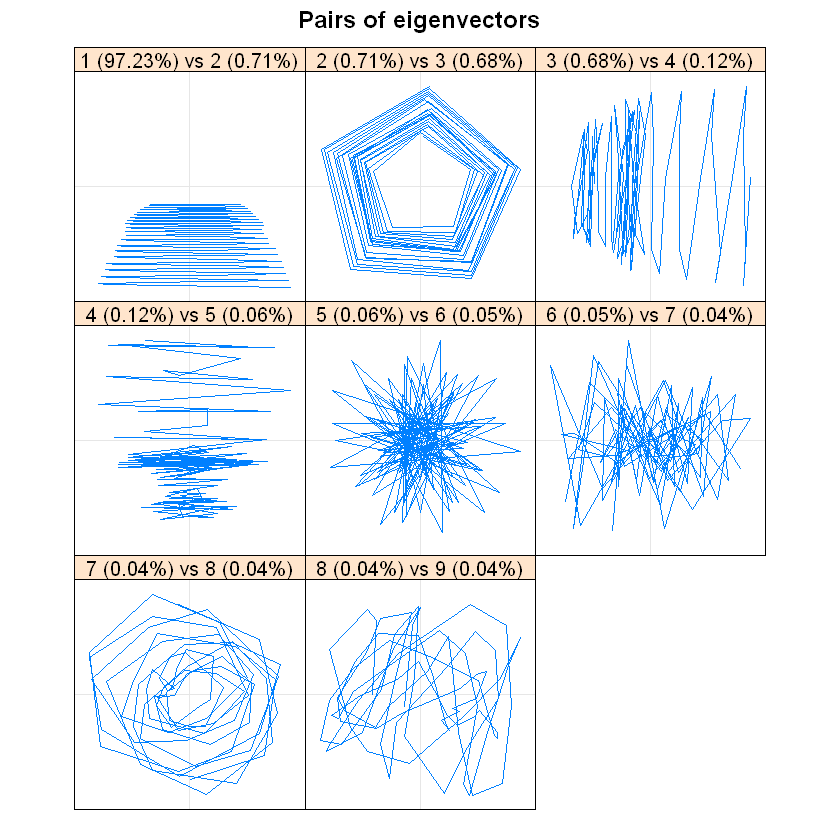

In [54]:
plot(s, type = "paired", idx = 1:8)

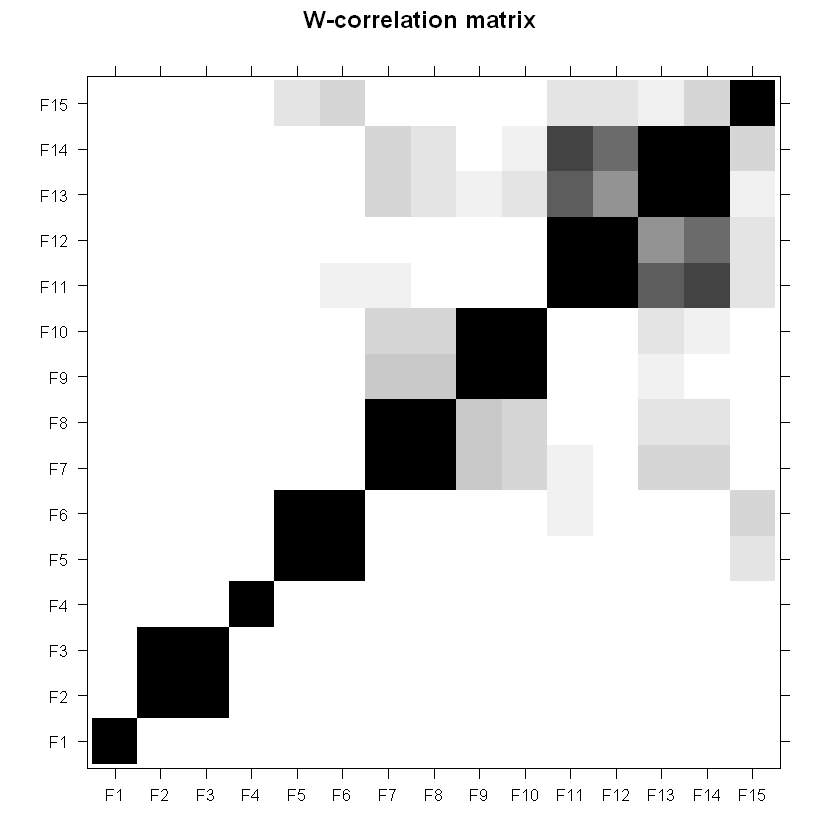

In [55]:
plot(wcor(s, groups = 1:15))

К тренду относим две компоненты. 

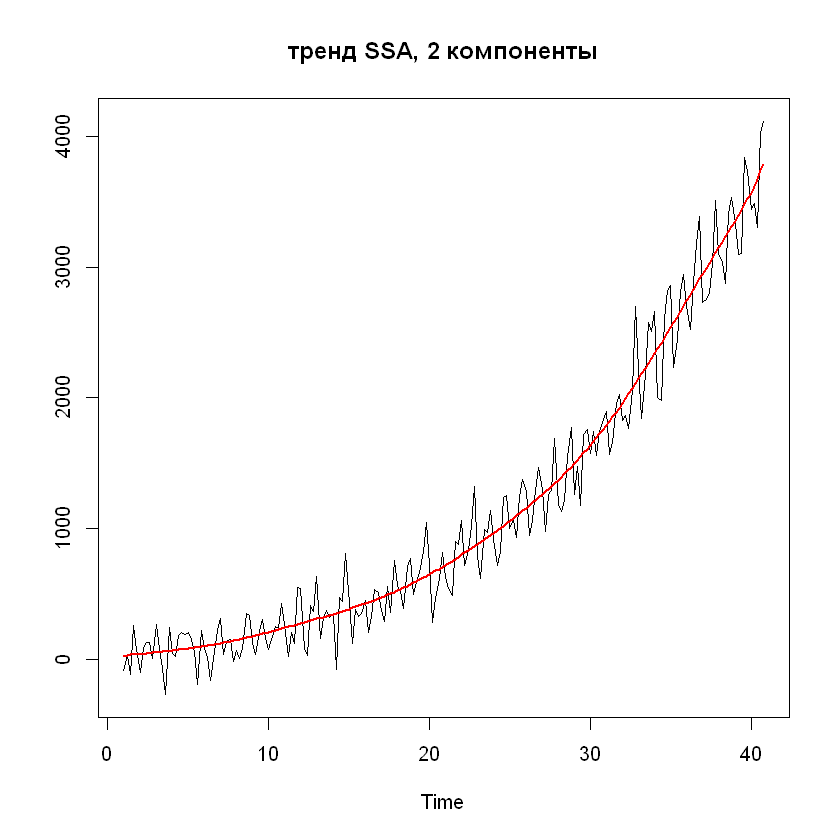

In [56]:
res <- reconstruct(s, groups = list(c(1, 4)))
plot(res, add.residuals = FALSE, plot.type = "single", col = c("black", "red"), lwd = c(1, 2), main = "тренд SSA, 2 компоненты")

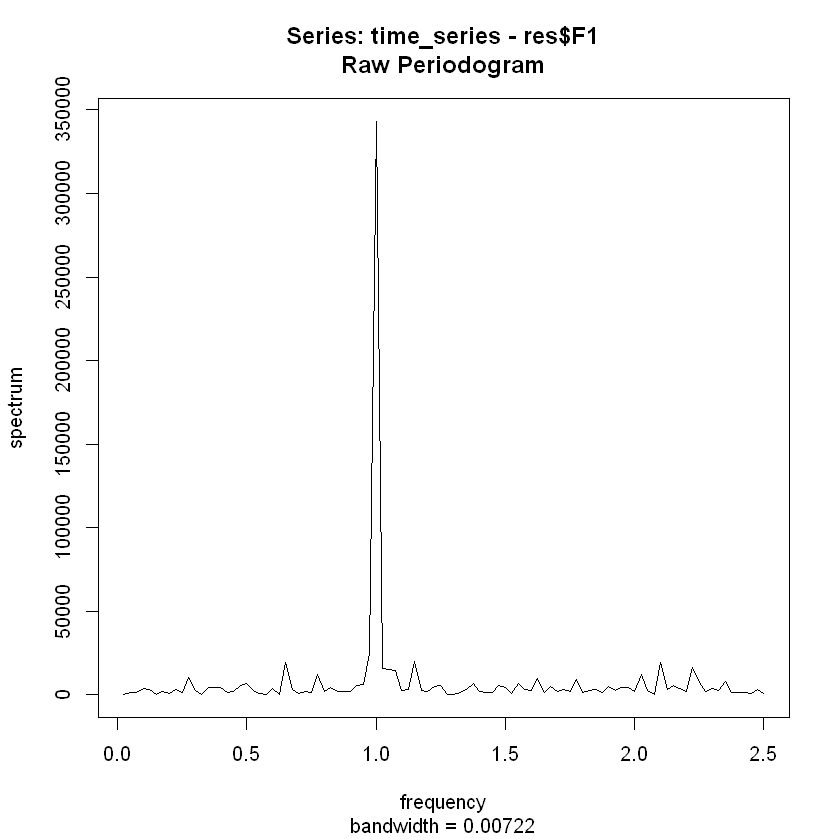

In [57]:
spec.pgram(time_series-res$F1, log = 'no', taper = 0)

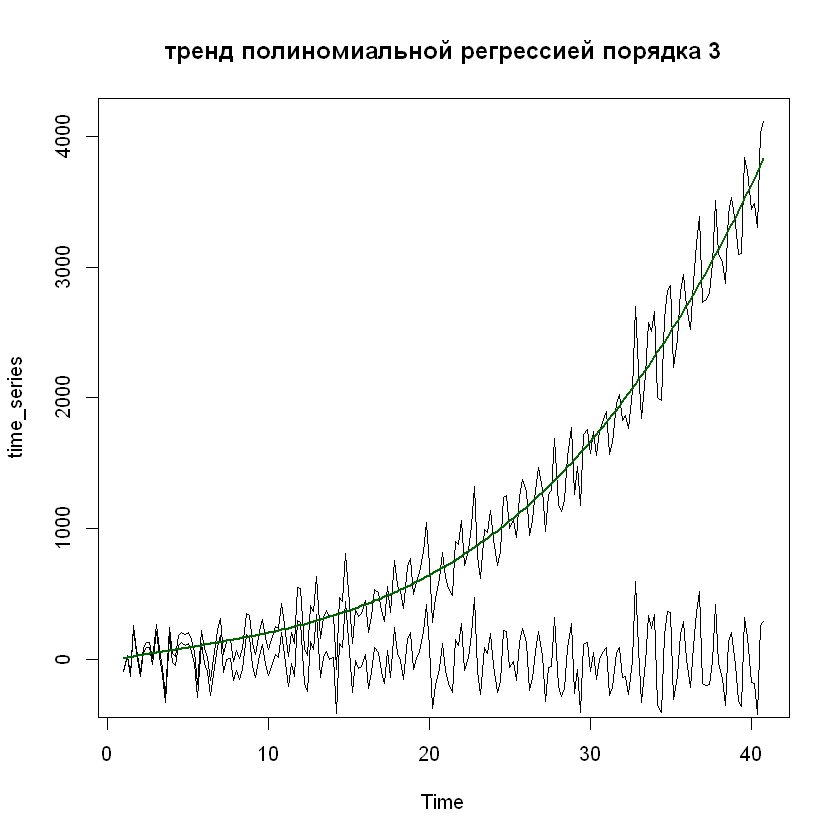

In [58]:
deg3 <- lm(as.vector(time_series) ~ poly(n, 3, raw = TRUE))
polinom3 <- ts(predict.lm(deg3, data.frame(n)), frequency = 5)

plot(time_series, main = "тренд полиномиальной регрессией порядка 3")
ost5 <- time_series-polinom3
lines(ost5)
lines(polinom3, col = "darkgreen", type = "l", lwd = 1.7)

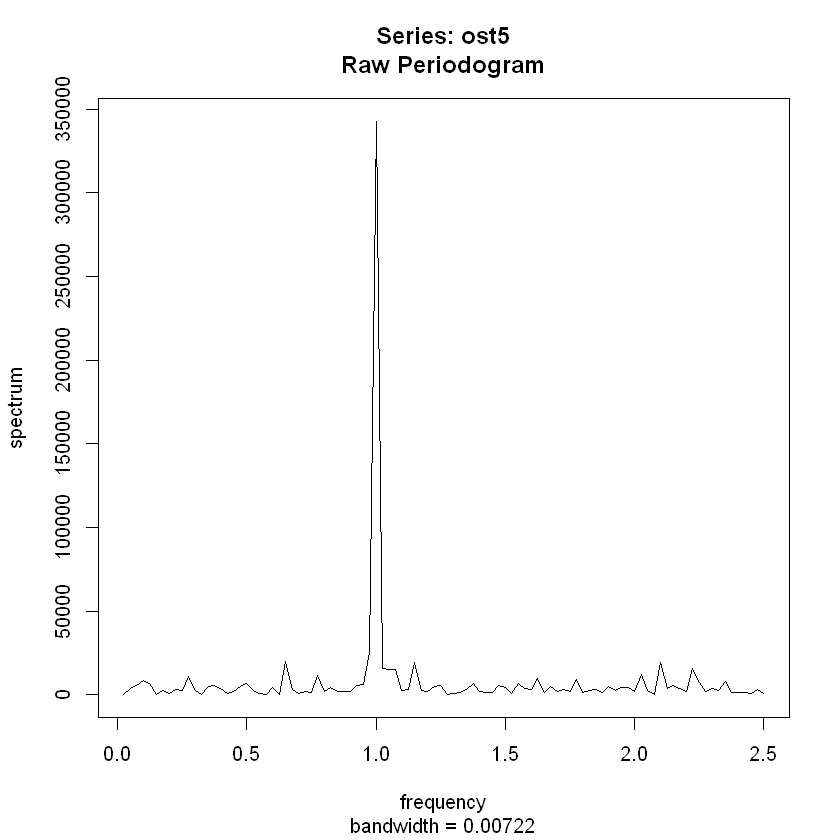

In [59]:
spec.pgram(ost5, log = 'no', taper = 0)

Периодограммы для всех остатков выглядет похожим образом. На каждой из них пристутсвует пик, соответствующий периоду $5$. Только скользящее среднее выделяет вместе с трендом шум (на периодограмме меньше больших частот).

## Реальные данные
Ряд, содержит данные о количестве работников, нанятых в сфере сельского хозяйства.

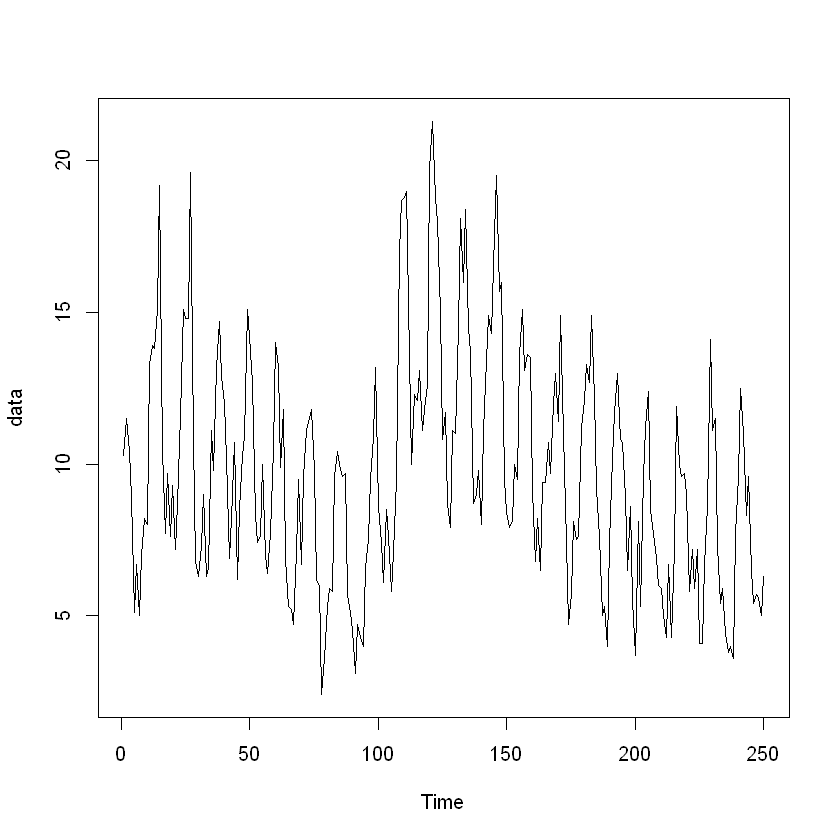

In [60]:
data <- read.table('LNU04035109.csv', sep=',', header=T, row.names = 1) 
data <- data[1:250,] 
data <- as.ts(data, start = c(2000, 1), frequency = 12)
plot(data)

Для разложения SSA, чтобы воспользоваться асимптотической разделимостью возьмем окно в примерно половину длины ряда $L = 120$. 

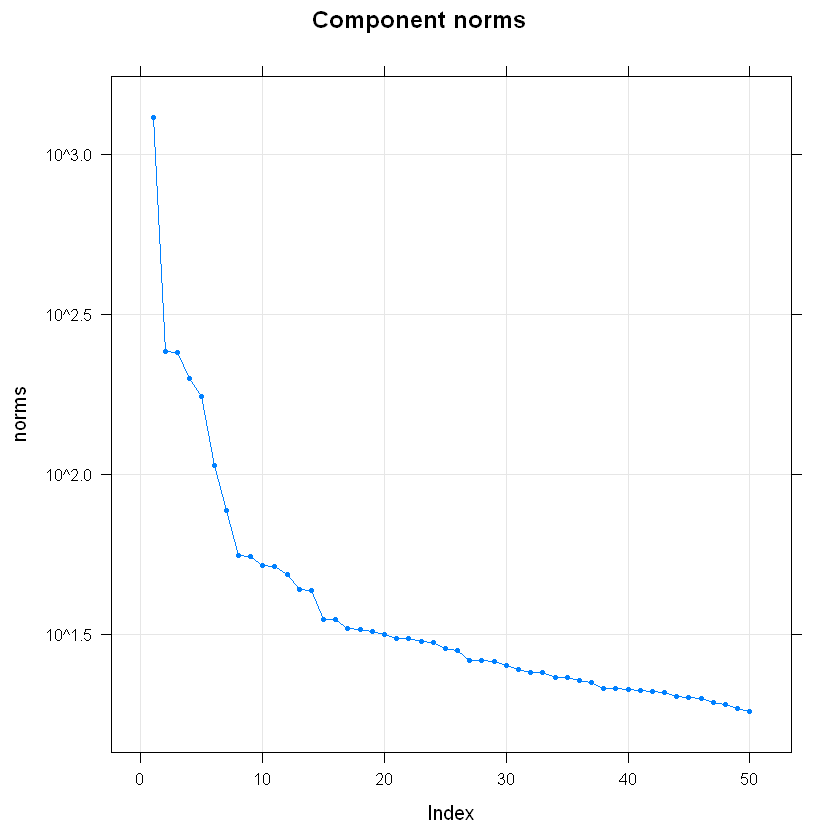

In [61]:
s <- ssa(data, L = 120)
plot(s)

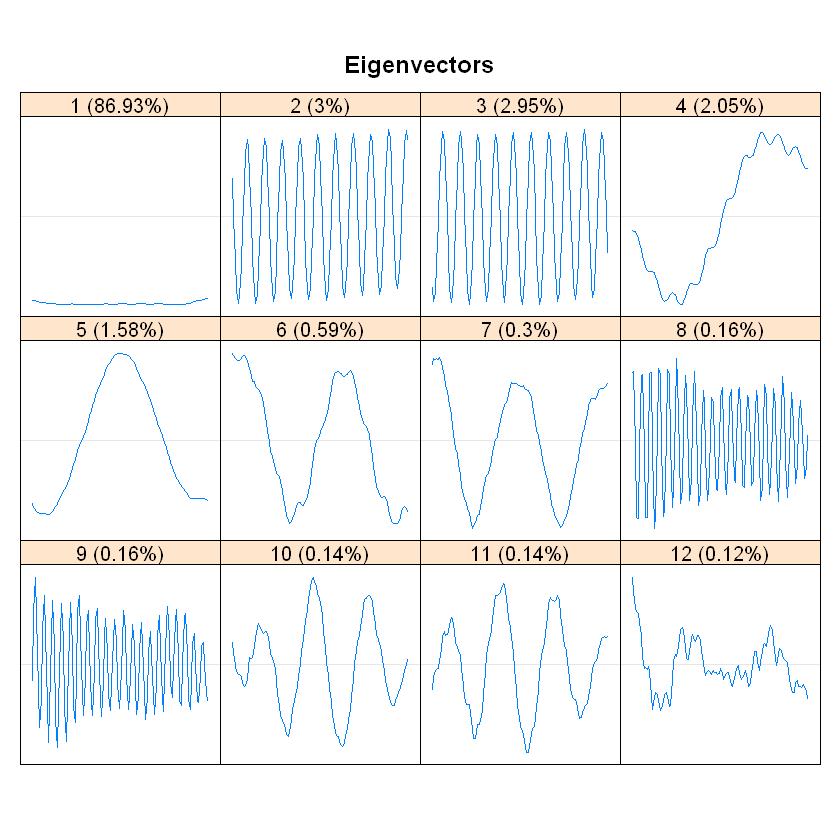

In [62]:
plot(s, type = "vectors", idx = 1:12)

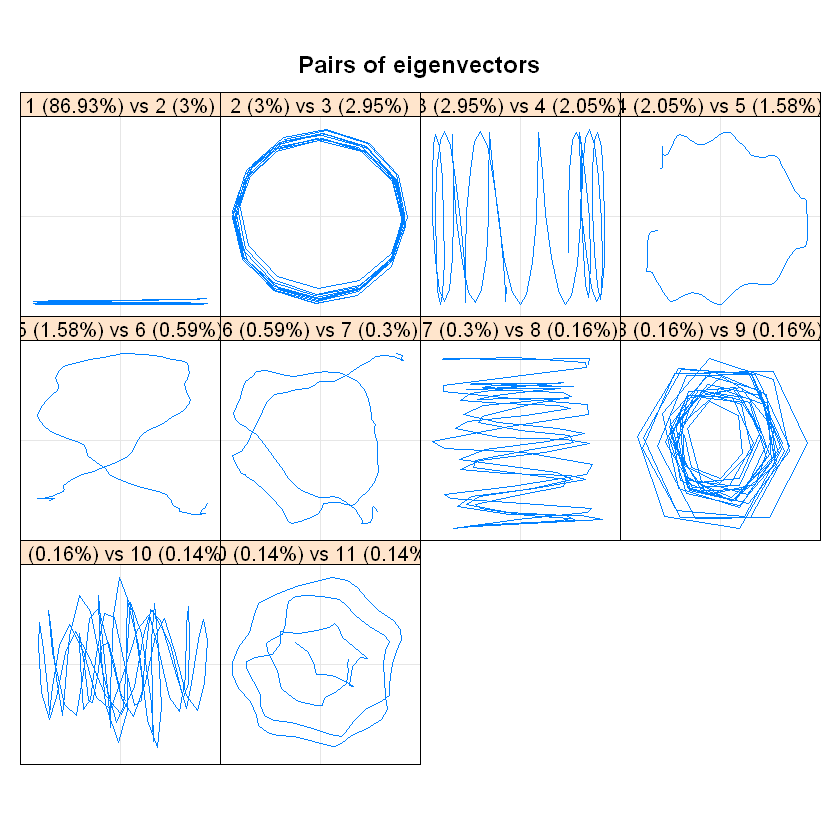

In [63]:
plot(s, type = "paired", idx = 1:10)

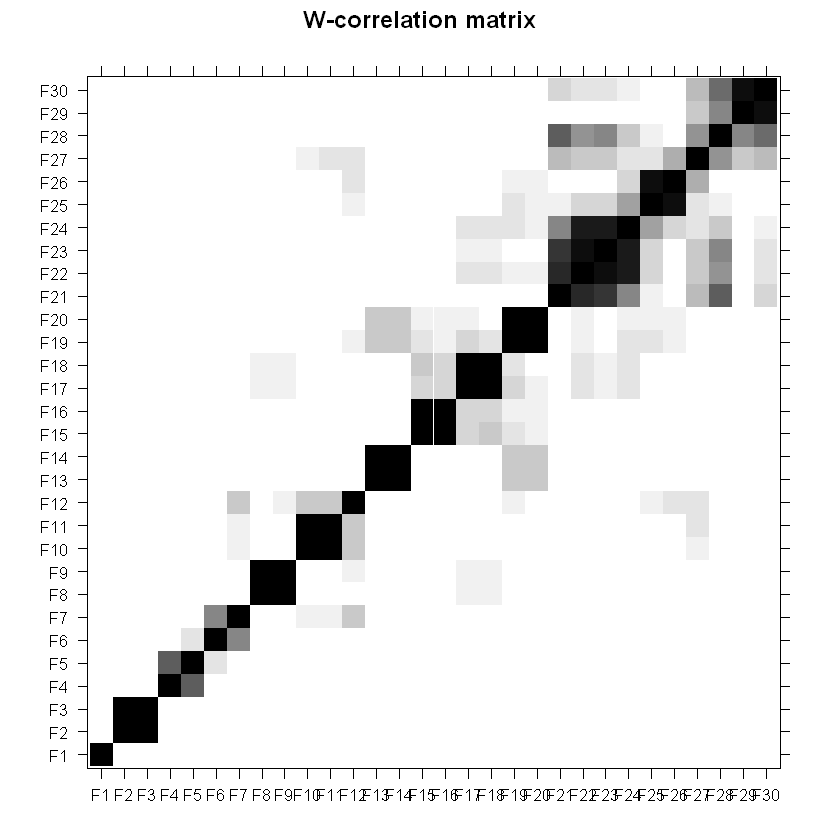

In [64]:
plot(wcor(s, groups = 1:30))

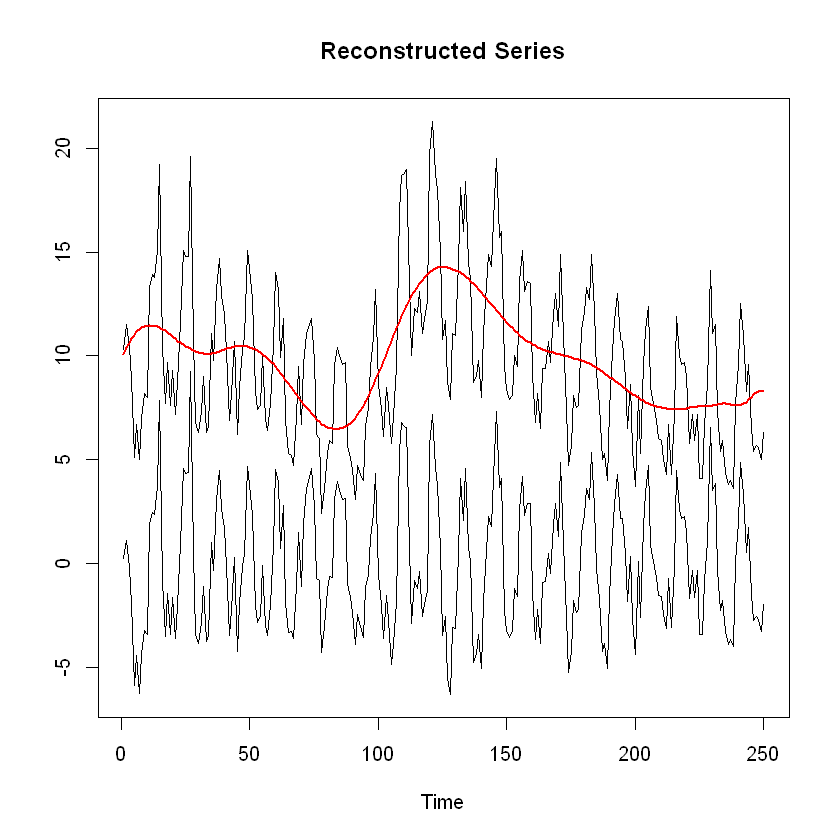

In [65]:
res <- reconstruct(s, groups = list(c(1, 4, 5, 6, 7)))
plot(res, add.residuals = TRUE, plot.type = "single", col = c("black", "red"), lwd = c(1, 2))

Скользящее среднее проделаем с окном кратным $12$ и достаточно большим для сглаживания.

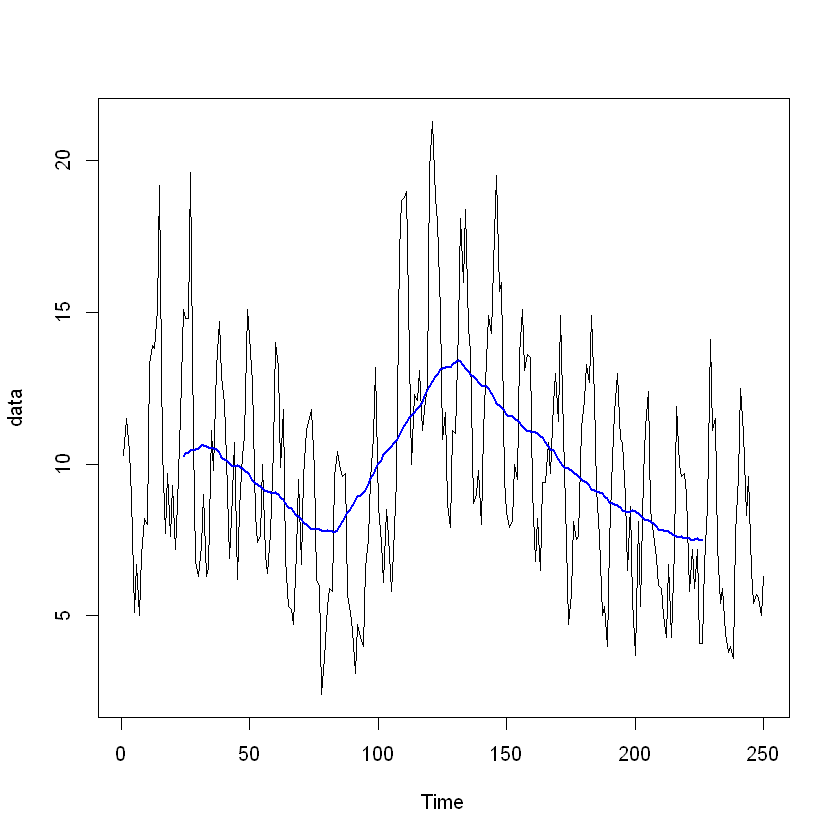

In [66]:
filt_avr <- rep(1/48, 48)
data_avr <- filtered(data, filt_avr)
plot(data)
lines(data_avr, col = "blue", lwd = 1.7)

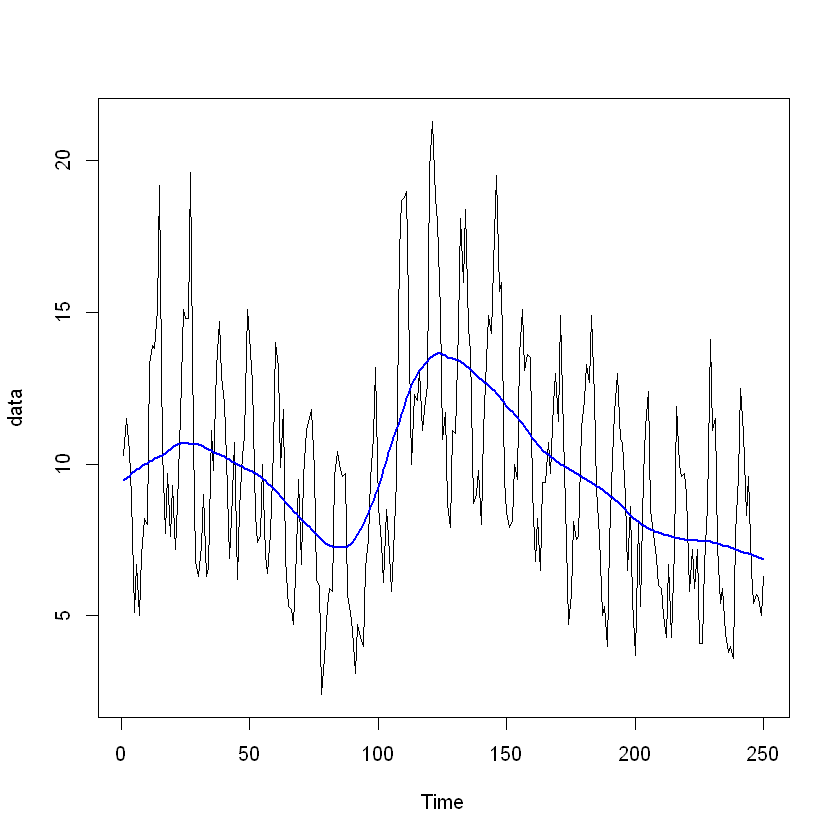

In [67]:
n <- 1:250
loess_ts <- predict(loess(data ~ n, span = 0.2, degree = 1), n)

plot(data)
lines(loess_ts, col = "blue", lwd = 1.7)

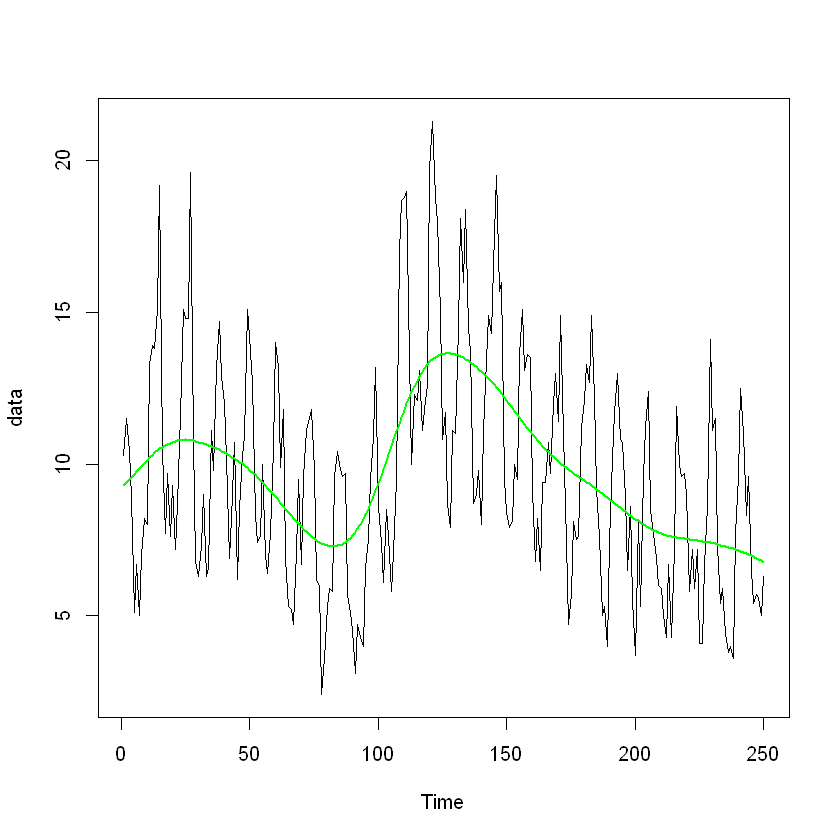

In [68]:
plot(data)
hp <- hpfilter(data, freq = 10000)$trend
lines(hp, col = "green", lwd = 1.7)

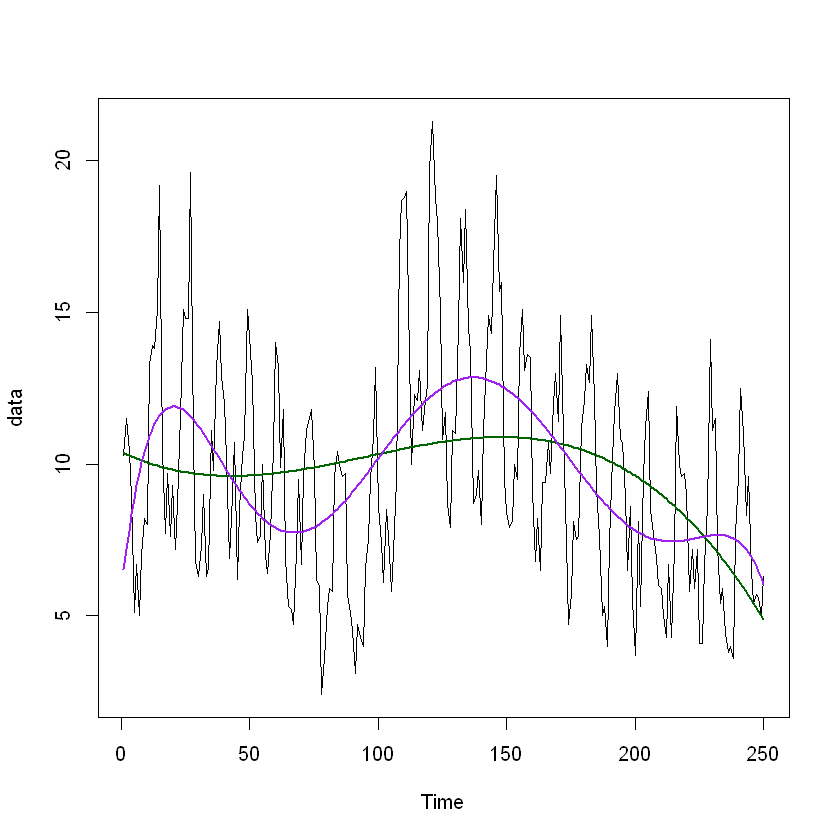

In [69]:
deg3 <- lm(data ~ poly(n, 3, raw = TRUE))
polinom3 <- predict.lm(deg3, data.frame(n))

deg6 <- lm(data ~ poly(n, 6, raw = TRUE))
polinom6 <- predict.lm(deg6, data.frame(n))

plot(data)
lines(polinom3, col = "darkgreen", type = "l", lwd = 1.7)
lines(polinom6, col = "purple", type = "l", lwd = 1.7)

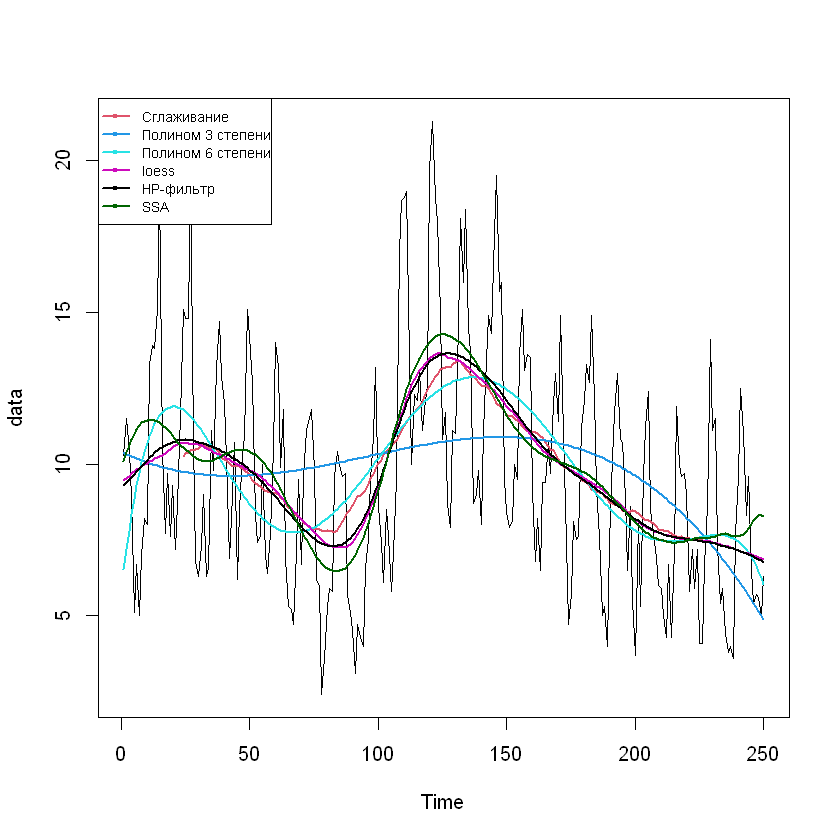

In [70]:
plot(data)
lines(data_avr, col = 2, lwd = 1.7)
lines(polinom3, col = 4, type = "l", lwd = 1.7)
lines(polinom6, col = 5, type = "l", lwd = 1.7)
lines(loess_ts, col = 6, lwd = 1.7)
lines(hp, col = 9, lwd = 1.7)
lines(res$F1, col = "darkgreen", lwd = 1.7)

legend("topleft", c("Сглаживание", "Полином 3 степени", "Полином 6 степени", 
                    "loess", "HP-фильтр", "SSA"), 
       col = c(2, 4, 5, 6, 9, "darkgreen"), cex=0.7, pch=20, lwd = 2)

# Разложение на компоненты
Продолжим рассматривать реальный ряд, содержащий данные о количестве работников, нанятых в сфере сельского хозяйства.

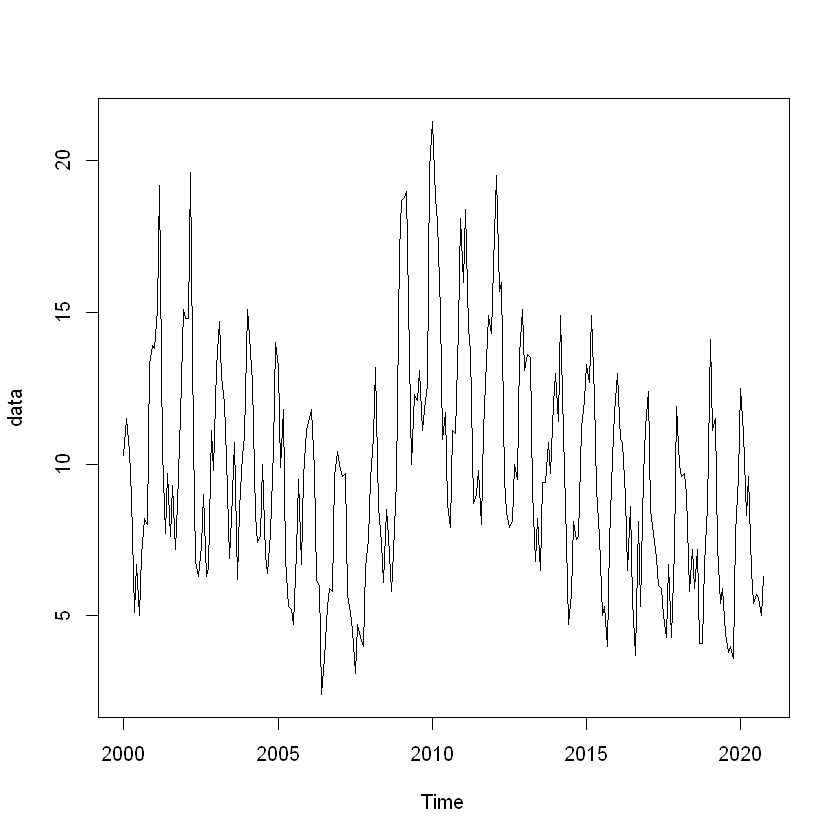

In [71]:
data <- read.table('LNU04035109.csv', sep=',', header=T, row.names = 1)
data <- data[1:250,] 
data <- ts(data, start = c(2000, 1), frequency = 12)
plot(data)

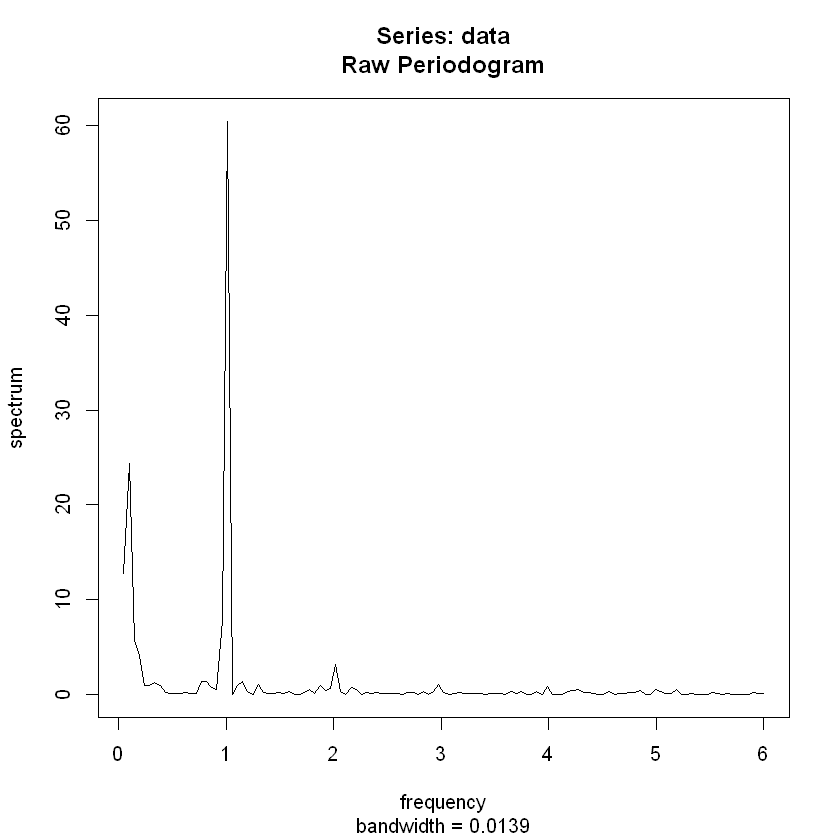

In [72]:
spec.pgram(data, log='no')

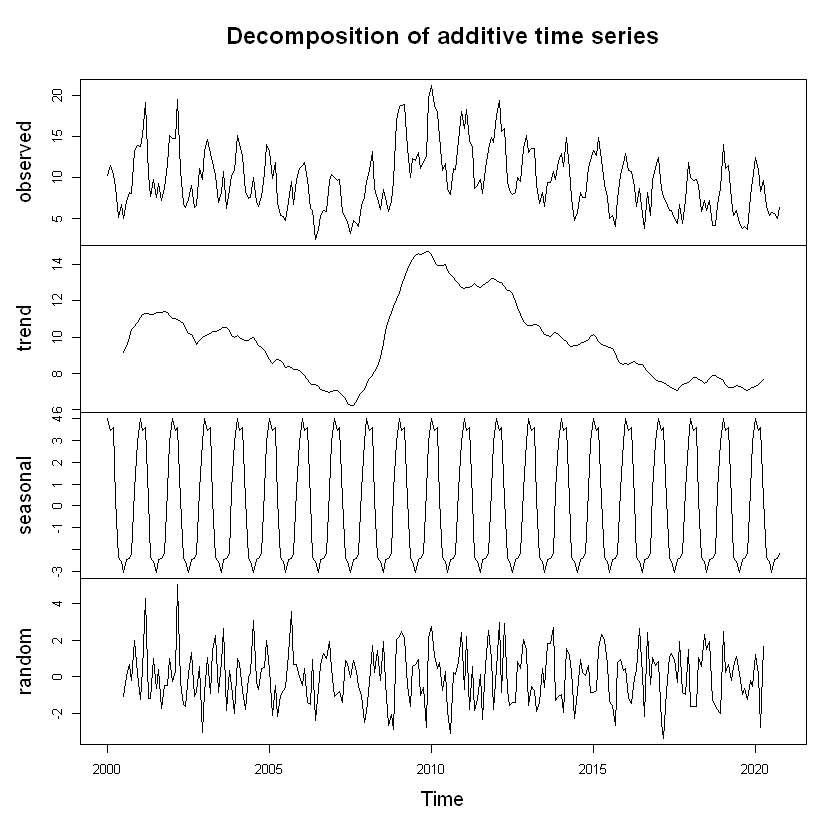

In [73]:
decompose_data <- stats::decompose(data)
plot(decompose_data)

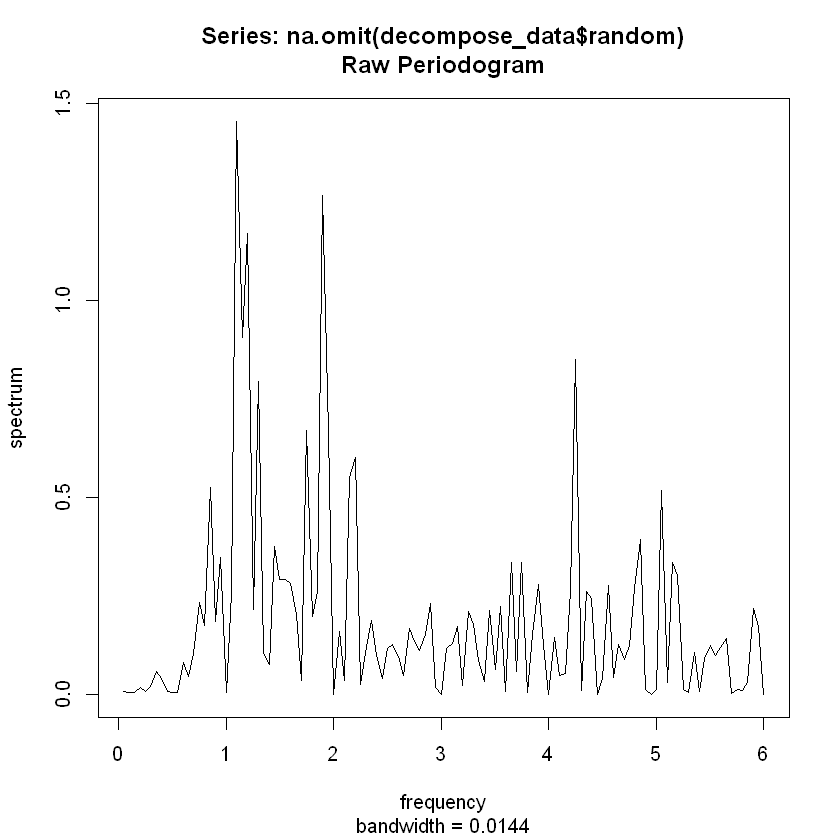

In [74]:
spec.pgram(na.omit(decompose_data$random), log='no')

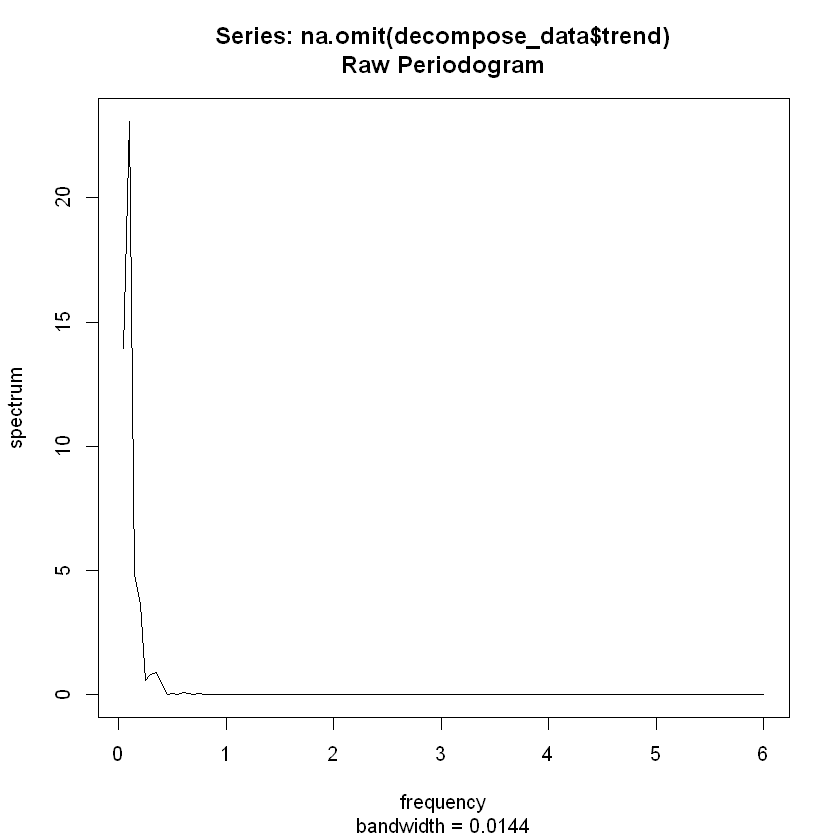

In [75]:
spec.pgram(na.omit(decompose_data$trend), log='no')

По периодограмме тренда создается впечатление, что стандартное разложение включило в тренд часть щума с низкими частотами. Посмотрим, что получится с помощью stl.

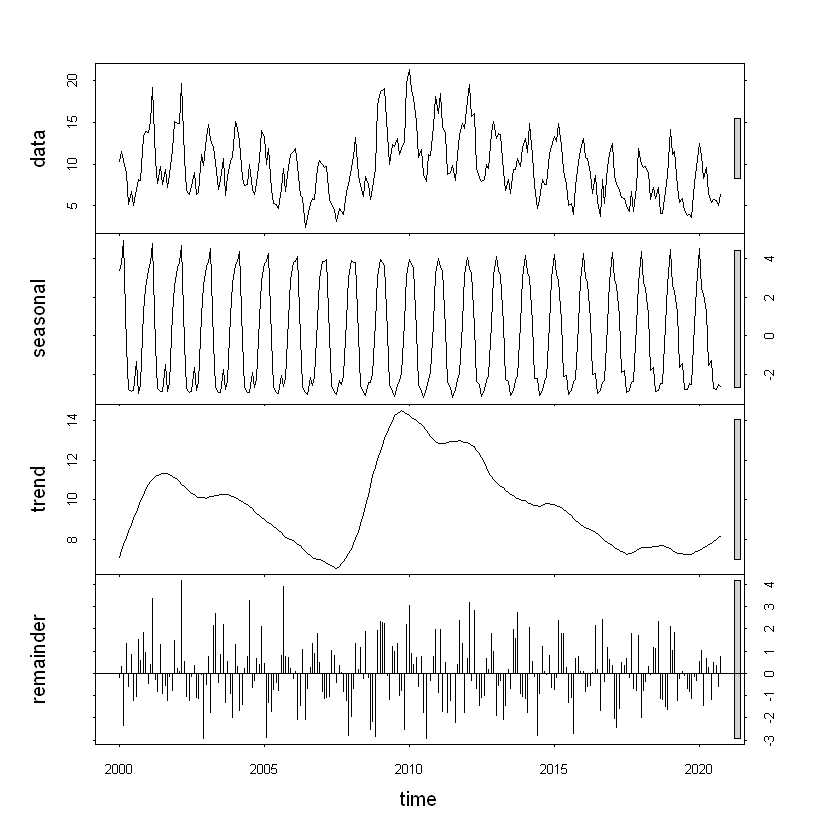

In [76]:
stl_data <- stl(data, s.window = 20, s.degree = 1,
    t.window = 25, t.degree = 1,
    l.window = 0.2, l.degree = 1)
plot(stl_data)

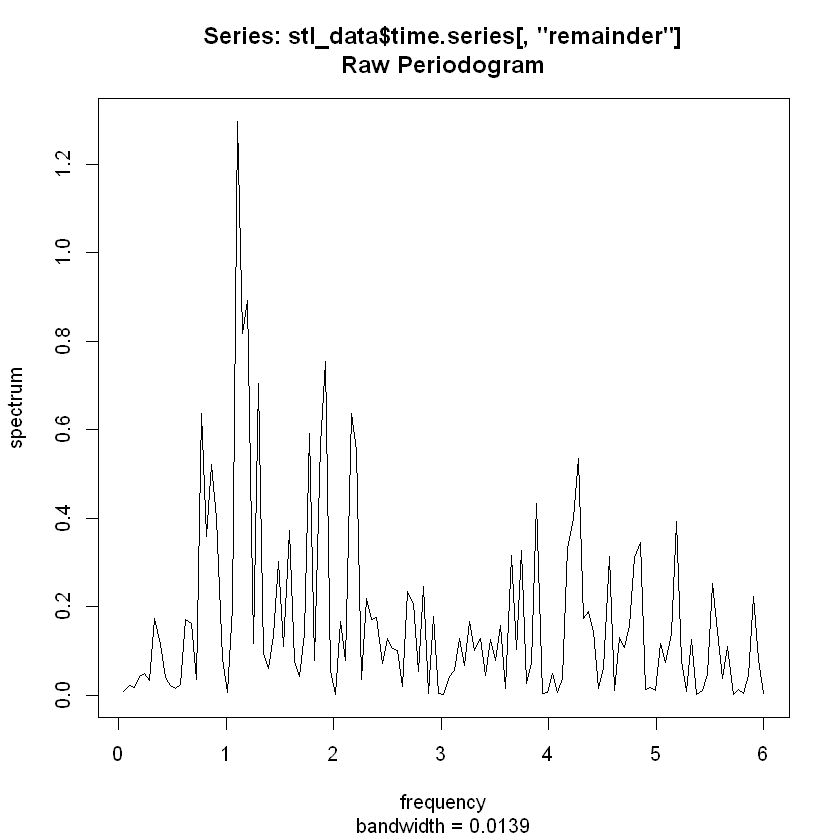

In [77]:
spec.pgram(stl_data$time.series[,"remainder"], log='no')

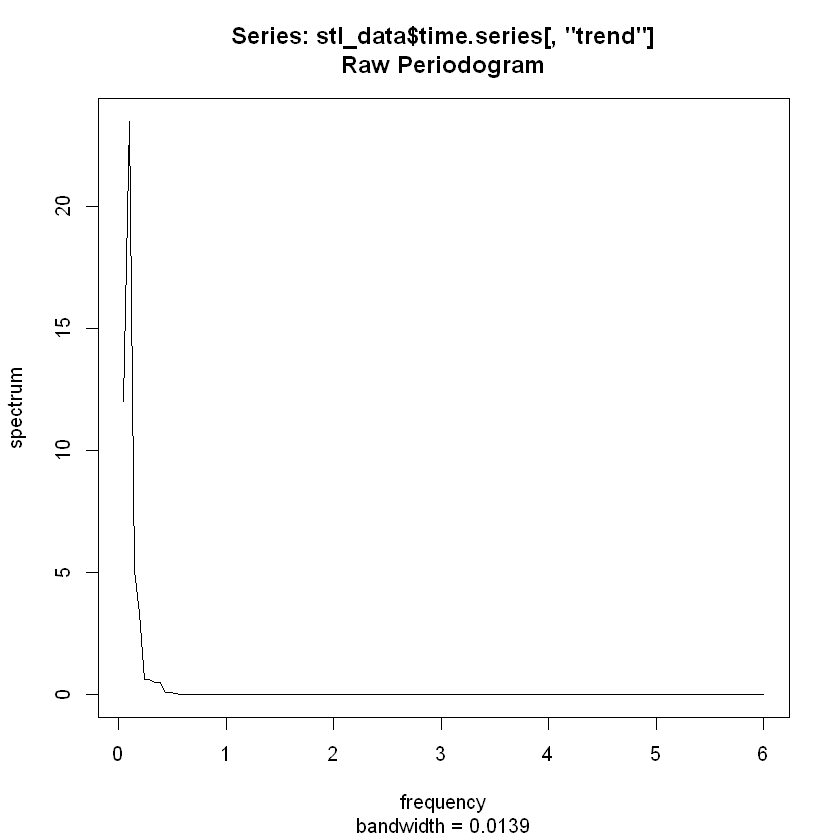

In [78]:
spec.pgram(stl_data$time.series[,"trend"], log='no')

И шум и тренд выглядят неплохо. Повторим SSA.

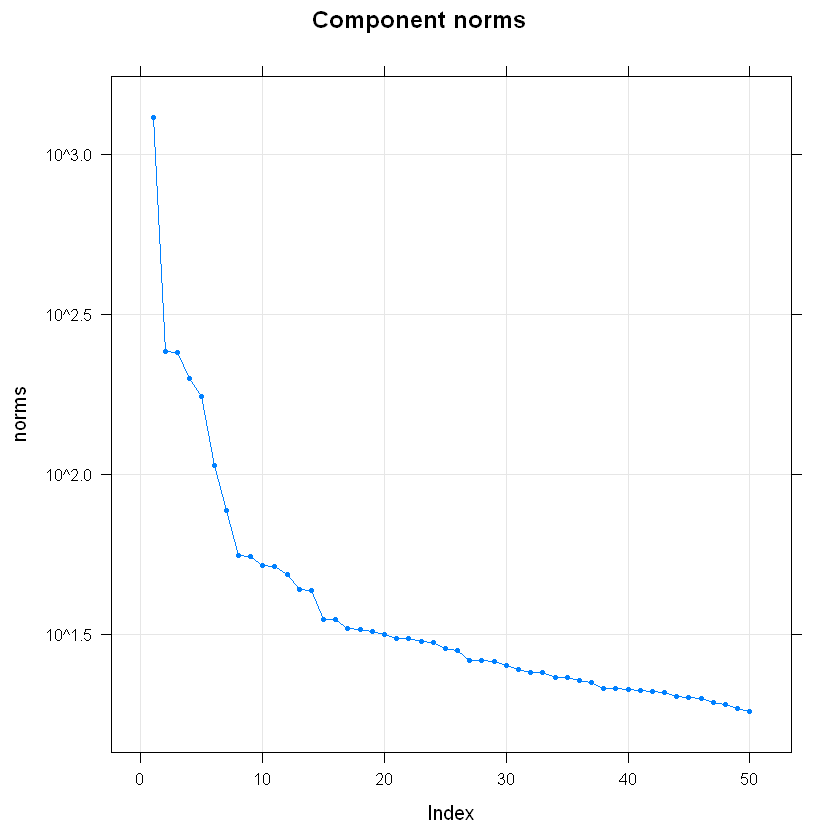

In [79]:
s <- ssa(data, L = 120)
plot(s)

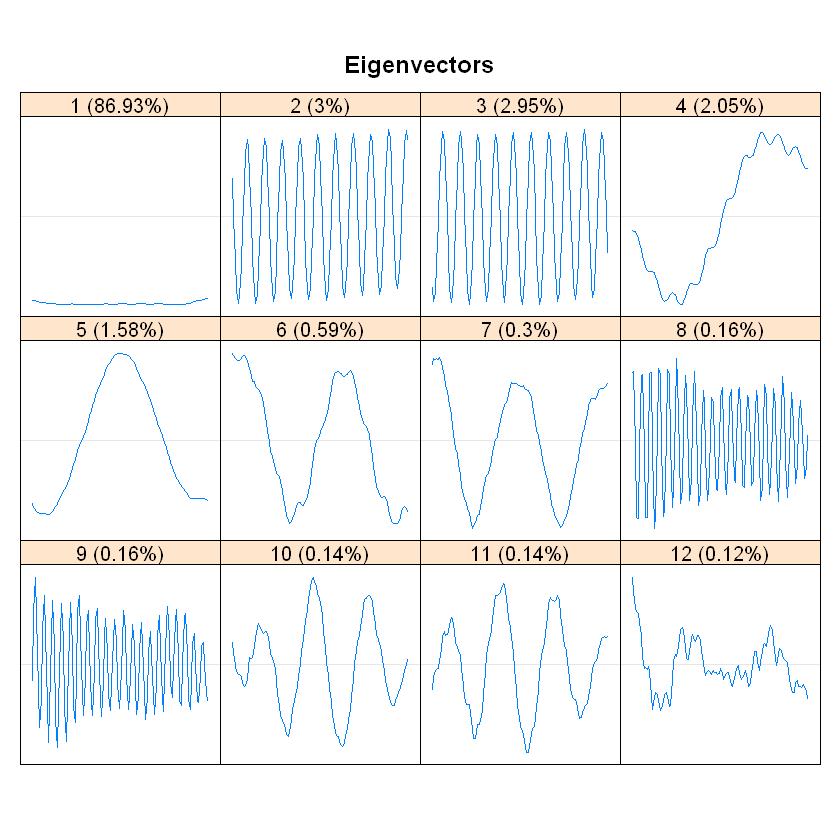

In [80]:
plot(s, type = "vectors", idx = 1:12)

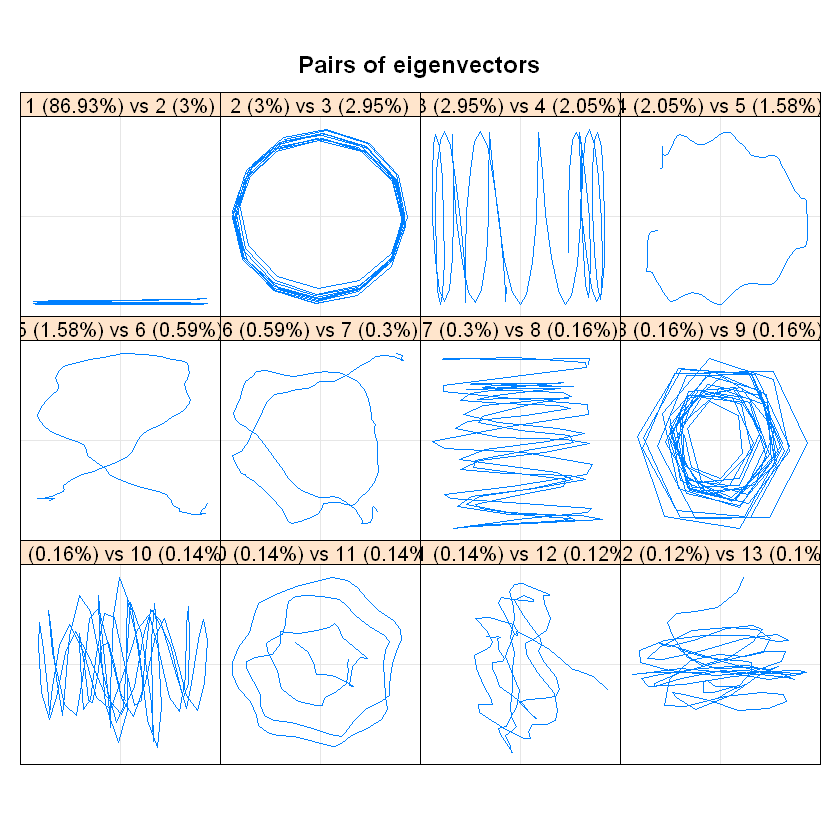

In [81]:
plot(s, type = "paired", idx = 1:12)

$2, 3, 8, 9$ компоненты относятся к периодичности. 

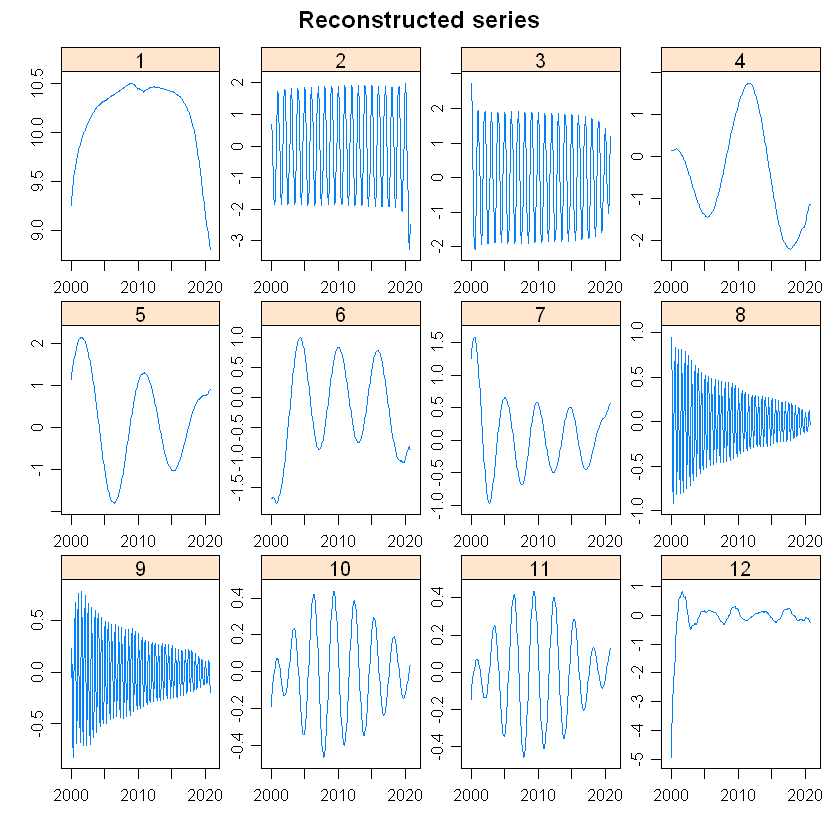

In [82]:
plot(s, type = "series", groups = as.list(1:12))

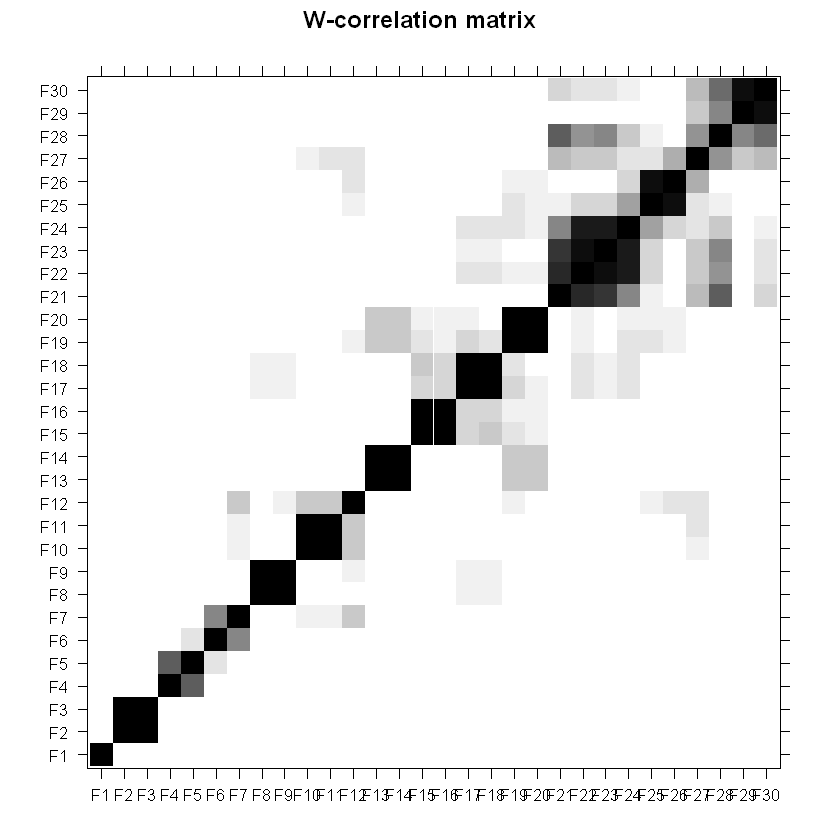

In [83]:
plot(wcor(s, groups = 1:30))

Медленно меняющиеся компоненты отнесем к тренду.

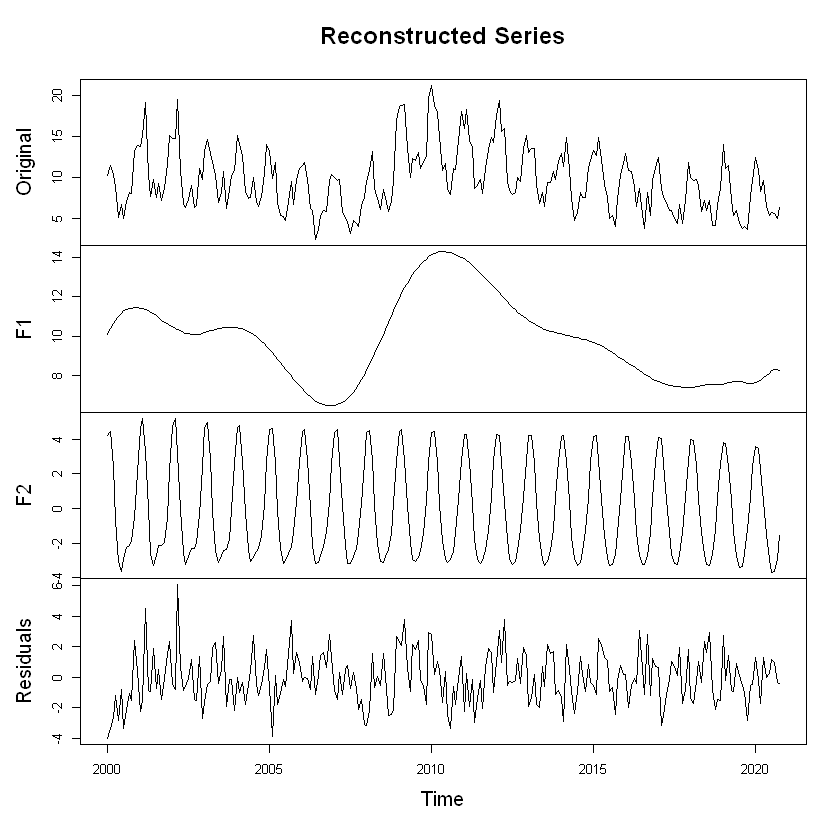

In [84]:
res <- reconstruct(s, groups = list(c(1, 4, 5, 6, 7), c(2, 3, 8, 9)))
plot(res, add.residuals = TRUE, col = c("black", "red"), lwd = c(1, 2))

В конеце тренда появляется "хвост", возможно компоненты смешались. Попробуем исправить это вращениями. 

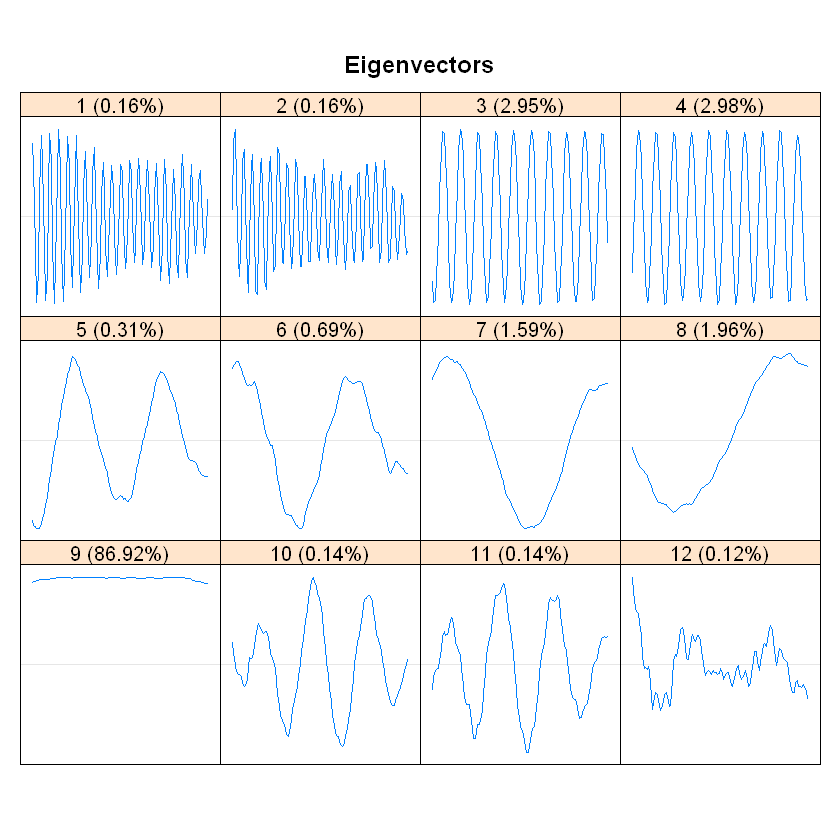

In [85]:
fos <- fossa(s, nested.groups = list(c(1, 4, 5, 6, 7), c(2, 3, 8, 9)),
             filter = c(-1, 1), gamma = Inf, normalize = TRUE)
plot(fos, type = "vectors", idx = 1:12)

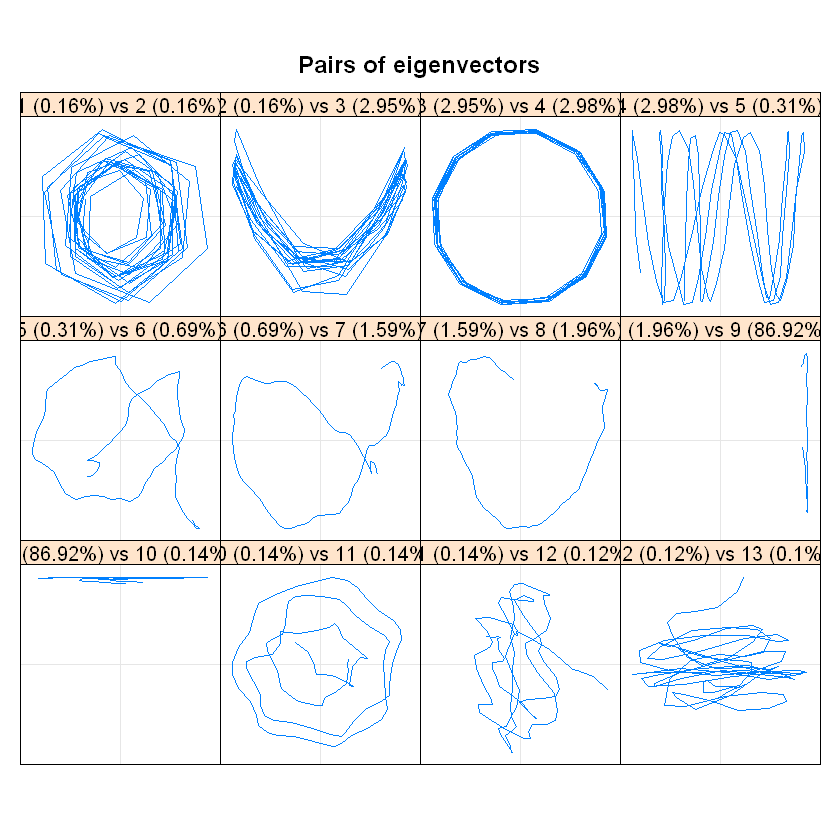

In [86]:
plot(fos, type = "paired", idx = 1:12)

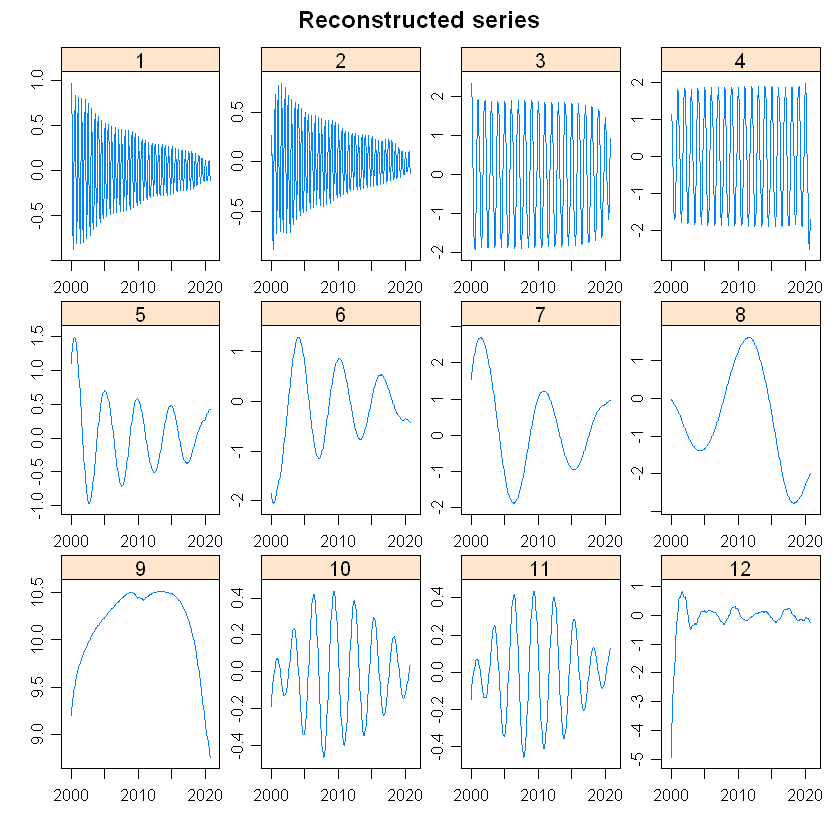

In [87]:
plot(fos, type = "series", groups = as.list(1:12))

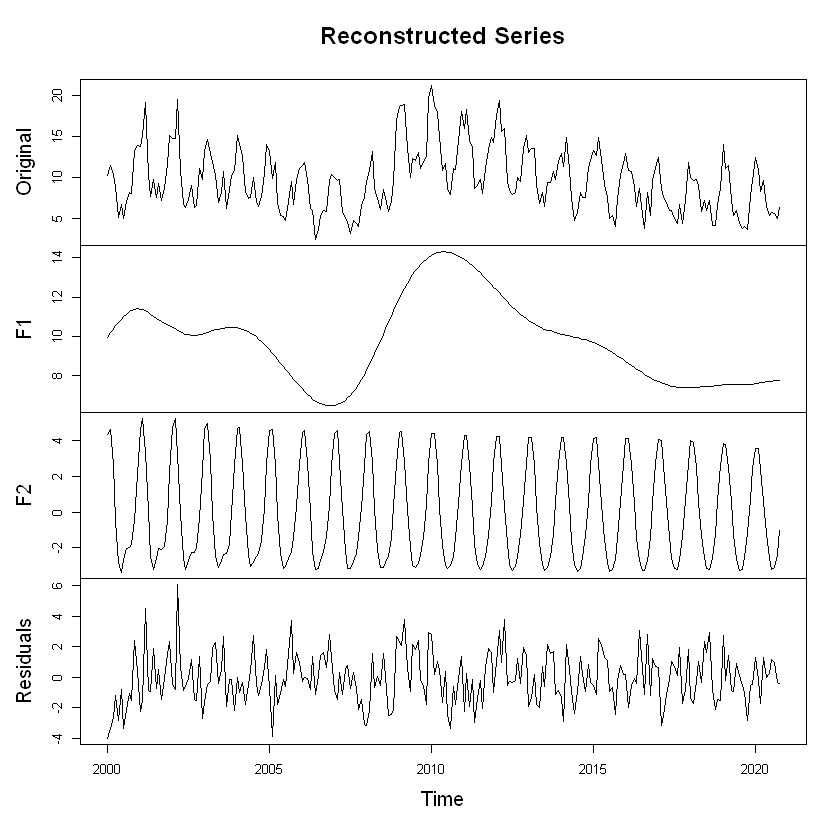

In [88]:
res_fos <- reconstruct(fos, groups = list(c(5, 6, 7, 8, 9), c(1, 2, 3, 4)))
plot(res_fos, add.residuals = TRUE, col = c("black", "red"), lwd = c(1, 2))

"Хвост" убрали. Количество компонент тренда, конечно же осталось таким же.

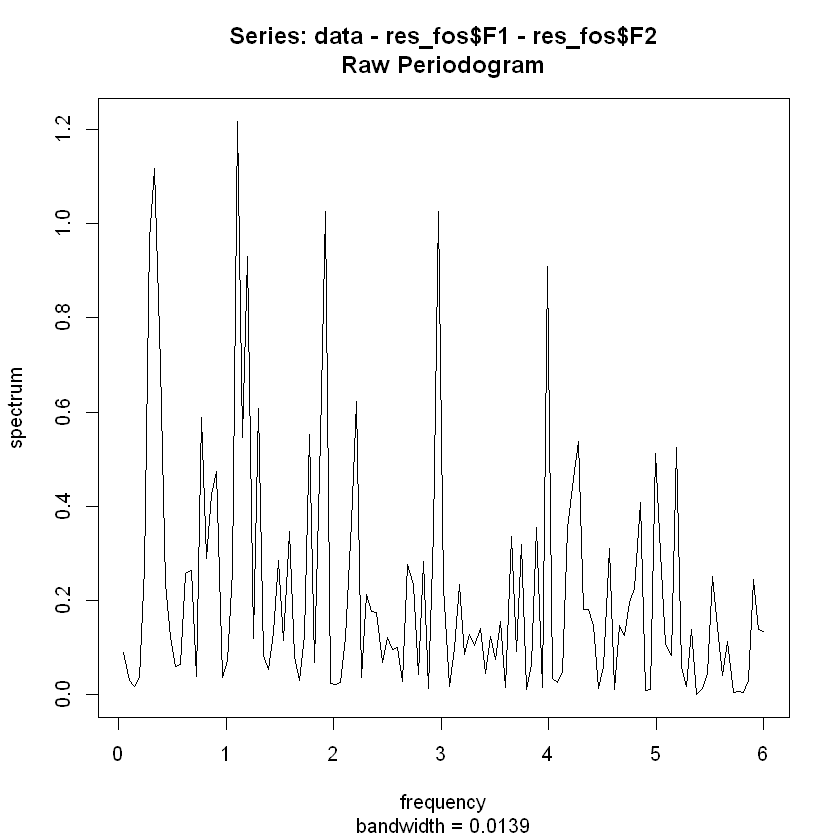

In [89]:
spec.pgram(data-res_fos$F1-res_fos$F2, log='no')

Шум при разложении SSA больше похож на белый.

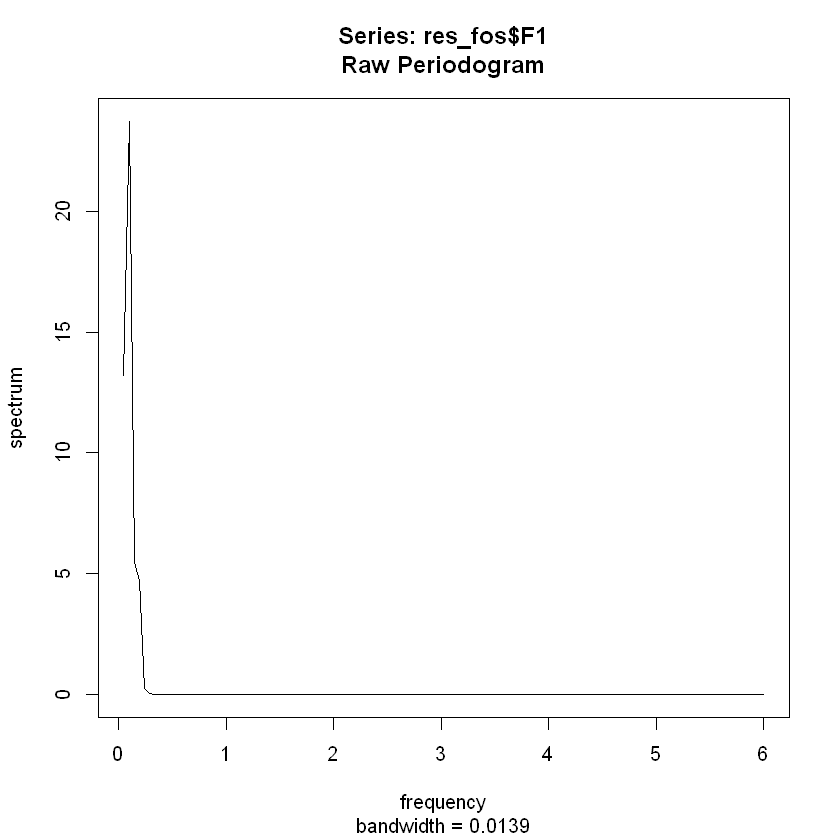

In [90]:
spec.pgram(res_fos$F1, log='no')

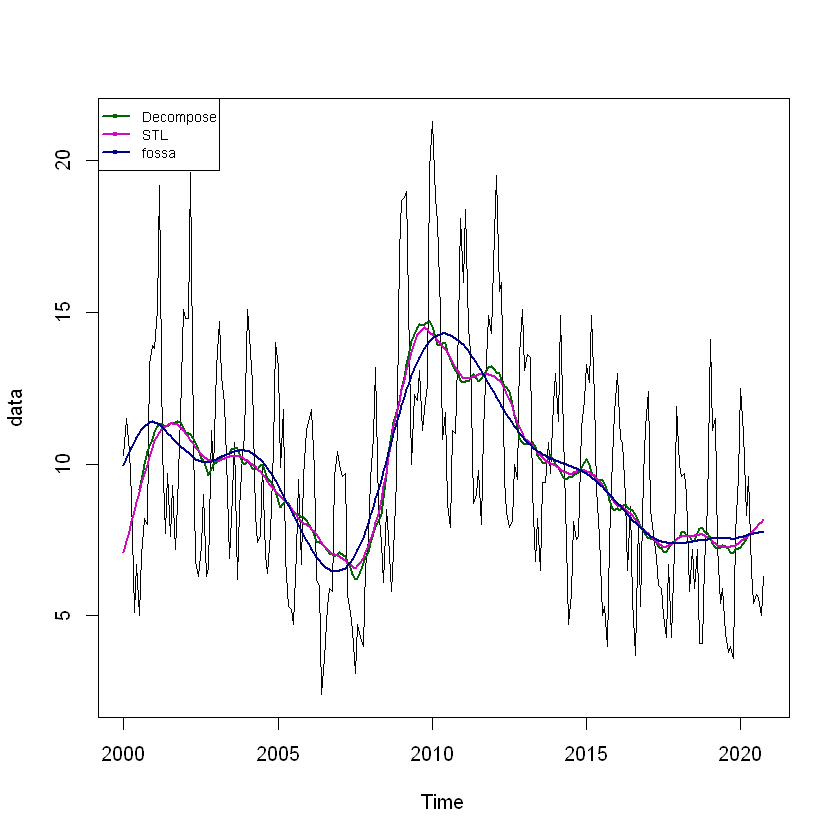

In [91]:
plot(data)
lines(decompose_data$trend, col = "darkgreen", lwd = 2)
lines(stl_data$time.series[,2], col = 6, lwd = 2)
lines(res_fos$F1, col = "darkblue", type = "l", lwd = 2)

legend("topleft", c("Decompose", "STL", "fossa"), 
       col = c("darkgreen", 6, "darkblue"), cex=0.7, pch=20, lwd = 2)

# Огибающая

Сгенерируем ряд

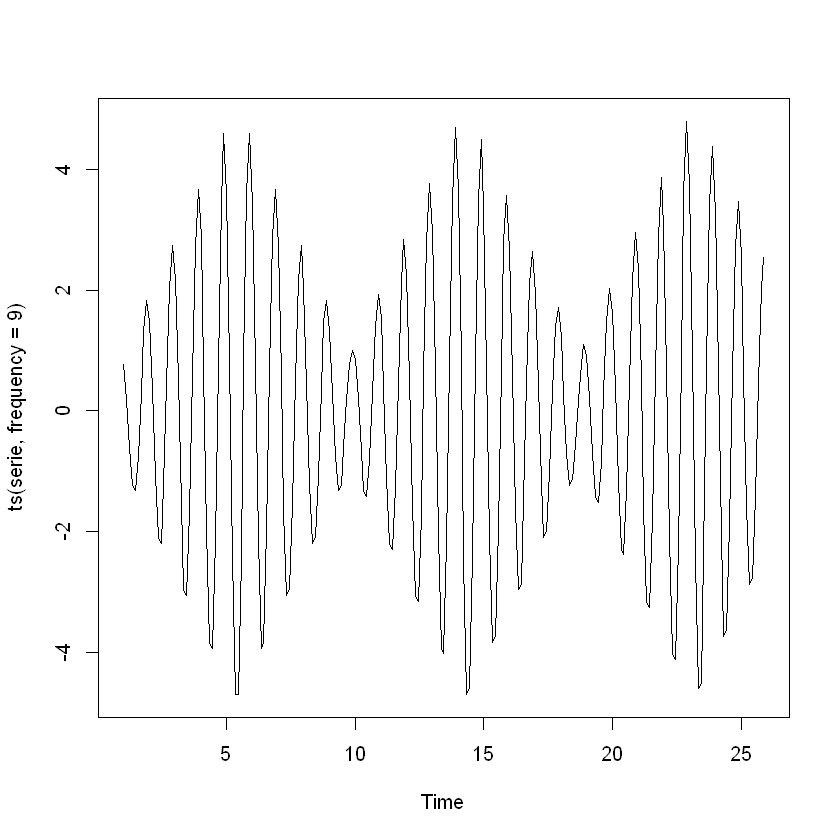

In [92]:
set.seed(120)
N <- 225
n <- 1:N
omega <- 25/N
A <- rep(c(seq(1, 5, length.out = 40), seq(5, 1, length.out = 40)), 4)[1:N]
serie <- A*cos(2*pi*omega*n)
plot(ts(serie, frequency = 9), type = "l")

Ряд имеет вид $x_n = A(n) \cdot cos(2\pi\omega n)$.   
Рассмотрим $y_n = 2 \cdot A^2(n) \cdot cos^2(2\pi\omega n) = 2 \cdot A^2(n) \cdot \frac{1+cos(4\pi\omega n)}{2} = A^2(n) + A^2(n)cos(4\pi\omega n)$.   
Отсюда огибающую для исходного ряда можно получить, если возвести ряд в квадрат и выделить тренд.

Посмотрим на амплитуду в квадрате, именно ее мы будем выделять как тренд.

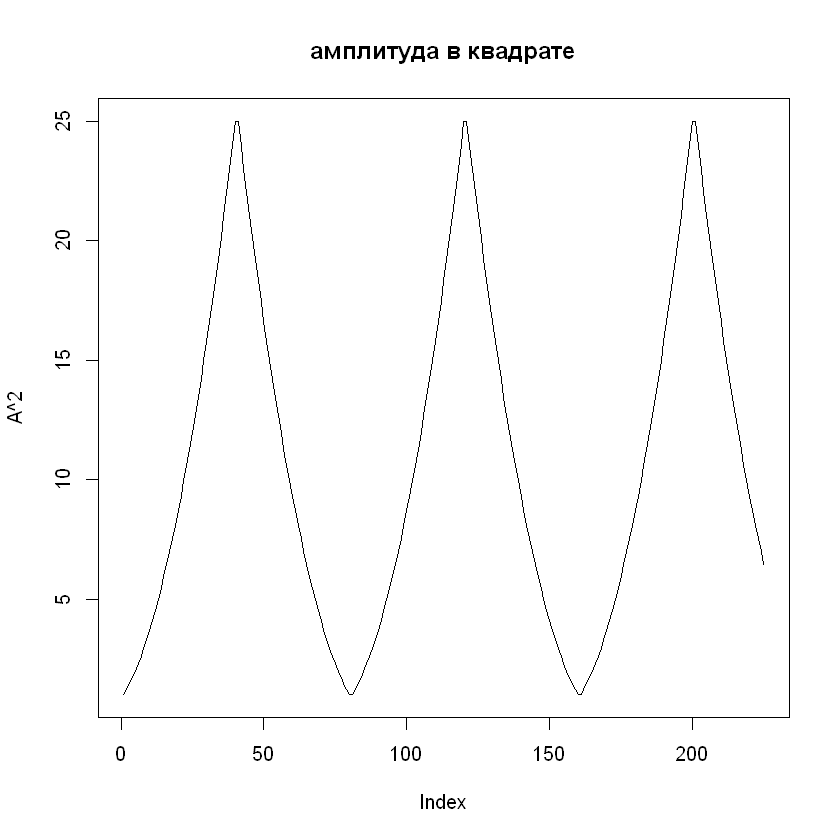

In [93]:
plot(A^2, type = "l", main = "амплитуда в квадрате")

На графике есть острые пики, важно их не сгаживать.   
Возведем ряд в квадрат.

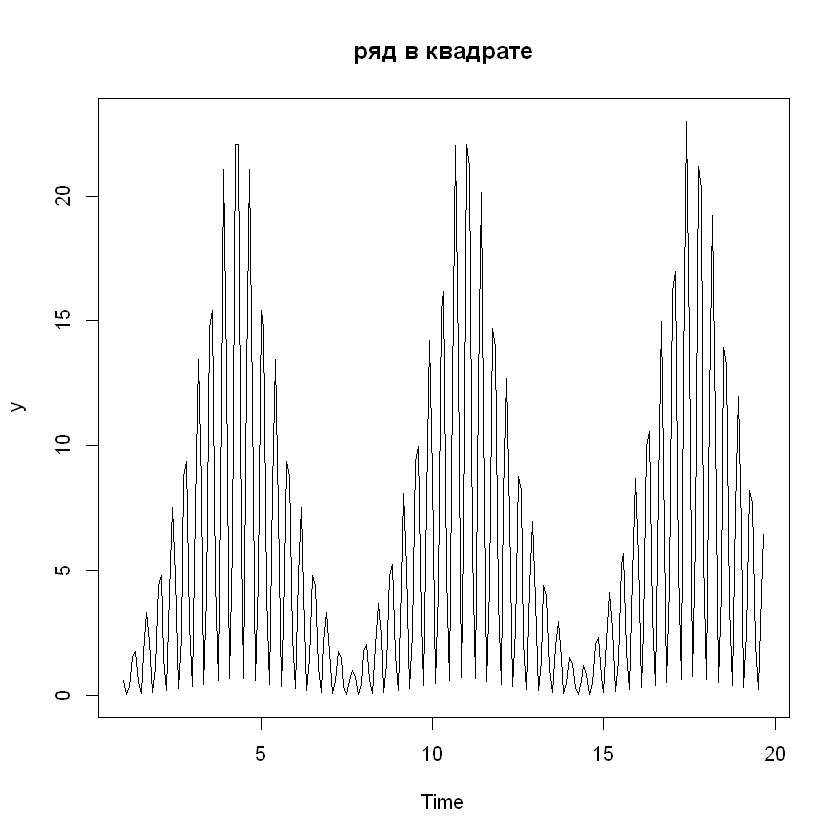

In [94]:
y <- ts(serie^2, frequency = 12)
plot(y, main = "ряд в квадрате")

Рассмотрим разложение decompose с мультипликативной моделью.

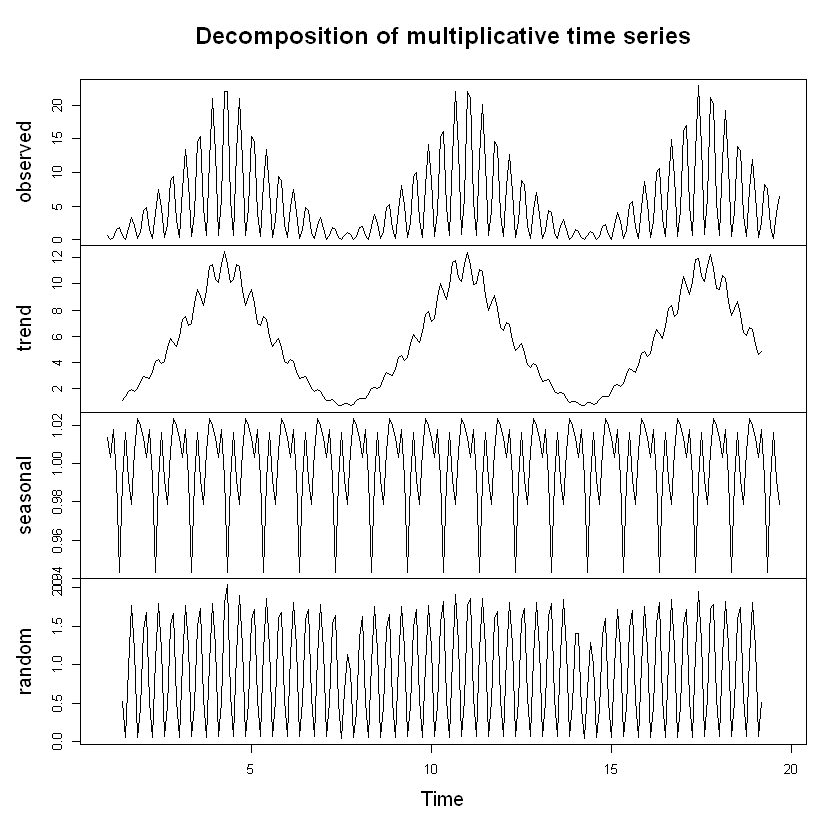

In [95]:
d <- stats::decompose(y, type = "multiplicative", filter = rep(1/12, 12))
plot(d)

С трендом точно смешалась гармоника. 

Поопробуем разложение STL. Параметр s.window отвечает за размер окна для усреднения по "сезонности". Так как в нашем случае частота $ = 12$, а длина ряда $N = 210$, то этот аргумент не должен привышать $17$. Параметр t.window отвечает за окно для выделения тренда. То есть параметр должен быть небольшим, чтобы не сгладить острые пики. 

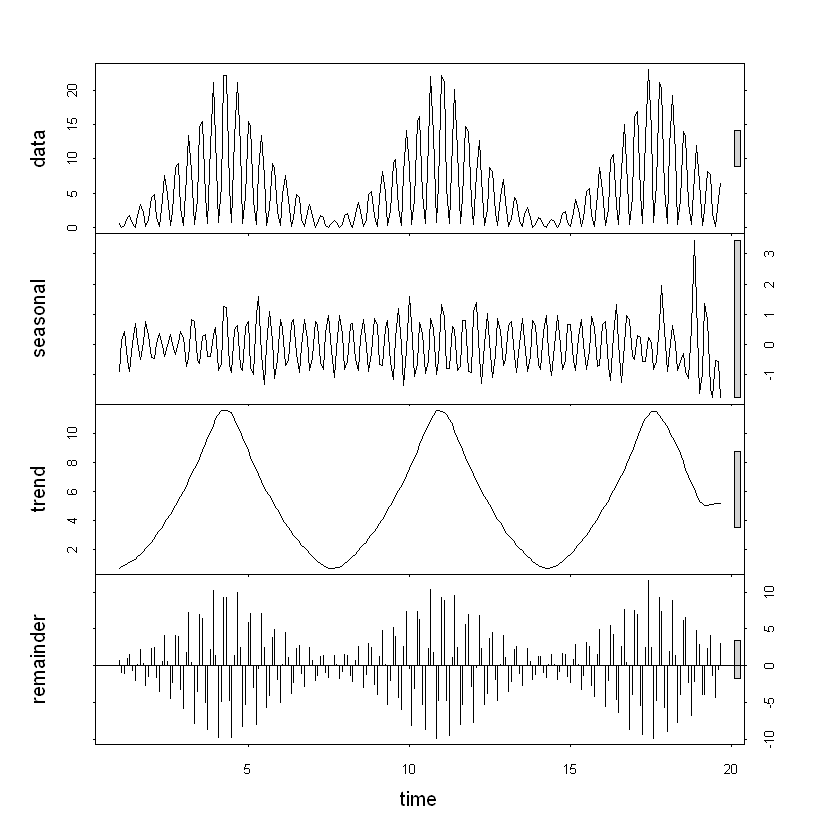

In [96]:
y <- ts(serie^2, frequency = 12)
stl_y <- stl(y, s.window = 7, s.degree = 1,
    t.window = 15, t.degree = 1,
    l.window = 0.2, l.degree = 1)
plot(stl_y)

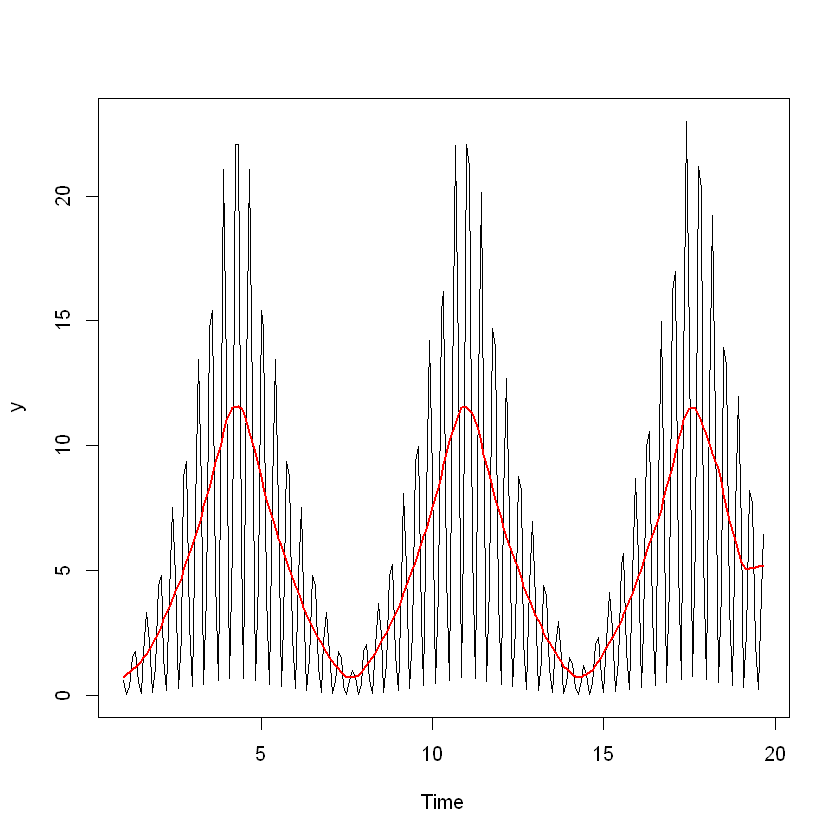

In [97]:
plot(y)
lines(stl_y$time.series[,"trend"], col = "red", lwd = 2)

Чтобы перейти к огибающей исходного ряда нужно извлечь корень из найденного тренда и умножить на $\sqrt{2}$, так как мы рассмотривали просто ряд возведенный в квадрат, а не $y$ из формулы.

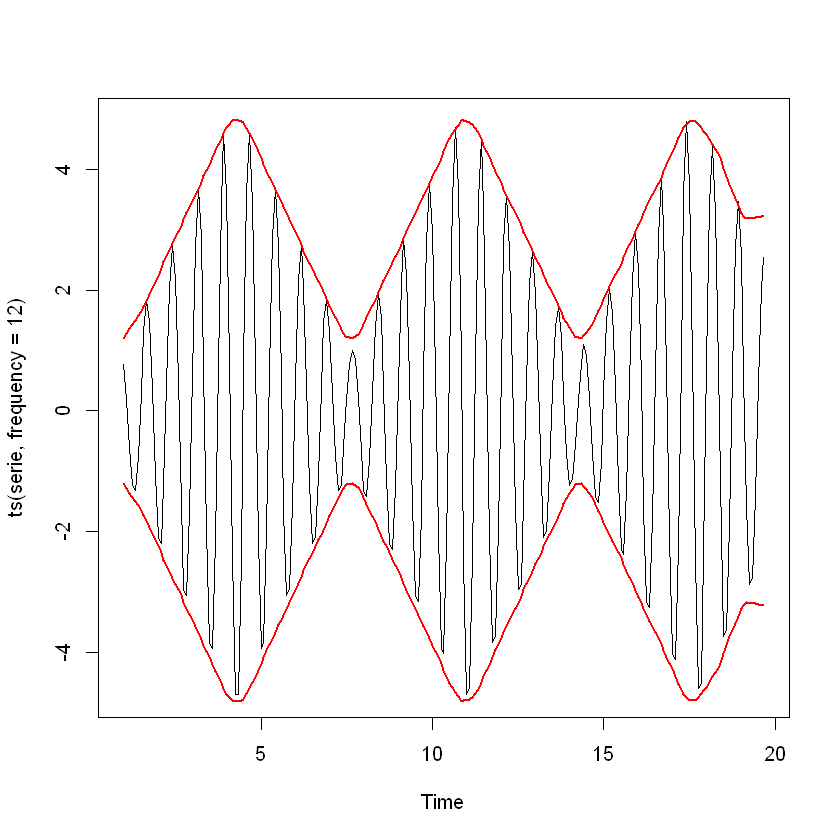

In [98]:
trend_x <- sqrt(2*stl_y$time.series[,"trend"])
plot(ts(serie, frequency = 12))
lines(trend_x, col = "red", lwd = 2)
lines(-trend_x, col = "red", lwd = 2)

Переходим к SSA

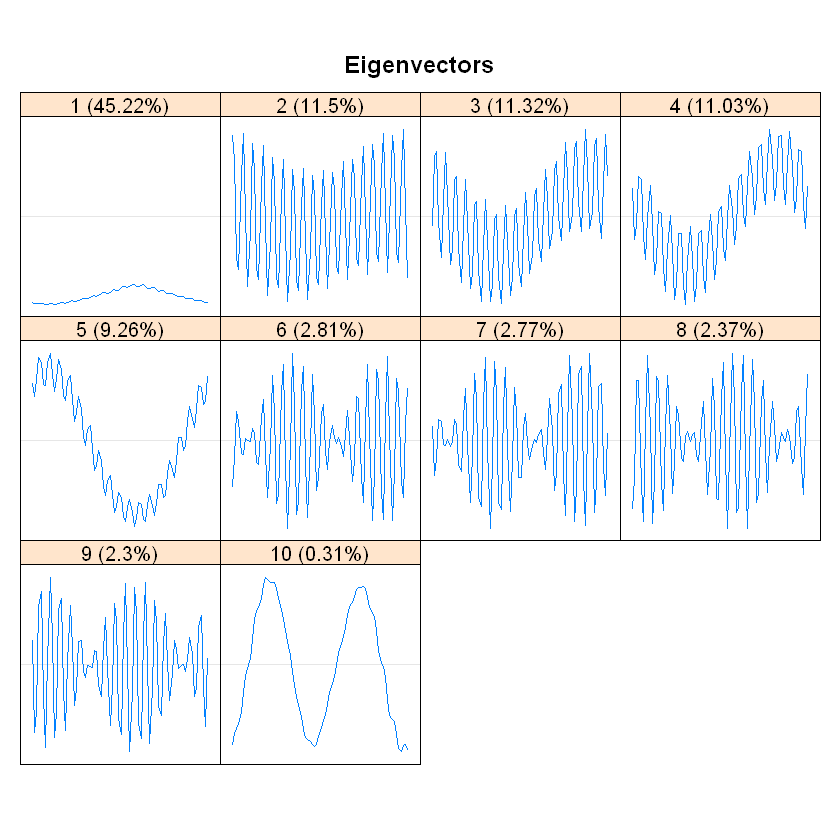

In [99]:
s <- ssa(y, L = 80)
plot(s, type = "vectors", idx = 1:10)

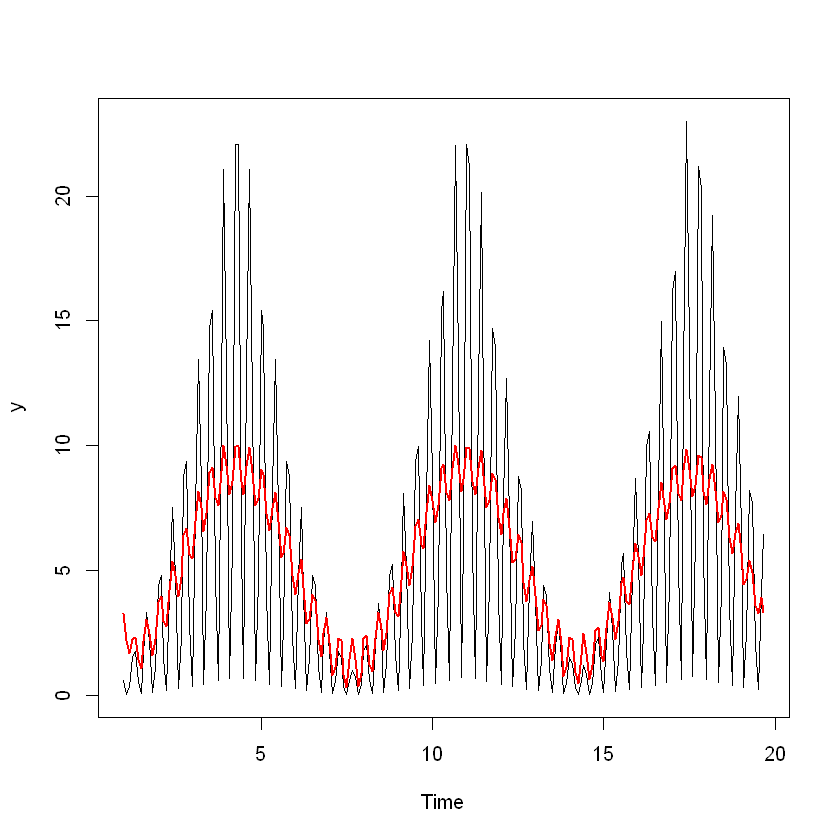

In [100]:
res <- reconstruct(s, groups = list(c(1, 4, 5), c(2,3)))
plot(y)
lines(res$F1, col = "red", lwd = 2)

Здесь тоже очевидно, что компоненты сешались. Попробуем исправить это вращениями. 

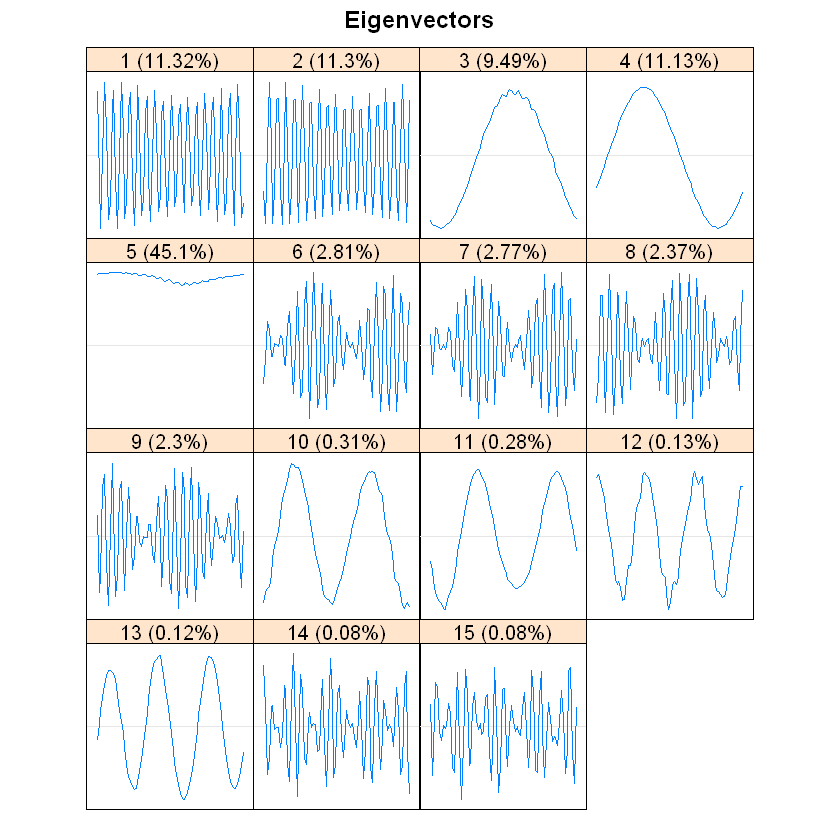

In [101]:
f <- fossa(s, nested.groups = list(c(1:5)))
plot(f, type = "vectors", idx = 1:15)

Теперь все медленно меняющиеся компоненты отнесм к тренду. 

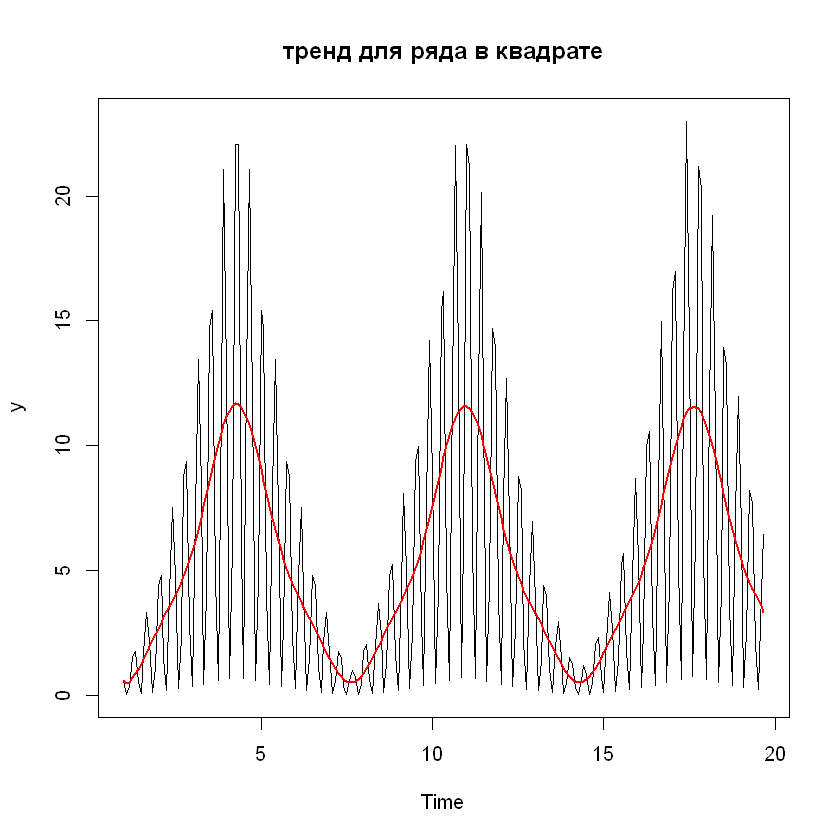

In [102]:
res_f <- reconstruct(f, groups = list(c(3, 4, 5, 10:13)))
plot(y, main = "тренд для ряда в квадрате")
lines(res_f$F1, col = "red", lwd = 2)

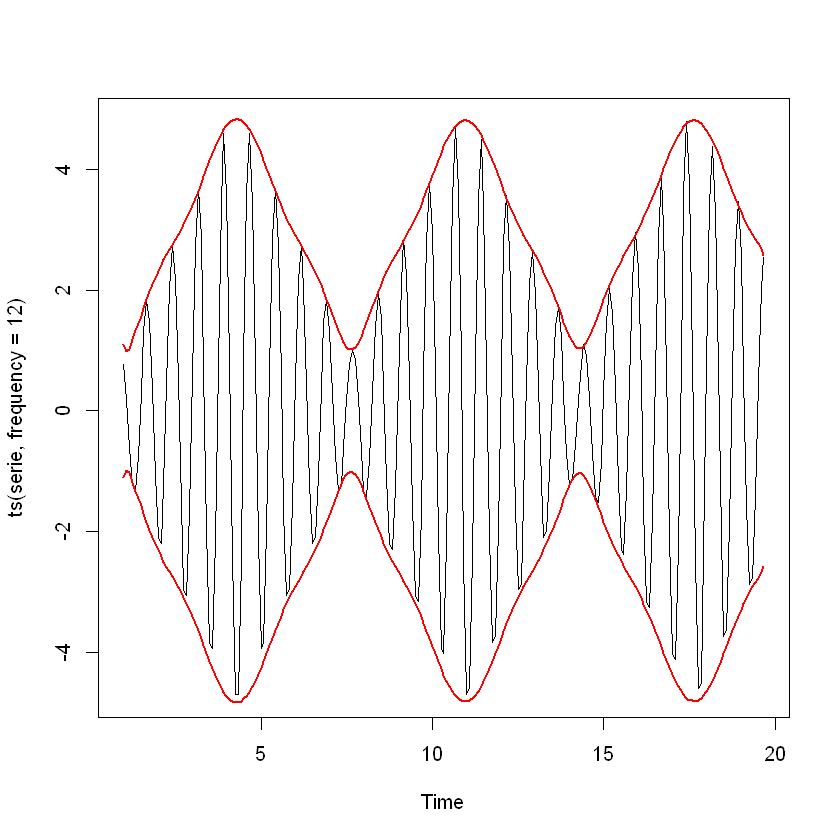

In [103]:
trend_x_ssa <- sqrt(2*res_f$F1)
plot(ts(serie, frequency = 12))
lines(trend_x_ssa, col = "red", lwd = 2)
lines(-trend_x_ssa, col = "red", lwd = 2)

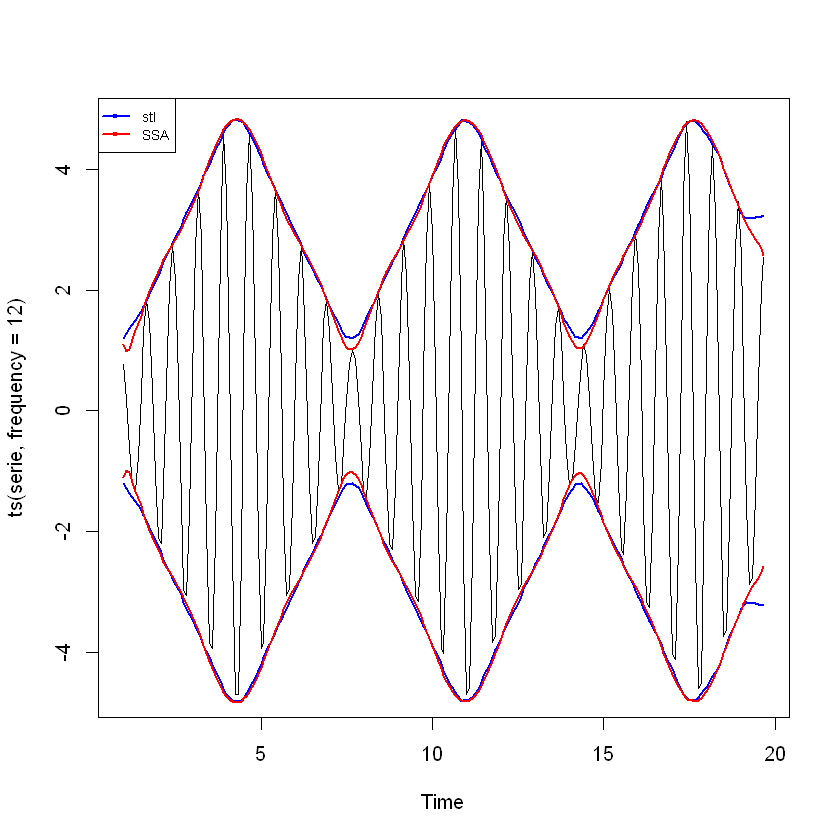

In [104]:
plot(ts(serie, frequency = 12))
lines(trend_x, col = "blue", lwd = 2)
lines(-trend_x, col = "blue", lwd = 2)
lines(trend_x_ssa, col = "red", lwd = 2)
lines(-trend_x_ssa, col = "red", lwd = 2)
legend("topleft", c("stl", "SSA"), 
       col = c("blue", "red"), cex=0.7, pch=20, lwd = 2)

Огибающие, найденные с помощью STL и SSA, практически совпадают, кроме конца ряда и мест сужения графика. 